# Importing Libraries

In [382]:
from requests import ConnectionError
import requests
import json
from dateutil import tz
from dateutil.relativedelta import relativedelta
import datetime
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
import warnings
warnings.filterwarnings('ignore')
import time
import os
connection_timeout = 300
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm.auto import tqdm
import snowflake.connector
from snowflake.connector import ProgrammingError
import pickle
from datetime import datetime, timedelta


# Snowflake Function

In [383]:
import snowflake.connector
import pandas as pd
import os

# -----------------------------------------------------------------------------
# STEP 1: Define your list of Configurations (Role, Warehouse, DB, Schema)
# -----------------------------------------------------------------------------
ROLE_CONFIGS = [
    # 1. APIGEE Configuration (Specific Data Space)
    {
        'role': 'A202210_APIGEE_ENTITY_DATA_MDS_OWNER',
        'warehouse': 'A202210_APIGEE_ENTITY_DATA_MDS_WH',
        'database': 'MYDATASPACE',
        'schema': 'A202210_APIGEE_ENTITY_DATA'
    },
    
    # 2. PROD EMS Configuration (Standard Production Data)
    {
        'role': 'PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC',
        'warehouse': 'SYSTEM$STREAMLIT_NOTEBOOK_WH',
        'database': 'PROD',
        'schema': 'SOURCE'
    },

    # 3. Personal User Fallback (If specific roles fail)
    {
        'role': 'TR_RELANGIYUGENDARSAIRAM@THOMSONREUTERS.COM', 
        'warehouse': 'PROD_READONLY',
        'database': 'PROD',
        'schema': 'SOURCE'
    }
]

# -----------------------------------------------------------------------------
# STEP 2: Connection Function (Accepts ALL Dynamic Parameters)
# -----------------------------------------------------------------------------
def connect_to_snowflake(role, warehouse, database, schema):
    conn_params = {
        'account': 'a206448_prod.us-east-1',
        'user': 'relangiyugendarsairam@thomsonreuters.com',
        'authenticator': 'externalbrowser',
        'client_session_keep_alive': True,
        'login_timeout': 60,
        
        # --- DYNAMIC PARAMETERS ---
        'role': role,
        'warehouse': warehouse,
        'database': database,
        'schema': schema
    }
    
    try:
        print(f"Connecting to {database}.{schema} (Role: {role})...")
        conn = snowflake.connector.connect(**conn_params)
        return conn
    except snowflake.connector.errors.ProgrammingError as e:
        print(f"  [!] Connection failed for {role}: {e}")
        return None

# -----------------------------------------------------------------------------
# STEP 3: Execution Function
# -----------------------------------------------------------------------------
def execute_query_and_return_dataframe(conn, query):
    try:
        df = pd.read_sql(query, conn)
        return df
    except Exception as e:
        print(f"  [!] Query failed: {e}")
        return None

# -----------------------------------------------------------------------------
# STEP 4: Main Logic (Iterates through configs)
# -----------------------------------------------------------------------------
def main(sql, file_name=None):
    df_result = None
    
    # --- LOOP: Try each configuration one by one ---
    for config in ROLE_CONFIGS:
        # Unpack the current configuration
        role = config['role']
        wh = config['warehouse']
        db = config['database']
        sch = config['schema']
        
        # 1. Connect
        conn = connect_to_snowflake(role, wh, db, sch)
        
        if conn:
            # 2. Try to run the query
            print(f"  Attempting query execution...")
            df_result = execute_query_and_return_dataframe(conn, sql)
            
            # 3. Close connection
            conn.close()
            
            # 4. Success Check
            if df_result is not None:
                print(f"SUCCESS: Query ran successfully using role {role}.")
                break  # Stop the loop, we found the data!
            else:
                print(f"  Retrying with next configuration...")
        else:
             print(f"  Skipping to next configuration...")

    # --- END LOOP ---

    # 5. Handle the Final Result
    if df_result is not None:
        if file_name:
            # Adjust path as necessary
            file_path = fr"C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\{file_name}"
            # Create directory if it doesn't exist to prevent errors
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            
            df_result.to_csv(file_path, index=False)
            print(f"DataFrame saved to {file_path}")
        return df_result
    else:
        print("ERROR: All configurations failed. Could not retrieve data.")
        return None


In [384]:
from sqlalchemy import create_engine

def connect_to_ems(query, database_name):
    """
    Connects to a SQL Server database using SQLAlchemy and SQL Server Authentication,
    executes the given SQL query, and returns the result as a pandas DataFrame.

    Args:
        query (str): The SQL query string to execute.

    Returns:
        pandas.DataFrame: A DataFrame containing the query results, or None if an error occurs.
    """
    # Connection parameters provided by the user
    # IMPORTANT: Ensure 'ODBC Driver 17 for SQL Server' or the appropriate version
    # is installed on your system.
    server = 'egmissqlprod3.int.thomsonreuters.com,1600'  # include port number if applicable
    database = database_name  # adjust this to your database name
   

    # Create the connection URL for SQLAlchemy using SQL Server Authentication
    # 'mssql+pyodbc://' specifies the dialect and driver.
    # 'username:password@server:port/database' specifies authentication details.
    # '?driver=ODBC+Driver+17+for+SQL+Server' specifies the ODBC driver.
    # Note: Trusted_Connection=yes is removed as we are now using username/password.
    connection_url = (
        "mssql+pyodbc://"
        f"{server}/{database}"
        "?driver=ODBC+Driver+17+for+SQL+Server&Trusted_Connection=yes"
    )

    try:
        print(f"Attempting to connect to: {server}/{database}")
        # Create the SQLAlchemy engine
        engine = create_engine(connection_url)

        # Confirm the connection by attempting to connect
        with engine.connect() as connection:
            print("✅ Connected to the database successfully!")

        # Execute the query and load data into a DataFrame
        # pd.read_sql is used with the SQLAlchemy engine
        df = pd.read_sql(query, engine)
        return df

    except Exception as e:
        print(f"❌ Error occurred: {e}")
        print("Please ensure:")
        print("1. 'ODBC Driver 17 for SQL Server' is installed.")
        print("2. The username and password are correct and have access to the database.")
        print("3. The server name and database name are correct.")
        print("4. Network connectivity to the SQL Server is established and the port is open.")
        return None


# GFR cancelled and active accounts data

In [385]:
query_firm_status = """
WITH LatestFirmUpdates AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY firm_id ORDER BY update_date DESC) AS rn
    FROM PROD.SOURCE.EMS_DBO_FPV_LIMITED_VW
    WHERE product_code IN ('GFILERMP', 'GFILERM', 'GFRTXFLP', 'GFRTXFLO')
)

SELECT *,
       CASE 
           WHEN license_expiration_date IS NULL OR license_expiration_date > GETDATE() THEN 'Active'
           ELSE 'Cancelled'
       END AS status_flag
FROM LatestFirmUpdates
WHERE rn = 1;
"""


In [386]:
# Execute the main function and get the dataframe

df_firm_status = main(query_firm_status)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLRbtowFIZfJfKuYzuBFmYBVUZWNRIriABVezN5iQGPxM58nIb26eeERuou2ovdRc53jr%2Fj%2F0xuzmXhPQsDUqspCjBFnlCZzqU6TNF2c%2BuPkQeWq5wXWokpehGAbmYT4GVRsai2R7UWf2oB1nONFLDuxxTVRjHNQQJTvBTAbMbS6MeChZiyymirM12gdyWfV3AAYawz7EtykE7vaG3FCGmaBjcDrM2BhJRSQr8SR7XIl54%2Fu5k%2B4ANChy3vCIev3ty%2BSXV5gs%2B0fl0gYHebzcpfLdMN8qJeda4V1KUwqTDPMhPb9eIiAM4gCun1cDj%2BuVovY1yDLzhYP8CgdLMv%2BElkuqxq61pj90X2IieFPkg3fRJPUXWSefAa3J1l8l2r6B52p8VrGM9PzWivfnO%2BjoPd1TYLHx7sPDw8Zsjb9fGGbbwJQC0S1YZq3RENr30a%2BOF4Q0dscMUGY0xHoyfkxS5UqbjtKntzAI3tUZeglRG1dY07RZlXJE2XuI0yRJf1YN1FZvZfQ0%2FI%2BxZv63bvEkjilS5k9uLdalNy%2B3FAAQ66E5n7%2Bw5louSyiPLcCAAXVFHoZm4Et26rrakFIrPLrf%2Fu9ewv&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAAAZwDh4

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJBU%2BIwFMe%2FSid7bpIWVMwADktHZVal0OLBy05sA2Rpk5qXUPz2G4rMuAc97K2T%2Ft7L7%2BX%2FhjeHugr2woDUaoQiTFEgVKFLqTYjtMpvwwEKwHJV8korMULvAtDNeAi8rho2cXarluLNCbCBb6SAdT9GyBnFNAcJTPFaALMFyyaPDyzGlDVGW13oCn0q%2Bb6CAwhjveG5pATp9bbWNoyQtm1x28PabEhMKSX0mnjqiPw48wc%2F0xd8RGj%2FyHvC4%2BmH20%2BpTk%2FwndbrCQJ2n%2BdpmM6zHAWTs%2BpUK3C1MJkwe1mI1fLhJADeYBLTy35%2F8DtdzhPsIBQcbBhhULpdV3wnCl03zvrW2H%2BRtShJpTfSTz9LRqjZyXJ9tbi7308fly9%2FFjB3q2T3665qssWzy%2BXu9TDIRTJ%2FM1FC06JAwfM53vgY7wzAiZk6hmr9EY0vQxqF8SCnV6x3wS4oHlz3XlCQ%2BFCl4rarPJsDaGy3ugatjHDWN%2B4UZdmQLJvjY5QxOq0H6y4y4%2F8aekg%2Bt%2FhYtyefwCxJdSWL9%2BBWm5rbrwOKcNSdyDJcdygTNZfVpCyNAPBBVZVup0Zw67faGicQGZ9u%2FXevx38B&RelayState=ver%3A1-hint%3A7475592990954

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: TR_RELANGIYUGENDARSAIRAM@THOMSONREUTERS.COM)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLBbuIwEIZfJfKeYzsBClhAlYK6RWoLS6BS97IyyQDeJnbW4zTl7deEInUP7WFvkfPN%2BBv%2FM7p%2BK4vgFSwqo8ckopwEoDOTK70fk836NhyQAJ3UuSyMhjE5ApLryQhlWVQiqd1Br%2BBPDegC30ijaH%2BMSW21MBIVCi1LQOEykSYP9yKmXFTWOJOZgnwo%2BbpCIoJ13vBSkqPyegfnKsFY0zS06VBj9yzmnDM%2BZJ46Id8u%2FJuf6RM%2BYrx74j3h8eW7243S5yf4Smt7hlDcrdfLcLlI1yRILqpTo7EuwaZgX1UGm9X9WQC9QRLzq2538Gu5WsxojSFIdGFEUZtmV8gXyExZ1c63pv6L7SBnhdkrP%2F18NibVi8r3brudboc3SQWLH%2B5hXx2T6Bj3i8Y8mrsIhtu0M33u%2FYbvi01GgqdLvPEp3jliDXN9CtX5Ix5fhTwK48Ga90WnJ3p9yqPhTxLMfKhKS9dWXswRDXUHU6LRFmrnG7eKKq9Ymi7oKcqYnNdDtBfZyX8NPWIfW7yv26NPYD5bmkJlx%2BDW2FK6zwOKaNSeqDzctaiAUqoiyXMLiD6oojDN1IJ0fqudrYGwyfnWf%2Fd68hc%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAAAZwDh8tb

In [387]:
df_firm_status.head()


,FIRM_PRODUCT_VERSION_ID,FIRM_ID,PRODUCT_ID,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_HIERARCHY,PRODUCT_VERSION_ID,VERSION,PRODUCT_VERSION_STATUS_OL,PRODUCT_VERSION_STATUS,LICENSE_TYPE_OL,LICENSE_TYPE,LICENSEE__FIRM_CONTACT_ID,LICENSEE,NETWORK_TYPE_OL,NETWORK_TYPE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,FREE_SUPPORT_BEGIN_DATE,FREE_SUPPORT_END_DATE,FINANCE_EXPIRATION_DATE,IS_NO_LONGER_USING,UPDATE__EMS_USER_ID,UPDATE_DATE,CD__PRODUCT_CODE,PRODUCT_FAMILY,ORDER_DETAIL_ID,ALLOW_QUANTITY,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,CDO_LOAD_TIMESTAMP,EDL_LOAD_TIMESTAMP,RN,STATUS_FLAG
0,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled
1,12076040,44095,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,86529,Edward Thaney,1301,Network,0.0,25,2019-09-24 16:01:00,2019-09-24 16:01:00,NaT,2020-11-23,NaT,NaT,2020-09-20,0,109279,2020-11-23 23:30:00.853,GENCD,GoFileRoom Family,2017217999,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:11:23.444,2026-01-28 05:11:23.444,1,Cancelled
2,13891340,661613,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,14681908,Bill Miller,1302,Non-Network,0.0,5,2022-08-16 14:54:00,2022-08-16 14:54:00,2022-09-14 10:07:00,NaT,NaT,NaT,NaT,0,627908,2023-05-08 03:28:01.267,GENCD,GoFileRoom Family,2020416741,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:09.596,2026-01-28 05:07:09.596,1,Active
3,12212986,57665,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13198751,Amy Eshleman,1301,Network,0.0,25,2019-12-30 18:25:00,2019-12-30 18:25:00,NaT,NaT,NaT,NaT,NaT,0,60870,2020-09-21 08:07:50.750,GENCD,GoFileRoom Family,2017466822,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:12:23.967,2026-01-28 05:12:23.967,1,Active
4,15801830,924,1586,GFILERM,GoFileRoom,.1959.1649.1645.1586.,30319,1.0.0,2800,Current,1276,Annual renew,13873882,David Walton,1301,Network,0.0,10,2024-06-27 12:21:00,2024-06-27 12:21:00,NaT,NaT,NaT,NaT,NaT,0,188498,2024-12-31 12:07:44.580,GENCD,GoFileRoom Family,2022250987,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:12:23.967,2026-01-28 05:12:23.967,1,Active


In [388]:
df_firm_status.columns

Index(['FIRM_PRODUCT_VERSION_ID', 'FIRM_ID', 'PRODUCT_ID', 'PRODUCT_CODE',
       'PRODUCT_NAME', 'PRODUCT_HIERARCHY', 'PRODUCT_VERSION_ID', 'VERSION',
       'PRODUCT_VERSION_STATUS_OL', 'PRODUCT_VERSION_STATUS',
       'LICENSE_TYPE_OL', 'LICENSE_TYPE', 'LICENSEE__FIRM_CONTACT_ID',
       'LICENSEE', 'NETWORK_TYPE_OL', 'NETWORK_TYPE', 'UNITS', 'SEATS',
       'PURCHASE_DATE', 'BEGIN_DATE', 'END_DATE', 'LICENSE_EXPIRATION_DATE',
       'FREE_SUPPORT_BEGIN_DATE', 'FREE_SUPPORT_END_DATE',
       'FINANCE_EXPIRATION_DATE', 'IS_NO_LONGER_USING', 'UPDATE__EMS_USER_ID',
       'UPDATE_DATE', 'CD__PRODUCT_CODE', 'PRODUCT_FAMILY', 'ORDER_DETAIL_ID',
       'ALLOW_QUANTITY', 'INSERT_TIMESTAMP', 'DATA_PROVIDER_NAME',
       'CDO_LOAD_TIMESTAMP', 'EDL_LOAD_TIMESTAMP', 'RN', 'STATUS_FLAG'],
      dtype='object')

In [390]:
df_firm_status['PRODUCT_NAME'].value_counts()

PRODUCT_NAME
GoFileRoom                                                      1520
GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses)     730
GoFileRoom CS                                                     78
GoFileRoom CS FirmFlow                                            38
Name: count, dtype: int64

In [391]:
df_firm_status.rename(columns={'FIRM_ID' : 'firm_id'}, inplace = True)


In [392]:
#Function to calculate duration
def calculate_duration_days(row):
    if row['STATUS_FLAG'] == 'Active':
        duration_days = (datetime.now() - row['PURCHASE_DATE']).days
    elif row['STATUS_FLAG'] == 'Cancelled':
        duration_days = (row['LICENSE_EXPIRATION_DATE'] - row['PURCHASE_DATE']).days
    else:
        return None
    
    return int(duration_days) if not pd.isnull(duration_days) else None


In [393]:
# Convert columns to datetime
df_firm_status['PURCHASE_DATE'] = pd.to_datetime(df_firm_status['PURCHASE_DATE'], errors='coerce')
df_firm_status['LICENSE_EXPIRATION_DATE'] = pd.to_datetime(df_firm_status['LICENSE_EXPIRATION_DATE'], errors='coerce')


In [394]:
# create the custom column duration days
df_firm_status['subscription_duration_days'] = df_firm_status.apply(calculate_duration_days, axis = 1)

df_firm_status.head()


,FIRM_PRODUCT_VERSION_ID,firm_id,PRODUCT_ID,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_HIERARCHY,PRODUCT_VERSION_ID,VERSION,PRODUCT_VERSION_STATUS_OL,PRODUCT_VERSION_STATUS,LICENSE_TYPE_OL,LICENSE_TYPE,LICENSEE__FIRM_CONTACT_ID,LICENSEE,NETWORK_TYPE_OL,NETWORK_TYPE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,FREE_SUPPORT_BEGIN_DATE,FREE_SUPPORT_END_DATE,FINANCE_EXPIRATION_DATE,IS_NO_LONGER_USING,UPDATE__EMS_USER_ID,UPDATE_DATE,CD__PRODUCT_CODE,PRODUCT_FAMILY,ORDER_DETAIL_ID,ALLOW_QUANTITY,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,CDO_LOAD_TIMESTAMP,EDL_LOAD_TIMESTAMP,RN,STATUS_FLAG,subscription_duration_days
0,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345
1,12076040,44095,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,86529,Edward Thaney,1301,Network,0.0,25,2019-09-24 16:01:00,2019-09-24 16:01:00,NaT,2020-11-23,NaT,NaT,2020-09-20,0,109279,2020-11-23 23:30:00.853,GENCD,GoFileRoom Family,2017217999,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:11:23.444,2026-01-28 05:11:23.444,1,Cancelled,425
2,13891340,661613,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,14681908,Bill Miller,1302,Non-Network,0.0,5,2022-08-16 14:54:00,2022-08-16 14:54:00,2022-09-14 10:07:00,NaT,NaT,NaT,NaT,0,627908,2023-05-08 03:28:01.267,GENCD,GoFileRoom Family,2020416741,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:09.596,2026-01-28 05:07:09.596,1,Active,1260
3,12212986,57665,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13198751,Amy Eshleman,1301,Network,0.0,25,2019-12-30 18:25:00,2019-12-30 18:25:00,NaT,NaT,NaT,NaT,NaT,0,60870,2020-09-21 08:07:50.750,GENCD,GoFileRoom Family,2017466822,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:12:23.967,2026-01-28 05:12:23.967,1,Active,2220
4,15801830,924,1586,GFILERM,GoFileRoom,.1959.1649.1645.1586.,30319,1.0.0,2800,Current,1276,Annual renew,13873882,David Walton,1301,Network,0.0,10,2024-06-27 12:21:00,2024-06-27 12:21:00,NaT,NaT,NaT,NaT,NaT,0,188498,2024-12-31 12:07:44.580,GENCD,GoFileRoom Family,2022250987,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:12:23.967,2026-01-28 05:12:23.967,1,Active,580


In [395]:
df_firm_status.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\duration_check.xlsx', index = False)


In [396]:
df_firm_status['STATUS_FLAG'].value_counts()


STATUS_FLAG
Active       1635
Cancelled     731
Name: count, dtype: int64

## Firm Sales details


In [397]:
query_firm_salesrep = """
select f.firm_id, ol.description,e.login,e.first_name + ' ' + e.last_name as Name

from ems_copy..firm_Sales_rep_Assignment f

left join ems_copy..option_list ol on ol.option_list_id = f.sales_rep_type_ol

left join ems_Copy..EMS_User_Contact_View e on e.ems_user_id = f.sales_rep__EMS_user_id

and f.end_Date is null

and ol.option_list_id in  (8482,8492);
"""


In [398]:
# Execute the main function and get the dataframe

df_firm_salesrep = connect_to_ems(query_firm_salesrep, 'EMS_Copy')


Attempting to connect to: egmissqlprod3.int.thomsonreuters.com,1600/EMS_Copy
✅ Connected to the database successfully!


In [399]:
# Perform left joins
df_firm_sales_person = df_firm_status \
    .merge(df_firm_salesrep, on='firm_id', how='left')


In [400]:
df_firm_sales_person.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_firm_sales_rep.xlsx', index = False)


In [401]:
df_firm_sales_person = pd.read_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_firm_sales_rep.xlsx')


In [402]:
df_firm_sales_person.head()


,FIRM_PRODUCT_VERSION_ID,firm_id,PRODUCT_ID,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_HIERARCHY,PRODUCT_VERSION_ID,VERSION,PRODUCT_VERSION_STATUS_OL,PRODUCT_VERSION_STATUS,LICENSE_TYPE_OL,LICENSE_TYPE,LICENSEE__FIRM_CONTACT_ID,LICENSEE,NETWORK_TYPE_OL,NETWORK_TYPE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,FREE_SUPPORT_BEGIN_DATE,FREE_SUPPORT_END_DATE,FINANCE_EXPIRATION_DATE,IS_NO_LONGER_USING,UPDATE__EMS_USER_ID,UPDATE_DATE,CD__PRODUCT_CODE,PRODUCT_FAMILY,ORDER_DETAIL_ID,ALLOW_QUANTITY,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,CDO_LOAD_TIMESTAMP,EDL_LOAD_TIMESTAMP,RN,STATUS_FLAG,subscription_duration_days,description,login,Name
0,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01,2007-06-01,2025-08-13,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,Product Account Manager label =PDM PAM,NaN,NaN
1,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01,2007-06-01,2025-08-13,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,Enterprise Account Manager,NaN,NaN
2,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01,2007-06-01,2025-08-13,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,Client Service Manager,NaN,NaN
3,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01,2007-06-01,2025-08-13,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,Product Account Manager label =PDM PAM,NaN,NaN
4,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01,2007-06-01,2025-08-13,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,Product Account Manager label =AA PAM,NaN,NaN


# GFR firm names

In [403]:
query_firm_name = """
SELECT distinct firm_id, firm_name
FROM PROD.SOURCE.EMS_DBO_FIRM_VW
"""


In [404]:
# Execute the main function and get the dataframe

df_firm_name = main(query_firm_name)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLRbtowFIZfJfKu4ziBUbCAKsDQ6NqBIGzSbiYTm2A1sYOPTcqefiYUqbtoL3YXOd85%2Fo7%2FM7x%2FqcrgJAxIrUYoxgQFQuWaS1WM0Dabh30UgGWKs1IrMUJnAeh%2BPARWlTVNnT2otTg6ATbwjRTQ9scIOaOoZiCBKlYJoDanm%2FTpkSaY0Npoq3NdojclH1cwAGGsN7yVcJBe72BtTaOoaRrcdLA2RZQQQiIyiDx1QT7d%2BBc%2F0zt8HJHuhfeEx1evbhOprk%2FwkdbuCgH9mmWrcLXcZChIb6pTrcBVwmyEOclcbNePVwHwBmlCet1u%2F%2FdqvZxhB6FgYMMYg9LNvmTPItdV7axvjf1XtBc8KnUh%2FfSL2QjVz5IP9PHb9o8k6aS3eyi%2ByLw4PxynP3enXZYLwu8aNptPnOCu6OYo%2BHGLN7nEuwBwYqEuoVp%2FRJJeSOIw6WfkjnYGNPmM407vFwpmPlSpmG0rb%2BYAGtuDrkArI5z1jVtFyetos1niS5QJuq4HbS8y4%2F8aehi9bfG6bt99AovZSpcyPwdzbSpm3w8oxnF7Inm4b1EqKibLlHMjAHxQZambqRHM%2Bq22xgkUja%2B3%2FrvX478%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDg

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNc9owEIb%2Fikc9W5INTR0NkOGjmZIhwQXTCb10FEuAGltytTJO%2Fn2FHWaSQ3LIzSM%2Fu3pW7w6unsoiOEoLyughijBFgdS5EUrvh2iTXYcJCsBxLXhhtByiZwnoajQAXhYVG9fuoFfyXy3BBb6RBtb%2BGKLaamY4KGCalxKYy9l6fLtgMaasssaZ3BToVcnHFRxAWucNzyUClNc7OFcxQpqmwU0PG7snMaWU0EviqRPy5cw%2F%2BZne4SNC%2ByfeEx5PX9wmSndP8JHWQwcB%2B5FlaZgu1xkKxmfVqdFQl9KupT2qXG5Wi04AvME4phf9fvInXS1nuIZQcnBhhEGbZlfwR5mbsqqdb439F9lJQQqzV376%2BWyIqkcl7qu%2Fiy0kN1EuHiq3mUsx2fZr%2FjM5fue9bbqc7LKbr7dTPr1PchT8Oscbn%2BKdA9Ryrk%2BhOn9E44uQRmGcZPQb612yXoR7NPqNgpkPVWnu2sqzOYDB7mBKMNrK2vnGraISFVmvl%2FgUZYy69WDtRXb0qaEH5HWLl3W78wnMZ6kpVP4cXBtbcvd%2BQBGO2hMlwl2LMllyVYyFsBLAB1UUpplayZ3famdriciou%2FXtXo%2F%2BAw%3D%3D&RelayState=ver%3A1-hint%3A7475592990954186-ET

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: TR_RELANGIYUGENDARSAIRAM@THOMSONREUTERS.COM)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJRb9owEMe%2FSuQ9J3YCo9QCqpSIjQlGRmir7WXykgMsEjv1OQ3tp58JReoe2oe9Rc7vzr%2Fz%2F0Y3x6r0nsCg1GpMwoARD1SuC6l2Y3K3mflD4qEVqhClVjAmz4DkZjJCUZU1jxu7V2t4bACt5xop5N2PMWmM4lqgRK5EBchtzrN4ueBRwHhttNW5Lsmbko8rBCIY6wwvJQVKp7e3tuaUtm0btL1Amx2NGGOUXVNHnZBPF%2F7oZnqHDynrn3hHODx9dbuV6vwEH2n9OUPIv242qZ%2Busg3x4ovqVCtsKjAZmCeZw916cRZAZxBHbNDvD3%2Bn61USNOiDQOuHASrdbktxgFxXdWNd68B90S0UtNQ76aafJ2NSH2SxtZAvD%2Fe3XxL82TwspvHjy2z5sM%2BPooX%2B0MwPCWb25Vs7%2BPwjJ979Jd7oFO8csYG5OoVq3RGLBj4L%2FWi4YVe8d817g6AfXf0iXuJClUrYrvJijqgDu9cVamWgsa5xpyiLmmbZKjhFGZHzevDuIjP5r6FH9G2L13X77hKYJ6kuZf7szbSphH0%2FoDAIuxNZ%2BNsO5VAJWcZFYQDRBVWWup0aENZttTUNEDo53%2FrvXk%2F%2BAg%3D%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDg

In [405]:
df_firm_name.head()


,FIRM_ID,FIRM_NAME
0,213406,Chantel R Southam CPA
1,562893,PJE Enterprises Inc.
2,65154,James W. Seifert
3,415297,Pay Solutions
4,668064,Heritage Auto


In [406]:
df_firm_name.rename(columns={'FIRM_ID' : 'firm_id'}, inplace = True)


# No. of user decrease GFR seats

In [407]:
query_seats_change = """
WITH RankedData AS (
    SELECT firm_id, seats, update_date, product_code,
           ROW_NUMBER() OVER (PARTITION BY firm_id ORDER BY update_date DESC) AS rn
    FROM PROD.SOURCE.EMS_DBO_FPV_LIMITED_VW
    WHERE product_code IN ('GFILERMP', 'GFILERM', 'GFRTXFLP', 'GFRTXFLO')
),
LatestPreviousSeats AS (
    SELECT 
        firm_id,
        MAX(CASE WHEN rn = 1 THEN seats END) AS latest_seats,
        MAX(CASE WHEN rn = 2 THEN seats END) AS previous_seats
    FROM RankedData
    WHERE rn <= 2
    GROUP BY firm_id
)
SELECT firm_id,
       latest_seats - previous_seats AS seat_difference,
       CASE
           WHEN latest_seats - previous_seats < 0 THEN 'Decreased Seats'
           ELSE 'Not Decreased Seats'
       END AS seats_status,
       CASE 
           WHEN previous_seats <> 0 THEN ((latest_seats - previous_seats) / previous_seats) * 100.0
           ELSE NULL
       END AS seats_pct_change
FROM LatestPreviousSeats;
"""


In [408]:
# Execute the main function and get the dataframe

df_seats_change = main(query_seats_change)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJdb9owFIb%2FSuRdx3YC4sMCqhTUgcZKRtKt2s3kJgasJnbqYzftv59JitRdtBe7i5znHD%2FH75ldvdRV8CwMSK3mKMIUBUIVupTqOEd3%2BU04QQFYrkpeaSXm6FUAulrMgNdVwxJnT2ovnpwAG%2FhGClj3Y46cUUxzkMAUrwUwW7As%2Bb5lMaasMdrqQlfoXcnnFRxAGOsNLyUlSK93srZhhLRti9sB1uZIYkopoVPiqTPy5cK%2F%2BJk%2B4CNCh2feEx5P39yupeqf4DOthx4Cts7zNEx3WY6C5KK61ApcLUwmzLMsxN1%2B2wuAN0hiOhoOJ3%2FS%2FW6FHYSCgw0jDEq3h4o%2FikLXjbO%2BNfZf5CBKUumj9NNvVnPUPMoytYOt%2BDrJf2h3%2F%2Bs6j8xSrSfp%2FYa78mGdp7dFw923p4ye%2FDAo%2BHmJNz7HuwFwYqPOoVp%2FRONRSKMwnuR0zAZTNhzj0XT8GwUrH6pU3HaVF3MAje1J16CVEc76xp2iLBuSZTt8jjJG%2FXqw7iKz%2BK%2BhZ%2BR9i7d1u%2FUJbFaprmTxGtxoU3P7cUARjroTWYaHDmWi5rJKytIIAB9UVel2aQS3fqutcQKRRX%2Frv3u9%2BAs%3D&RelayState=ver%3A1-hint%3A7475592

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLRbpswFIZfBXnX2IakXWIlqVhYV7SmsIROU28mD5zEKtjMx4T27WugkbqL9mJ3yHzn%2BDv%2Bz%2BLqqa68kzAgtVqiAFPkCVXoUqrDEt3n1%2F4MeWC5KnmllViiZwHoarUAXlcNi1p7VFvxtxVgPddIARt%2BLFFrFNMcJDDFawHMFmwXbW5ZiClrjLa60BV6U%2FJxBQcQxjrDc0kJ0ukdrW0YIV3X4W6CtTmQkFJK6Jw4qkc%2BnfknN9M7fEDotOcd4fDs1e2LVOMTfKT1Z4SA3eR55mfpLkdedFZdawVtLcxOmJMsxP32dhQAZxCF9HI6nf3OtmmMW%2FAFB%2BsHGJTu9hV%2FFIWum9a61th9kb0oSaUP0k2fxEvUPMrya5JMu%2FXDfqtOd5tNPAMeyC69mU%2B%2BZfwY8qJOo1%2F1jzz5XkKBvJ%2FneMM%2B3gSgFYnqQ7XuiIaXPg38cJbTz2wyZxchnl1MH5AXu1Cl4naoPJsDaGyPugatjGitazwoyrIhu12K%2ByhDNK4HGy4yq%2F8aekHetnhdtzuXQBJnupLFs3etTc3t%2BwEFOBhOZOnvB5SJmssqKksjAFxQVaW7tRHcuq22phWIrMZb%2F93r1Qs%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMs

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: TR_RELANGIYUGENDARSAIRAM@THOMSONREUTERS.COM)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNb%2BIwEIb%2FSuQ9x3ZC%2BKhFqGgRXVa0sCS0Ui8rb2LAamJnPQ6h%2B%2BvXhEbqHtpDb5HzzPgZvzO%2BPpWFdxQGpFYxCjBFnlCZzqXax2ibzv0R8sBylfNCKxGjVwHoejIGXhYVm9b2oDbiTy3Aeq6RAtb%2BiFFtFNMcJDDFSwHMZiyZ3i9ZiCmrjLY60wV6V%2FJ5BQcQxjrDriQH6fQO1laMkKZpcNPD2uxJSCkl9Io46ox86%2FiTm%2BkDPiA0OvOOcPj6ze1GqssTfKb1%2BwIB%2B56ma3%2B9SlLkTTvVW62gLoVJhDnKTGw3y4sAOINpSAdRNPq13qxmuAZfcLB%2BgEHpZlfwF5Hpsqqta43dF9mJnBR6L930i1mMqheZP89tNB8k6sd99HgMeF%2F0e8PVTT7Ybk5JlP5tlk%2By95DehXfDnxnyHrt4w3O8C4BaLNQ5VOuOaDjwaeCHo5QOWe%2BK9Ud4MKLPyJu5UKXitq3szAE0tgddglZG1NY1bhVlXpEkWeFzlCG6rAdrLzKTLw09Ju9bvK3bg0tgMVvrQmav3lybktuPAwpw0J7I3N%2B1KBMll8U0z40AcEEVhW5ujeDWbbU1tUBkcrn1%2F72e%2FAM%3D&RelayState=ver%3A1-hint%3A7475592990954186-

In [409]:
df_seats_change.head()


,FIRM_ID,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE
0,56529,NaN,Not Decreased Seats,NaN
1,567472,NaN,Not Decreased Seats,NaN
2,438279,NaN,Not Decreased Seats,NaN
3,138494,NaN,Not Decreased Seats,NaN
4,627268,NaN,Not Decreased Seats,NaN


In [410]:
df_seats_change.rename(columns={'FIRM_ID' : 'firm_id'}, inplace = True)


In [411]:
df_seats_change['SEATS_STATUS'].value_counts()


SEATS_STATUS
Not Decreased Seats    1892
Decreased Seats         474
Name: count, dtype: int64

# Firm chose to downgrade FirmFlow Module

In [412]:
query_firmflow_downgrade = """
SELECT 
    firm_id,
    CASE 
        WHEN SUM(CASE WHEN product_name LIKE '%FirmFlow%' THEN 1 ELSE 0 END) = 0 THEN 'Not Applicable'
        WHEN SUM(CASE WHEN product_name LIKE '%FirmFlow%' AND end_date IS NOT NULL THEN 1 ELSE 0 END) > 0 THEN 'Downgraded'
        ELSE 'Not Downgraded'
    END AS firmflow_downgraded_status
FROM PROD.SOURCE.EMS_DBO_FPV_LIMITED_VW
WHERE product_code IN ('GFILERMP', 'GFILERM', 'GFRTXFLP', 'GFRTXFLO')
GROUP BY firm_id;
"""


In [413]:
# Execute the main function and get the dataframe

df_firmflow_downgrade = main(query_firmflow_downgrade)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNb%2BIwEIb%2FSuQ9x3bSqE0toKJFVUHsEvFR7e5l5SYDWCR26nEI9NevCUXqHtrD3iLnmfEzfqd3d6jKYA8WldF9ElFOAtC5KZTe9Mlq%2BRimJEAndSFLo6FPjoDkbtBDWZW1GDZuq%2Bfw2gC6wDfSKLoffdJYLYxEhULLClC4XCyG36ciplzU1jiTm5J8KPm6QiKCdd7wUlKg8npb52rBWNu2tL2ixm5YzDln%2FJZ56oR8u%2FAHP9MnfMR4cuI94fHs3e1e6fMTfKX1coZQPC2XWZjNFksSDC%2BqD0ZjU4FdgN2rHFbz6VkAvcEw5tdJkv7J5rMRbTAEiS6MKGrTrku5g9xUdeN8a%2Bq%2F2BoKVpqN8tOPR31S71SRRqv9RL0ey%2Fuf04mE%2BcskeoqSHA7813M6b1ebt3y3T9UuulnlJHi%2BxBuf4h0jNjDWp1CdP%2BLxdcijME6X%2FEYkXPCE3l7Fv0kw8qEqLV1XeTFHNNRtTYVGW2icb9wpqqJmi8WMnqKMyXk9RHeRHfzX0D32scX7uv3wCYxHmSlVfgweja2k%2BzygiEbdiSrCdYcKqKQqh0VhAdEHVZamfbAgnd9qZxsgbHC%2B9d%2B9HvwF&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAAAZwD

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLRbtowFIZfJfKuYzspY9QCKgaqmrUUBqGTejOZxIBFYmc%2BNkn39DOhkbqL9qJ3kfOd4%2B%2F4P8ObpiyCkzAgtRqhCFMUCJXpXKr9CG3S23CAArBc5bzQSozQiwB0Mx4CL4uKTZw9qJX44wTYwDdSwNofI%2BSMYpqDBKZ4KYDZjK0n8wcWY8oqo63OdIHelHxcwQGEsd6wK8lBer2DtRUjpK5rXF9hbfYkppQSek08dUa%2BdHzjZ3qHjwjtnXlPeHz56vZdqssTfKS1vUDA7tJ0GS4X6xQFk051qhW4Upi1MCeZic3q4SIA3mAS036vN%2Fi9XC1m2EEoONgwwqB0vSv4UWS6rJz1rbH%2FIjuRk0LvpZ8%2BmY1QdZT5Npn%2FXUU%2F%2B1OI5eOmaRZffx2PafMMq%2Fs7l27z%2BWB70j96%2B919kqHgqYs3PsebADiRqHOo1h%2FRuB%2FSKIwHKf3GepTRazy4os8omPlQpeK2rezMATS2B12CVkY46xu3ijKvyHq9wOcoY3RZD9ZeZMafGnpI3rZ4XbdHn0AyW%2BpCZi%2FBrTYlt%2B8HFOGoPZF5uGtRJkoui0meGwHggyoKXU%2BN4NZvtTVOIDK%2B3Pr%2FXo%2F%2FAQ%3D%3D&RelayState=ver%3A1-hint%3A7475592

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: TR_RELANGIYUGENDARSAIRAM@THOMSONREUTERS.COM)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLRbtowFIZfJfKuYztZ2oIFVAFWgdYCIrBNu5ncxBALx858HFLeviYUqbtoL3YXOd85%2Fo7%2FM7h%2FqVRwFBak0UMUYYoCoXNTSL0fou3mIeyhABzXBVdGiyE6CUD3owHwStUsbVyp1%2BJvI8AFvpEG1v0YosZqZjhIYJpXApjLWZY%2BPbIYU1Zb40xuFHpX8nkFBxDWecNrSQHS65XO1YyQtm1x%2BxUbuycxpZTQPvHUGfly5V%2F8TB%2FwEaHJmfeEx1dvbmOpL0%2FwmdbzBQI222xW4WqZbVCQXlUnRkNTCZsJe5S52K4fLwLgDdKY3iZJ789qvZziBkLBwYURBm3aneIHkZuqbpxvjf0X2YmCKLOXfvr5dIjqgyyOzVil2byfJb%2FMsZyZ7%2BVNtBgf%2B4vy59Pz4vTtLk%2Bq2Xqy3R62OQp%2BXOONz%2FHOARox1%2BdQnT%2Bi8W1IozDubegdSyiLEty76f9GwdSHKjV3XeXVHMBgV5oKjLaicb5xpyiLmmTZEp%2BjjNFlPVh3kR3919AD8r7F27otfALz6coomZ%2BCB2Mr7j4OKMJRdyKLcNehTFRcqrQorADwQSll2okV3PmtdrYRiIwut%2F6716NX&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDg

In [414]:
df_firmflow_downgrade.head()


,FIRM_ID,FIRMFLOW_DOWNGRADED_STATUS
0,282514,Not Applicable
1,567472,Not Applicable
2,109371,Not Applicable
3,295587,Not Applicable
4,295081,Not Applicable


In [415]:
df_firmflow_downgrade.rename(columns={'FIRM_ID' : 'firm_id'}, inplace = True)


In [416]:
df_firmflow_downgrade['FIRMFLOW_DOWNGRADED_STATUS'].value_counts()


FIRMFLOW_DOWNGRADED_STATUS
Downgraded        1023
Not Applicable    1006
Not Downgraded     337
Name: count, dtype: int64

In [417]:
#df_firmflow_downgrade.to_excel('firmflow_downgrade.xlsx', index = False)


# Type of Training/Consulting the firm engaged with TR at inception (Foundational or Group Guided) 

In [418]:
query_training = """
SELECT DISTINCT
P.ID,
P.NAME AS "PROJECTNAME",
P.CREATED_DATE,
P.PRODUCT_SCOPE_TEXT_C AS "PRODUCT",
P.PSE_PROJECT_PHASE_C AS "PROJECT_PHASE",
P.PSE_PROJECT_STATUS_C AS "PROJECT_STATUS",
P.PSE_STAGE_C AS "PROJECT_STAGE",
P.NAME AS "TRAINING_TYPE",
A.NAME AS "FIRMNAME",
A.LCRM_CS_FIRM_ID_C AS "FIRM_ID"
 
FROM
PROD.SOURCE.SALESFORCE_GSI_PSE_PROJ_C_VW P
 
LEFT JOIN
PROD.SOURCE.SALESFORCE_GSI_ACCOUNT_VW A
ON P.PSE_ACCOUNT_C=A.ID
 
WHERE
P.IS_DELETED = FALSE
AND
P.PSE_IS_TEMPLATE_C=FALSE
AND
P.PSE_PRACTICE_C='aIS4O0000004CPZWA2' // This is the Tax & Accounting Professionals ID
AND
P.PSE_REGION_C='aIu4O000000CaR7SAK' //This is the US Region ID
AND
P.NAME<>'Professional Services Projects'
"""


In [419]:
# Execute the main function and get the dataframe

df_training = main(query_training)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLBbqMwEIZfBXnP2IaiNmslqbKJokbbbNhAq6qXlQtOsAI28ZiQvn0dKFL30B56Q%2Bab8Tf%2BZ3x7rkrvJAxIrSYowBR5QmU6l2o%2FQQ%2Fp0h8hDyxXOS%2B1EhP0KgDdTsfAq7Jms8YWaiuOjQDruUYKWPdjghqjmOYggSleCWA2Y8lsfc9CTFlttNWZLtGHkq8rOIAw1hkOJTlIp1dYWzNC2rbF7RXWZk9CSimhP4mjLsiPgT%2B7mT7hA0KjC%2B8Ih8fvbr%2Bk6p%2FgK62XHgJ2l6axH2%2BSFHmzQXWuFTSVMIkwJ5mJh%2B19LwDOYBbS6yga%2FYu3mwVuwBccrB9gULrdlfwgMl3VjXWtsfsiO5GTUu%2Blm361mKD6IPOnIodzejpzHfBikSTr4Pjy%2BLymd4f2pmnNcl7tf0dJcGyzvxnyHod4w0u8K4BGrNQlVOuOaHjt08APRym9YRFlIcVRePWMvIULVSpuu8rBHEBjW%2BgKtDKisa5xpyjzmiTJBl%2BiDFG%2FHqy7yEy%2FNfSYfGzxvm5%2FXAKrRaxLmb16S20qbj8PKMBBdyJzf9ehTFRclrM8NwLABVWWup0bwa3bamsagci0v%2FX%2FvZ6%2BAQ%3D%3D&RelayState=ver%3A1-hint%3A747559299095418

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZLBjtowEIZfJXLPsZ0QUbCAVbqINtW2IAJdbS%2BVSQy4m9jB4xDo09dJFml72D30FjnfjL%2FxP5O7S1l4Z2FAajVFAabIEyrTuVSHKdpuFv4IeWC5ynmhlZiiqwB0N5sAL4uKxbU9qrU41QKs5xopYN2PKaqNYpqDBKZ4KYDZjKXxtwcWYsoqo63OdIFelbxfwQGEsc7wVpKDdHpHaytGSNM0uBlgbQ4kpJQSOiaOapEPN%2F7iZnqDDwiNWt4RDl%2B9uH2Sqn%2BC97R2PQTsy2az8lfLdIO8%2BKZ6rxXUpTCpMGeZie36oRcAZxCHdBhFo1%2Br9XKOa%2FAFB%2BsHGJRu9gV%2FFpkuq9q61th9kb3ISaEP0k2fzKeoepZ5nV4eo2A9luVucdXb01MSnj6fD1%2FL4S4Lnx53g0T%2FGQfVgP%2BOMuT9uMUbtvEmALVIVBuqdUc0HPo08MPRhn5kEWXhEA%2FG45%2FIm7tQpeK2q7yZA2hsj7oErYyorWvcKcq8Imm6xG2UIerXg3UXmdl%2FDT0hr1u8rNt3l0AyX%2BlCZldvoU3J7dsBBTjoTmTu7zuUiZLLIs5zIwBcUEWhm3sjuHVbbU0tEJn1t%2F6717O%2F&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAA

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: TR_RELANGIYUGENDARSAIRAM@THOMSONREUTERS.COM)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJdb5swFIb%2FCvKusQ3N8mElqdKgKplYQwOdpt1MHjiJFbCpjwlpf%2F0cUqTuor3YHTLPOX6O3zO9PVeldxIGpFYzFGCKPKFyXUi1n6Gn7N4fIw8sVwUvtRIz9CIA3c6nwKuyZovGHtRWPDcCrOcaKWDdjxlqjGKagwSmeCWA2Zyli%2B8xCzFltdFW57pE70o%2Br%2BAAwlhn2JcUIJ3ewdqaEdK2LW5vsDZ7ElJKCZ0QR12QLz1%2FdjN9wAeEDi68IxyevLndSXV9gs%2B0%2FlwhYKssS%2Fxkk2bIW%2FSqS62gqYRJhTnJXDxt46sAOINFSIeDwfh3st1EuAFfcLB%2BgEHpdlfyo8h1VTfWtcbui%2BxEQUq9l276dTRD9VEWLop49fUwmSyHq9f852P4OI6Hp4dzvFxPznfPPDpFcRp8Gx0nbY68H3284SXeNUAj1uoSqnVHNBz6NPDDcUZHbEDZTYBH4fgX8iIXqlTcdpW9OYDG9qAr0MqIxrrGnaIsapKmG3yJMkTX9WDdRWb%2BX0NPyfsWb%2Bv24BJYR4kuZf7i3WtTcftxQAEOuhNZ%2BLsOZaLislwUhREALqiy1O3SCG7dVlvTCETm11v%2F3ev5Xw%3D%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDg

In [420]:
df_training.head()


,ID,PROJECTNAME,CREATED_DATE,PRODUCT,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,FIRMNAME,FIRM_ID
0,aITPA000000nMNZ4A2,Guided Implementation,2025-07-21 14:53:12+00:00,SurePrep 1040SCAN,Initiate,None,Completed,Guided Implementation,Morton Gober,53109
1,aITPA000000q3Hx4AI,Custom Training,2025-08-25 19:45:11+00:00,SurePrep 1040SCAN,Initiate,None,Completed,Custom Training,HERITAGE WEALTH ADVISORS,294224
2,aIT4O000000TVgNWAW,Essential Package,2023-01-17 21:57:49+00:00,UltraTax CS,Initiate,None,Completed,Essential Package,"McNurlin Hitchcock & Associates, PC",289400
3,aITHs000000wnYfOAI,Foundational Implementation,2024-08-06 15:42:11+00:00,SMART to Guidance Assurance,Initiate,None,Completed,Foundational Implementation,FAULKNER & KING PSC,70371
4,aIT4O000000038cWAA,Foundational Implementation,2022-01-27 15:26:33+00:00,Onvio Firm Management,Initiate,None,Completed,Foundational Implementation,"Aspen River Financial, Inc.",656572


In [421]:
df_training.rename(columns={'FIRM_ID' : 'firm_id'}, inplace = True)


# No. of escalated flags on support calls

In [422]:
query_escalated_flag = """
select 
* 
from 
PROD.SOURCE.FLASH_DBO_TICKET_VW 
where 
productcategory in ('GFLRC','GFLRM','GFRAD') 
and escalated =  'Y' """


In [423]:
# Execute the main function and get the dataframe

df_escalated_flag = main(query_escalated_flag)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJRb9owEMe%2FSuQ9J3ayjFILqBgRIlIZGYFK28vkJQe4TezU5xC6Tz8TitQ9tA97i5zfnX%2Fn%2F43uTnXlHcGg1GpMwoARD1ShS6n2Y7LdzP0h8dAKVYpKKxiTF0ByNxmhqKuGT1t7UGt4bgGt5xop5P2PMWmN4lqgRK5EDchtwfPp8p5HAeON0VYXuiJvSj6uEIhgrDO8lpQond7B2oZT2nVd0H0OtNnTiDFG2S111Bn5dOVPbqZ3%2BJCy%2BMw7wuHZq9tXqS5P8JHW7wuEfLHZZH62yjfEm15VZ1phW4PJwRxlAdv1%2FUUAncE0YoM4Hv7K1qskaNEHgdYPA1S621XiCQpdN611rQP3RXdQ0krvpZs%2BTcakeZLln8fFMpmnbZrOTkkikpt8cFw2j3lyu1XbZfZj9bBYCIifvxTfC%2BI9XOONzvGmiC2k6hyqdUcsGvgs9KPhht3wmPE4DEIW%2FyRe4kKVSti%2B8mqOqAN70DVqZaC1rnGvKMuG5vkqOEcZkct68P4iM%2FmvoUf0bYvXdfvmEkiTTFeyePHm2tTCvh%2BQG6M%2FkaW%2F61EOtZDVtCwNILqgqkp3MwPCuq22pgVCJ5db%2F93ryV8%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAAAZwDjC

 pip install snowflake-connector-python[secure-local-storage]


  Retrying with next configuration...
Connecting to PROD.SOURCE (Role: PROD_ORDER_MANAGEMENT__EMS/FLASH:FLASH_COPY.SC)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJdb9owFIb%2FSuRdx3bSjDELqBj0g4mPjI9K283kxgasJnbqYzewXz8TitRdtBe7i5znHD%2FH7%2BldH6oyepEWlNF9lGCKIqkLI5Te9dFmfRt3UQSOa8FLo2UfHSWg60EPeFXWbOjdXi%2Fls5fgotBIA2t%2F9JG3mhkOCpjmlQTmCrYazqYsxZTV1jhTmBK9Kfm4ggNI64LhpUSACnp752pGSNM0uLnCxu5ISikl9CsJ1An5dOEPYaZ3%2BITQ7MQHIuD5q9s3pc9P8JHW4xkCdr9e53G%2BWK1RNLyojowGX0m7kvZFFXKznJ4FIBgMU9rJsu7vfLkYYw%2Bx5ODiBIM2zbbkT7IwVe1daI3DF9lKQUqzU2H6ybiP6iclvvubB34zH7vNLjlWdjQTWVo%2FzmY%2Fk%2BmPO%2Fdnvsz9cyPuPt8fJgWKHi7xpqd4JwBeTvQpVBeOaNqJaRKn3TX9wjLKsg5O06tfKBqHUJXmrq28mAMY7PamAqOt9C40bhWVqMlqtcCnKFN0Xg%2FWXmQH%2FzV0j7xt8bpu85DAZJybUhXH6NbYirv3A0pw0p4oEW9blMmKq3IohJUAIaiyNM3ISu7CVjvrJSKD863%2F7vXgLw%3D%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAA

In [424]:
df_escalated_flag.head()


,TICKETID,REPID,FIRMID,PHONENBR,TICKETSOURCE,PRODUCTCODE,VERSIONNBR,CLIENTNAME,STARTDATETIME,CLOSEDDATETIME,TICKETCATEGORY,TOPICCODE,SUBTOPICCODE,TRACKINGCODE,TICKETSTATUS,ISSUETRACKNBR,SEEME,SUSPECTEDPROB,DEPARTMENT,PRIORITY,CALLBACKDATETIME,CONTACTACTIVITYID,TOTALTIME,PRODUCTCATEGORY,RESPONDDATETIME,TICKETPENDINGTYPE,EPSACTIVITYID,ORIGINATIONIND,MODIFIEDDATETIME,INUSE,CREATEDATE,CREATEUSER,EMAILADDRESS,INUSEBY,ESCALATED,TOP500IND,ARCHIVEDATE,KBCASENUMBER,INSERT_TIMESTAMP,DATA_PROVIDER_NAME,CDO_LOAD_TIMESTAMP,EDL_LOAD_TIMESTAMP
0,51238374,dbs,422678,4693743150,P,GFILERM,1.0.0,None,2023-12-08 11:45:00,2024-02-13 15:45:00,P,ADMIN,CNFIG,None,C,1911609.0,N,N,SP,2,NaT,67994983,127.74,GFLRM,None,None,None,None,2024-02-13 15:45:00,None,2023-12-08 12:36:00,EAD,None,None,Y,None,None,None,2024-02-13 22:45:19,FLASH,2024-02-14 04:47:08.118,2024-02-14 04:47:08.118
1,35593015,r5b,19246,2199243450,P,GFILERM,1.0.0,None,2016-10-07 14:14:00,NaT,P,WKSTN,ADDIN,None,V,NaN,N,N,SP,2,2016-10-14 09:00:00,47941354,0.02,GFLRM,None,None,None,None,2016-10-10 08:44:00,None,2016-10-07 14:18:00,TEN,None,None,Y,None,None,None,2022-04-22 03:46:24,FLASH,2022-04-22 08:51:12.237,2022-04-22 08:51:12.237
2,50652210,jgw,30011,8605223111,P,GFILERM,1.0.0,None,2023-01-19 12:37:00,2023-04-04 08:50:00,P,FFLOW,ROUTE,@DEV,C,1810677.0,N,N,SP,2,2024-01-19 09:00:00,67299079,58.90,GFLRM,None,None,None,None,2023-04-04 08:50:00,None,2023-01-19 13:39:00,EAD,None,None,Y,None,None,None,2023-06-13 05:58:21,FLASH,2023-06-13 11:35:12.967,2023-06-13 11:35:12.967
3,51219696,dbs,93856,6088318181,P,GFILERM,1.0.0,None,2023-11-28 13:16:00,2023-12-08 14:33:00,P,ADMIN,MFA,None,C,NaN,N,N,SP,2,NaT,67971791,76.06,GFLRM,None,None,None,None,2023-12-08 14:33:00,None,2023-11-28 13:19:00,EAD,None,None,Y,None,None,None,2023-12-10 22:45:11,FLASH,2023-12-11 04:46:28.743,2023-12-11 04:46:28.743
4,51229156,dbs,483975,8552264426,H,GFILERM,1.0.0,None,2023-12-04 12:32:00,2023-12-08 14:39:00,B,INTEG,CS,None,C,NaN,N,N,SP,2,NaT,67983820,110.44,GFLRM,None,None,None,None,2023-12-08 14:39:00,None,2023-12-04 13:00:00,EAD,None,None,Y,None,None,None,2023-12-10 22:45:11,FLASH,2023-12-11 04:46:28.743,2023-12-11 04:46:28.743


In [425]:
df_escalated_flag.columns

Index(['TICKETID', 'REPID', 'FIRMID', 'PHONENBR', 'TICKETSOURCE',
       'PRODUCTCODE', 'VERSIONNBR', 'CLIENTNAME', 'STARTDATETIME',
       'CLOSEDDATETIME', 'TICKETCATEGORY', 'TOPICCODE', 'SUBTOPICCODE',
       'TRACKINGCODE', 'TICKETSTATUS', 'ISSUETRACKNBR', 'SEEME',
       'SUSPECTEDPROB', 'DEPARTMENT', 'PRIORITY', 'CALLBACKDATETIME',
       'CONTACTACTIVITYID', 'TOTALTIME', 'PRODUCTCATEGORY', 'RESPONDDATETIME',
       'TICKETPENDINGTYPE', 'EPSACTIVITYID', 'ORIGINATIONIND',
       'MODIFIEDDATETIME', 'INUSE', 'CREATEDATE', 'CREATEUSER', 'EMAILADDRESS',
       'INUSEBY', 'ESCALATED', 'TOP500IND', 'ARCHIVEDATE', 'KBCASENUMBER',
       'INSERT_TIMESTAMP', 'DATA_PROVIDER_NAME', 'CDO_LOAD_TIMESTAMP',
       'EDL_LOAD_TIMESTAMP'],
      dtype='object')

In [426]:
df_escalated_flag['PRODUCTCATEGORY'].value_counts()

PRODUCTCATEGORY
GFLRM    19
GFRAD     6
Name: count, dtype: int64

In [427]:
df_escalated_flag.rename(columns={'FIRMID' : 'firm_id'}, inplace = True)


# Merging Firm ids

In [428]:
# Function to rename columns by appending the DataFrame name
def rename_columns(df, df_name):
    return df.rename(columns=lambda x: f"{df_name}_{x}" if x != 'firm_id' else x)

# Function to convert firm_id column to string
def convert_firm_id_to_string(df):
    if 'firm_id' in df.columns:
        df['firm_id'] = df['firm_id'].astype(str)
    return df

# Convert firm_id to string in all DataFrames
df_firm_status = convert_firm_id_to_string(df_firm_status)
df_firm_name = convert_firm_id_to_string(df_firm_name)
df_seats_change = convert_firm_id_to_string(df_seats_change)
df_firmflow_downgrade = convert_firm_id_to_string(df_firmflow_downgrade)
df_training = convert_firm_id_to_string(df_training)
df_escalated_flag = convert_firm_id_to_string(df_escalated_flag)


In [429]:
# Perform left joins
df_firm = df_firm_status \
    .merge(df_firm_name, on='firm_id', how='left') \
    .merge(df_seats_change, on='firm_id', how='left') \
    .merge(df_firmflow_downgrade, on='firm_id', how='left') \
    .merge(df_training, on='firm_id', how='left') \
    .merge(df_escalated_flag, on='firm_id', how='left')


In [430]:
df_firm.head()


,FIRM_PRODUCT_VERSION_ID,firm_id,PRODUCT_ID,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_HIERARCHY,PRODUCT_VERSION_ID,VERSION,PRODUCT_VERSION_STATUS_OL,PRODUCT_VERSION_STATUS,LICENSE_TYPE_OL,LICENSE_TYPE,LICENSEE__FIRM_CONTACT_ID,LICENSEE,NETWORK_TYPE_OL,NETWORK_TYPE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,FREE_SUPPORT_BEGIN_DATE,FREE_SUPPORT_END_DATE,FINANCE_EXPIRATION_DATE,IS_NO_LONGER_USING,UPDATE__EMS_USER_ID,UPDATE_DATE,CD__PRODUCT_CODE,PRODUCT_FAMILY,ORDER_DETAIL_ID,ALLOW_QUANTITY,INSERT_TIMESTAMP_x,DATA_PROVIDER_NAME_x,CDO_LOAD_TIMESTAMP_x,EDL_LOAD_TIMESTAMP_x,RN,STATUS_FLAG,subscription_duration_days,FIRM_NAME,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,ID,PROJECTNAME,CREATED_DATE,PRODUCT,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,FIRMNAME,TICKETID,REPID,PHONENBR,TICKETSOURCE,PRODUCTCODE,VERSIONNBR,CLIENTNAME,STARTDATETIME,CLOSEDDATETIME,TICKETCATEGORY,TOPICCODE,SUBTOPICCODE,TRACKINGCODE,TICKETSTATUS,ISSUETRACKNBR,SEEME,SUSPECTEDPROB,DEPARTMENT,PRIORITY,CALLBACKDATETIME,CONTACTACTIVITYID,TOTALTIME,PRODUCTCATEGORY,RESPONDDATETIME,TICKETPENDINGTYPE,EPSACTIVITYID,ORIGINATIONIND,MODIFIEDDATETIME,INUSE,CREATEDATE,CREATEUSER,EMAILADDRESS,INUSEBY,ESCALATED,TOP500IND,ARCHIVEDATE,KBCASENUMBER,INSERT_TIMESTAMP_y,DATA_PROVIDER_NAME_y,CDO_LOAD_TIMESTAMP_y,EDL_LOAD_TIMESTAMP_y
0,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,aITPA000000qD7d4AE,Essential Package,2025-08-27 18:45:05+00:00,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Essential Package,"HLB Gross Collins, PC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
1,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,aITPA000000RbjR4AS,Guided Implementation,2024-10-23 15:23:58+00:00,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Guided Implementation,"HLB Gross Collins, PC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
2,17024955,29007,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual renew,13632759,"HLB Gross Collins , PC",1302,Non-Network,0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,NaT,NaT,NaT,0,168046,2025-08-13 10:56:12.517,GENCD,GoFileRoom Family,2010409451,0,2026-01-28 04:49:05.589,EMS,2026-01-28 05:07:27.462,2026-01-28 05:07:27.462,1,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,aITPA000000SrJ74AK,Change Management,2024-11-11 15:05:56+00:00,None,Initiate,Green,Completed,Change Management,"HLB Gross Collins, PC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaT
3,12076040,44095,1679,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,.1959.1649.1668.1679.,31465,1.0.0,2800,Current,1276,Annual rene

In [432]:
import pandas as pd

# Assuming df_firm is your DataFrame
# Convert datetime columns to timezone-unaware
for column in df_firm.columns:
    if pd.api.types.is_datetime64tz_dtype(df_firm[column]):
        df_firm[column] = df_firm[column].dt.tz_localize(None)

# Now write to Excel
#df_firm.to_excel('GFR_firm.xlsx', index=False)


In [433]:
df_firm['LICENSE_TYPE'].value_counts()

LICENSE_TYPE
Annual renew    5888
Name: count, dtype: int64

In [434]:
columns_to_drop = [
    'FIRM_PRODUCT_VERSION_ID', 'PRODUCT_ID', 'PRODUCT_HIERARCHY', 'PRODUCT_VERSION_ID', 
    'VERSION', 'PRODUCT_VERSION_STATUS_OL', 'PRODUCT_VERSION_STATUS', 'LICENSE_TYPE_OL', 
    'LICENSE_TYPE', 'LICENSEE__FIRM_CONTACT_ID', 'NETWORK_TYPE_OL', 'NETWORK_TYPE', 
    'FREE_SUPPORT_BEGIN_DATE', 'FREE_SUPPORT_END_DATE', 'FINANCE_EXPIRATION_DATE', 
    'UPDATE__EMS_USER_ID', 'CD__PRODUCT_CODE', 'PRODUCT_FAMILY', 'ALLOW_QUANTITY', 
    'INSERT_TIMESTAMP_x', 'DATA_PROVIDER_NAME_x', 'CDO_LOAD_TIMESTAMP_x', 'EDL_LOAD_TIMESTAMP_x', 
    'RN', 'ID', 'VERSIONNBR', 'CLIENTNAME', 'TICKETPENDINGTYPE', 
    'EPSACTIVITYID', 'ORIGINATIONIND', 'INUSE', 'EMAILADDRESS', 'INUSEBY', 'TOP500IND', 
    'ARCHIVEDATE', 'KBCASENUMBER', 'DATA_PROVIDER_NAME_y', 'UPDATE_DATE', 'INSERT_TIMESTAMP_y', 
    'CDO_LOAD_TIMESTAMP_y', 'EDL_LOAD_TIMESTAMP_y', 'FIRMNAME'
]


In [435]:
# Drop the columns
df_firm_columns = df_firm.drop(columns=columns_to_drop)


In [436]:
df_firm_columns.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,LICENSEE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,IS_NO_LONGER_USING,ORDER_DETAIL_ID,STATUS_FLAG,subscription_duration_days,FIRM_NAME,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECTNAME,CREATED_DATE,PRODUCT,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,TICKETID,REPID,PHONENBR,TICKETSOURCE,PRODUCTCODE,STARTDATETIME,CLOSEDDATETIME,TICKETCATEGORY,TOPICCODE,SUBTOPICCODE,TRACKINGCODE,TICKETSTATUS,ISSUETRACKNBR,SEEME,SUSPECTEDPROB,DEPARTMENT,PRIORITY,CALLBACKDATETIME,CONTACTACTIVITYID,TOTALTIME,PRODUCTCATEGORY,RESPONDDATETIME,MODIFIEDDATETIME,CREATEDATE,CREATEUSER,ESCALATED
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,"HLB Gross Collins , PC",0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,2010409451,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Essential Package,2025-08-27 18:45:05,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,"HLB Gross Collins , PC",0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,2010409451,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Guided Implementation,2024-10-23 15:23:58,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,"HLB Gross Collins , PC",0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,2010409451,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Change Management,2024-11-11 15:05:56,None,Initiate,Green,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,Edward Thaney,0.0,25,2019-09-24 16:01:00,2019-09-24 16:01:00,NaT,2020-11-23,0,2017217999,Cancelled,425,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,Bill Miller,0.0,5,2022-08-16 14:54:00,2022-08-16 14:54:00,2022-09-14 10:07:00,NaT,0,2020416741,Active,1260,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,Onboarding,2022-08-18 18:25:17,Accounting CS;Practice CS;UltraTax CS,None,Green,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


In [437]:
df_firm_columns.shape


(5888, 52)

In [438]:
df_firm_columns.columns


Index(['firm_id', 'PRODUCT_CODE', 'PRODUCT_NAME', 'LICENSEE', 'UNITS', 'SEATS',
       'PURCHASE_DATE', 'BEGIN_DATE', 'END_DATE', 'LICENSE_EXPIRATION_DATE',
       'IS_NO_LONGER_USING', 'ORDER_DETAIL_ID', 'STATUS_FLAG',
       'subscription_duration_days', 'FIRM_NAME', 'SEAT_DIFFERENCE',
       'SEATS_STATUS', 'SEATS_PCT_CHANGE', 'FIRMFLOW_DOWNGRADED_STATUS',
       'PROJECTNAME', 'CREATED_DATE', 'PRODUCT', 'PROJECT_PHASE',
       'PROJECT_STATUS', 'PROJECT_STAGE', 'TRAINING_TYPE', 'TICKETID', 'REPID',
       'PHONENBR', 'TICKETSOURCE', 'PRODUCTCODE', 'STARTDATETIME',
       'CLOSEDDATETIME', 'TICKETCATEGORY', 'TOPICCODE', 'SUBTOPICCODE',
       'TRACKINGCODE', 'TICKETSTATUS', 'ISSUETRACKNBR', 'SEEME',
       'SUSPECTEDPROB', 'DEPARTMENT', 'PRIORITY', 'CALLBACKDATETIME',
       'CONTACTACTIVITYID', 'TOTALTIME', 'PRODUCTCATEGORY', 'RESPONDDATETIME',
       'MODIFIEDDATETIME', 'CREATEDATE', 'CREATEUSER', 'ESCALATED'],
      dtype='object')

In [439]:
df_firm_columns.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,LICENSEE,UNITS,SEATS,PURCHASE_DATE,BEGIN_DATE,END_DATE,LICENSE_EXPIRATION_DATE,IS_NO_LONGER_USING,ORDER_DETAIL_ID,STATUS_FLAG,subscription_duration_days,FIRM_NAME,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECTNAME,CREATED_DATE,PRODUCT,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,TICKETID,REPID,PHONENBR,TICKETSOURCE,PRODUCTCODE,STARTDATETIME,CLOSEDDATETIME,TICKETCATEGORY,TOPICCODE,SUBTOPICCODE,TRACKINGCODE,TICKETSTATUS,ISSUETRACKNBR,SEEME,SUSPECTEDPROB,DEPARTMENT,PRIORITY,CALLBACKDATETIME,CONTACTACTIVITYID,TOTALTIME,PRODUCTCATEGORY,RESPONDDATETIME,MODIFIEDDATETIME,CREATEDATE,CREATEUSER,ESCALATED
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,"HLB Gross Collins , PC",0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,2010409451,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Essential Package,2025-08-27 18:45:05,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,"HLB Gross Collins , PC",0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,2010409451,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Guided Implementation,2024-10-23 15:23:58,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,"HLB Gross Collins , PC",0.0,0,2007-06-01 00:00:00,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,2010409451,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Change Management,2024-11-11 15:05:56,None,Initiate,Green,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,Edward Thaney,0.0,25,2019-09-24 16:01:00,2019-09-24 16:01:00,NaT,2020-11-23,0,2017217999,Cancelled,425,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,Bill Miller,0.0,5,2022-08-16 14:54:00,2022-08-16 14:54:00,2022-09-14 10:07:00,NaT,0,2020416741,Active,1260,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,Onboarding,2022-08-18 18:25:17,Accounting CS;Practice CS;UltraTax CS,None,Green,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


In [440]:
# Correct syntax for dropping columns
columns_to_drop = ['LICENSEE', 'UNITS', 'BEGIN_DATE', 'ORDER_DETAIL_ID', 'SEEME', 'RESPONDDATETIME', 'CONTACTACTIVITYID', 'ISSUETRACKNBR', 'PHONENBR', 'TICKETID']

# Drop the columns
df_firm_analysis = df_firm_columns.drop(columns=columns_to_drop)


In [441]:
# Assuming df_firm is your DataFrame
# Convert datetime columns to timezone-unaware
for column in df_firm.columns:
    if pd.api.types.is_datetime64tz_dtype(df_firm[column]):
        df_firm[column] = df_firm[column].dt.tz_localize(None)

df_firm_analysis.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,SEATS,PURCHASE_DATE,END_DATE,LICENSE_EXPIRATION_DATE,IS_NO_LONGER_USING,STATUS_FLAG,subscription_duration_days,FIRM_NAME,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECTNAME,CREATED_DATE,PRODUCT,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,REPID,TICKETSOURCE,PRODUCTCODE,STARTDATETIME,CLOSEDDATETIME,TICKETCATEGORY,TOPICCODE,SUBTOPICCODE,TRACKINGCODE,TICKETSTATUS,SUSPECTEDPROB,DEPARTMENT,PRIORITY,CALLBACKDATETIME,TOTALTIME,PRODUCTCATEGORY,MODIFIEDDATETIME,CREATEDATE,CREATEUSER,ESCALATED
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,0,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Essential Package,2025-08-27 18:45:05,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Essential Package,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,0,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Guided Implementation,2024-10-23 15:23:58,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Guided Implementation,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,0,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Change Management,2024-11-11 15:05:56,None,Initiate,Green,Completed,Change Management,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,25,2019-09-24 16:01:00,NaT,2020-11-23,0,Cancelled,425,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,5,2022-08-16 14:54:00,2022-09-14 10:07:00,NaT,0,Active,1260,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,Onboarding,2022-08-18 18:25:17,Accounting CS;Practice CS;UltraTax CS,None,Green,Completed,Onboarding,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN


In [442]:
df_firm_analysis.shape


(5888, 42)

In [443]:
# Convert all timezone-aware datetime columns to timezone-unaware
for column in df_firm_analysis.select_dtypes(include=['datetimetz']).columns:
    df_firm_analysis[column] = df_firm_analysis[column].dt.tz_localize(None)


In [444]:
# Now write to Excel
df_firm_analysis.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_firm_analysis.xlsx', index=False)


In [446]:
# Missing value check

df_firm_analysis.isnull().sum()


firm_id                          0
PRODUCT_CODE                     0
PRODUCT_NAME                     0
SEATS                            0
PURCHASE_DATE                    0
END_DATE                      2487
LICENSE_EXPIRATION_DATE       4673
IS_NO_LONGER_USING               0
STATUS_FLAG                      0
subscription_duration_days       0
FIRM_NAME                        0
SEAT_DIFFERENCE               1111
SEATS_STATUS                     0
SEATS_PCT_CHANGE              1562
FIRMFLOW_DOWNGRADED_STATUS       0
PROJECTNAME                    997
CREATED_DATE                   997
PRODUCT                       1081
PROJECT_PHASE                 1012
PROJECT_STATUS                5312
PROJECT_STAGE                  997
TRAINING_TYPE                  997
REPID                         5792
TICKETSOURCE                  5792
PRODUCTCODE                   5792
STARTDATETIME                 5792
CLOSEDDATETIME                5802
TICKETCATEGORY                5792
TOPICCODE           

In [448]:
# Correct syntax for dropping columns
columns_to_drop = ['PRODUCTCODE', 'IS_NO_LONGER_USING']

# Drop the columns
df_analysis = df_firm_analysis.drop(columns=columns_to_drop)


# API calls

In [449]:
query_api = """
SELECT 
    SUBSTR(APIGEE_LOG_APP_NAME, 6) AS FIRM_NAME, 
    YEAR(APIGEE_LOG_LOG_DATE_TIME) AS request_year, 
    MONTH(APIGEE_LOG_LOG_DATE_TIME) AS request_month, 
    COUNT(APIGEE_LOG_REQUEST_ID) AS request_count
FROM 
    MYDATASPACE.A202210_APIGEE_ENTITY_DATA.LOG_DATA
WHERE 
    apigee_log_proxy_name = 'a200191-gofileroom'
    AND APIGEE_LOG_LOG_DATE_TIME >= DATE_TRUNC('month', CURRENT_DATE) - INTERVAL '12 months'
    AND APIGEE_LOG_LOG_DATE_TIME < DATE_TRUNC('month', CURRENT_DATE)  -- Exclude current month
GROUP BY 
    FIRM_NAME, request_year, request_month
ORDER BY 
    request_year ASC, request_month ASC;
    """


In [450]:
# Execute the main function and get the dataframe

df_api = main(query_api)


 pip install snowflake-connector-python[secure-local-storage]


Connecting to MYDATASPACE.A202210_APIGEE_ENTITY_DATA (Role: A202210_APIGEE_ENTITY_DATA_MDS_OWNER)...


 pip install snowflake-connector-python[secure-local-storage]


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://sso.thomsonreuters.com/idp/SSO.saml2?SAMLRequest=nZJNb%2BIwEIb%2FSuQ9x3ZSYMECqiy0It22IEg%2FtpeVmxhwSezU4yT0368JReoe2kNvkfPM%2BBm%2FMzzfF7lXCwNSqxEKMEWeUKnOpNqM0F1y6feRB5arjOdaiRF6E4DOx0PgRV6yqLJbtRSvlQDruUYKWPtjhCqjmOYggSleCGA2Zavo5pqFmLLSaKtTnaMPJV9XcABhrDM8lWQgnd7W2pIR0jQNbs6wNhsSUkoJHRBHHZAfJ37vZvqEDwjtHHhHOHzx7vZLquMTfKX1fISAzZJk4S%2FmqwR50Ul1ohVUhTArYWqZirvl9VEAnEEU0l6n0%2F%2B7WM6nuAJfcLB%2BgEHpZp3znUh1UVbWtcbui6xFRnK9kW76eDpC5U5m04f6Ynkxe9a01kn88rvTu7qidbTfTWavXfH0sr9%2F%2FBMPeg19uEmRd3%2BKNzzEGwNUIlaHUK07omHPp4Ef9hP6k3Uo63bxIDh7Qt7UhSoVt23lyRxAY7vVBWhlRGVd41ZRZiVZreb4EGWIjuvB2ovM%2BFtDD8nHFu%2FrdusSiKcLncv0zbvUpuD284ACHLQnMvPXLcpEwWUeZZkRAC6oPNfNxAhu3VZbUwlExsdb%2F9%2Fr8T8%3D&RelayState=ver%3A1-hint%3A7475592990954186-ETMsDgAA

In [451]:
df_api.head()


,FIRM_NAME,REQUEST_YEAR,REQUEST_MONTH,REQUEST_COUNT
0,R Support,2025,1,1
1,Community CPA and Associates,2025,1,3419
2,JDS Professional Group,2025,1,50
3,RKL LLP,2025,1,2739
4,man--huey-associates-GFR,2025,1,84


In [452]:
df_api.shape


(1299, 4)

In [453]:
#df_api.to_excel('api.xlsx', index = False)


In [454]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Assume df is your DataFrame with columns:
# FIRM_NAME, REQUEST_YEAR, REQUEST_MONTH, REQUEST_COUNT

# Get current date
today = datetime.today()
current_year = today.year
current_month = today.month

# Helper to get (year, month) pairs
def get_month_year_pairs(start_date, months_back):
    return [(d.year, d.month) for d in 
            [start_date - relativedelta(months=i) for i in range(months_back)]]

# Define periods
last_6_months = get_month_year_pairs(today - relativedelta(months=1), 6)
prev_6_months = get_month_year_pairs(today - relativedelta(months=7), 6)

# Aggregate function
def aggregate_requests(df, periods, label):
    filtered = df[df.apply(lambda row: (row['REQUEST_YEAR'], row['REQUEST_MONTH']) in periods, axis=1)]
    return filtered.groupby('FIRM_NAME')['REQUEST_COUNT'].sum().reset_index(name=label)

# Apply to your DataFrame
last_6_api_df = aggregate_requests(df_api, last_6_months, 'LAST_6_MONTHS')
prev_6_api_df = aggregate_requests(df_api, prev_6_months, 'PREVIOUS_6_MONTHS')

# Merge results
df_api_request = pd.merge(last_6_api_df, prev_6_api_df, on='FIRM_NAME', how='outer').fillna(0)


In [455]:
df_api_request.head()


,FIRM_NAME,LAST_6_MONTHS,PREVIOUS_6_MONTHS
0,API KEY PRODQED,1205477.0,2.0
1,Abacus CPA LLC,4665.0,11557.0
2,Aldrich Services LLP,1285.0,593.0
3,Anchin Block Anchin LLP,630780.0,1.0
4,Anchin Block and Anchin LLP,507540.0,394609.0


In [456]:

# Calculate absolute difference
df_api_request['API_6M_DIFFERENCE'] = df_api_request['LAST_6_MONTHS'] - df_api_request['PREVIOUS_6_MONTHS']

# Calculate percentage change as whole number and handle division by zero
df_api_request['API_6M_PERCENT_CHANGE'] = df_api_request.apply(
    lambda row: int(round((row['API_6M_DIFFERENCE'] / row['PREVIOUS_6_MONTHS']) * 100))
    if row['PREVIOUS_6_MONTHS'] != 0 else 0,
    axis=1
)


In [457]:
df_api_request.head()


,FIRM_NAME,LAST_6_MONTHS,PREVIOUS_6_MONTHS,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE
0,API KEY PRODQED,1205477.0,2.0,1205475.0,60273750
1,Abacus CPA LLC,4665.0,11557.0,-6892.0,-60
2,Aldrich Services LLP,1285.0,593.0,692.0,117
3,Anchin Block Anchin LLP,630780.0,1.0,630779.0,63077900
4,Anchin Block and Anchin LLP,507540.0,394609.0,112931.0,29


In [458]:
df_api_request.shape


(156, 5)

In [459]:

# Flag firms with more than 50% drop
df_api_request['DROP_API_FLAG'] = df_api_request['API_6M_PERCENT_CHANGE'].apply(
    lambda x: 'DROP>50%' if x <= -50 else 'OK'
)


In [460]:
df_api_request.head()


,FIRM_NAME,LAST_6_MONTHS,PREVIOUS_6_MONTHS,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG
0,API KEY PRODQED,1205477.0,2.0,1205475.0,60273750,OK
1,Abacus CPA LLC,4665.0,11557.0,-6892.0,-60,DROP>50%
2,Aldrich Services LLP,1285.0,593.0,692.0,117,OK
3,Anchin Block Anchin LLP,630780.0,1.0,630779.0,63077900,OK
4,Anchin Block and Anchin LLP,507540.0,394609.0,112931.0,29,OK


In [461]:
df_api_request['NO_API_6M_FLAG'] = df_api_request['LAST_6_MONTHS'].apply(
    lambda x: 'NO_CALLS' if x == 0 else 'OK'
)


In [462]:
df_api_request.head()


,FIRM_NAME,LAST_6_MONTHS,PREVIOUS_6_MONTHS,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG
0,API KEY PRODQED,1205477.0,2.0,1205475.0,60273750,OK,OK
1,Abacus CPA LLC,4665.0,11557.0,-6892.0,-60,DROP>50%,OK
2,Aldrich Services LLP,1285.0,593.0,692.0,117,OK,OK
3,Anchin Block Anchin LLP,630780.0,1.0,630779.0,63077900,OK,OK
4,Anchin Block and Anchin LLP,507540.0,394609.0,112931.0,29,OK,OK


In [463]:
#df_api_request.to_excel('api_request.xlsx', index = False)


In [464]:
import pandas as pd
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

# Step 1: Load your data
# file_path = "your_file.xlsx"
# df_firm_analysis = pd.read_excel(file_path, sheet_name="Sheet1")
# df_api_request = pd.read_excel(file_path, sheet_name="Sheet2")

# Step 2: Clean firm names
def clean_text(s):
    if pd.isnull(s):
        return ""
    return str(s).lower().replace(",", "").replace(".", "").replace("llp", "").replace("archive", "").replace("&", "and").strip()

df_firm_analysis['clean_firm'] = df_firm_analysis['FIRM_NAME'].apply(clean_text)
df_api_request['clean_firm'] = df_api_request['FIRM_NAME'].apply(clean_text)

# Step 3: Define known incorrect matches (cleaned using clean_text)
raw_invalid_matches = {
    ("Libman & Associates, Ltd.", "bauman associates ltd"),
    ("GKG and Associates", "rea and associates"),
    ("van Rijn & Associates", "rea and associates"),
    ("Andre + Associates PC", "rea and associates"),
    ("lbmc", "bmc"),
    ("Hecht And Company, P.C.", "len and company pllc"),
    ("PRZ CPAs & Advisors", "rgi cpas advisors pllc"),
    ("Gitlin & Company, LLC", "len and company pllc"),
    ("Rendon & Associate, LLP", "rea and associates"),
    ("Shannon & Associates, LLP", "rea and associates"),
    ("Smart & Associates, LLP", "rea and associates"),
    ("Little & Associates", "rea and associates"),
    ("demarchi and associates", "rea and associates"),
    ("mejia and company pllc", "len and company pllc"),
    ("tr and associates", "rea and associates"),
    ("moran and associates", "rea and associates"),
    ("mack and associates", "rea and associates"),
    ("saye and associates", "rea and associates"),
    ("kuenzi and company llc", "len and company pllc"),
    ("lawrence and company llc", "len and company pllc"),
    ("reeder and associates", "rea and associates"),
    ("kohrman frye and associates", "rea and associates"),
    ("freeman and associates cpas", "rea and associates"),
    ("checkley and associates", "huberty and associates"),
    ("rjh and associates ltd", "rea and associates"),
    ("desroches and company cpas pc", "insero and company cpas pc"),
    ("gross and company pllc", "len and company pllc"),
    ("verna and associates", "rea and associates"),
    ("gould certified public accountants pc", "newman certified public accountant pc"),
    ("feis and company pc cpas", "insero and company cpas pc"),
    ("gohlke and company pc", "len and company pllc"),
    ("kilgour and associates", "rea and associates"),
    ("rosen and  associates", "rea and associates"),
    ("knudtson and company cpas pa", "insero and company cpas pc"),
    ("runyan and associates pc", "rea and associates"),
    ("lolley and associates", "rea and associates"),
    ("klevorn and company pc", "len and company pllc"),
    ("brhe group cpas", "calibre cpa group"),
    ("hale and company cpa pc", "insero and company cpas pc"),
    ("gosling and company pc", "len and company pllc"),
    ("garrison and company pllc", "len and company pllc"),
    ("felch and company llc", "len and company pllc"),
    ("lutz and company pc", "len and company pllc"),
    ("krehbiel and associates", "rea and associates"),
    ("elfand and associates pc", "rea and associates")
}
invalid_matches = {(clean_text(a), clean_text(b)) for a, b in raw_invalid_matches}


# # Step 3.1: Define known valid exceptions (cleaned)
# valid_exceptions = {
# ("baker tilly us", "baker tilly 2"),
# ("kerberrose sc", "kerber rose"),
# ("hobe & lucas cpa's", "hobe and lucas cpas"),
# ("baker newman noyes", "newman noyes new"),
# ("miller cooper & co ltd", "miller cooper and co"),
# ("ketel thorstenson", "eroom_ketelthorstenson")
# }

# Step 4: Fuzzy match main firm to closest reference firm
def get_best_match(firm, choices, threshold=80):
    match = process.extractOne(firm, choices, scorer=fuzz.token_sort_ratio)
    if match:
        matched_name, score = match[:2]
        matched_name_clean = clean_text(matched_name)
        if score >= threshold and (firm, matched_name_clean) not in invalid_matches: 
                                #    or (firm, matched_name_clean) in valid_exceptions):
            return matched_name
    return None

# Step 5: Apply match for all rows in main_df
df_firm_analysis['matched_clean_name'] = df_firm_analysis['clean_firm'].apply(
    lambda x: get_best_match(x, df_api_request['clean_firm'])
)

# Step 6: Merge back to get full firm details from reference list
result = pd.merge(
    df_firm_analysis,
    df_api_request,
    left_on='matched_clean_name',
    right_on='clean_firm',
    how='left',
    suffixes=('_main', '_ref')
)

# Step 7: Export to Excel
result.to_excel(r"C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\matched_firm_details.xlsx", index=False)


In [465]:
result.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,SEATS,PURCHASE_DATE,END_DATE,LICENSE_EXPIRATION_DATE,IS_NO_LONGER_USING,STATUS_FLAG,subscription_duration_days,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECTNAME,CREATED_DATE,PRODUCT,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,REPID,TICKETSOURCE,PRODUCTCODE,STARTDATETIME,CLOSEDDATETIME,TICKETCATEGORY,TOPICCODE,SUBTOPICCODE,TRACKINGCODE,TICKETSTATUS,SUSPECTEDPROB,DEPARTMENT,PRIORITY,CALLBACKDATETIME,TOTALTIME,PRODUCTCATEGORY,MODIFIEDDATETIME,CREATEDATE,CREATEUSER,ESCALATED,clean_firm_main,matched_clean_name,FIRM_NAME_ref,LAST_6_MONTHS,PREVIOUS_6_MONTHS,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,0,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Essential Package,2025-08-27 18:45:05,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Essential Package,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,hlb gross collins pc,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,0,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Guided Implementation,2024-10-23 15:23:58,SurePrep 1040SCAN;SurePrep TaxCaddy,Initiate,None,Completed,Guided Implementation,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,hlb gross collins pc,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,0,2007-06-01 00:00:00,2025-08-13 00:00:00,2013-11-01,0,Cancelled,2345,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Change Management,2024-11-11 15:05:56,None,Initiate,Green,Completed,Change Management,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,hlb gross collins pc,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,25,2019-09-24 16:01:00,NaT,2020-11-23,0,Cancelled,425,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,thaney and associates cpa's pc,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,5,2022-08-16 14:54:00,2022-09-14 10:07:00,NaT,0,Active,1260,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,Onboarding,2022-08-18 18:25:17,Accounting CS;Practice CS;UltraTax CS,None,Green,Completed,Onboarding,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,the miller group llc,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [466]:
result.shape


(5888, 52)

In [467]:
result.columns


Index(['firm_id', 'PRODUCT_CODE', 'PRODUCT_NAME', 'SEATS', 'PURCHASE_DATE',
       'END_DATE', 'LICENSE_EXPIRATION_DATE', 'IS_NO_LONGER_USING',
       'STATUS_FLAG', 'subscription_duration_days', 'FIRM_NAME_main',
       'SEAT_DIFFERENCE', 'SEATS_STATUS', 'SEATS_PCT_CHANGE',
       'FIRMFLOW_DOWNGRADED_STATUS', 'PROJECTNAME', 'CREATED_DATE', 'PRODUCT',
       'PROJECT_PHASE', 'PROJECT_STATUS', 'PROJECT_STAGE', 'TRAINING_TYPE',
       'REPID', 'TICKETSOURCE', 'PRODUCTCODE', 'STARTDATETIME',
       'CLOSEDDATETIME', 'TICKETCATEGORY', 'TOPICCODE', 'SUBTOPICCODE',
       'TRACKINGCODE', 'TICKETSTATUS', 'SUSPECTEDPROB', 'DEPARTMENT',
       'PRIORITY', 'CALLBACKDATETIME', 'TOTALTIME', 'PRODUCTCATEGORY',
       'MODIFIEDDATETIME', 'CREATEDATE', 'CREATEUSER', 'ESCALATED',
       'clean_firm_main', 'matched_clean_name', 'FIRM_NAME_ref',
       'LAST_6_MONTHS', 'PREVIOUS_6_MONTHS', 'API_6M_DIFFERENCE',
       'API_6M_PERCENT_CHANGE', 'DROP_API_FLAG', 'NO_API_6M_FLAG',
       'clean_firm_ref'],


In [468]:
# Columns to keep
columns_to_keep = ['firm_id', 'PRODUCT_CODE', 'PRODUCT_NAME', 'subscription_duration_days', 'SEATS', 'STATUS_FLAG', 'FIRM_NAME_main', 'SEAT_DIFFERENCE', 'SEATS_STATUS', 'SEATS_PCT_CHANGE', 'FIRMFLOW_DOWNGRADED_STATUS', 'PROJECTNAME', 'PROJECT_PHASE', 'PROJECT_STATUS', 'PROJECT_STAGE', 'TRAINING_TYPE', 'ESCALATED', 'LAST_6_MONTHS', 'PREVIOUS_6_MONTHS', 'API_6M_DIFFERENCE', 'API_6M_PERCENT_CHANGE', 'DROP_API_FLAG', 'NO_API_6M_FLAG', 'clean_firm_ref']

new_df = result[columns_to_keep]


In [469]:
new_df.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECTNAME,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS,PREVIOUS_6_MONTHS,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Essential Package,Initiate,None,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Guided Implementation,Initiate,None,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Change Management,Initiate,Green,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,Onboarding,None,Green,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [470]:
new_df.shape


(5888, 24)

In [471]:
new_df.rename(columns = {'LAST_6_MONTHS' : 'LAST_6_MONTHS_API',
                         'PREVIOUS_6_MONTHS' : 'PREVIOUS_6_MONTHS_API'}, inplace = True)


In [472]:
new_df.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECTNAME,PROJECT_PHASE,PROJECT_STATUS,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Essential Package,Initiate,None,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Guided Implementation,Initiate,None,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Change Management,Initiate,Green,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,Onboarding,None,Green,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [473]:
new_df.isnull().sum()


firm_id                          0
PRODUCT_CODE                     0
PRODUCT_NAME                     0
subscription_duration_days       0
SEATS                            0
STATUS_FLAG                      0
FIRM_NAME_main                   0
SEAT_DIFFERENCE               1111
SEATS_STATUS                     0
SEATS_PCT_CHANGE              1562
FIRMFLOW_DOWNGRADED_STATUS       0
PROJECTNAME                    997
PROJECT_PHASE                 1012
PROJECT_STATUS                5312
PROJECT_STAGE                  997
TRAINING_TYPE                  997
ESCALATED                     5792
LAST_6_MONTHS_API             5382
PREVIOUS_6_MONTHS_API         5382
API_6M_DIFFERENCE             5382
API_6M_PERCENT_CHANGE         5382
DROP_API_FLAG                 5382
NO_API_6M_FLAG                5382
clean_firm_ref                5382
dtype: int64

In [474]:
new_df.shape


(5888, 24)

In [475]:
# Step 1: Find duplicates based on firm_id
duplicates = new_df[new_df.duplicated(subset='firm_id', keep=False)]

# Step 2: Group by firm_id and check for variations in other columns
grouped = duplicates.groupby('firm_id')

# Step 3: Identify columns that vary within each firm_id group
variable_columns = []
for col in new_df.columns:
    if col != 'firm_id':
        if grouped[col].nunique().gt(1).any():
            variable_columns.append(col)

print("Columns causing duplicates for firm_id:", variable_columns)


Columns causing duplicates for firm_id: ['PROJECTNAME', 'PROJECT_PHASE', 'PROJECT_STATUS', 'PROJECT_STAGE', 'TRAINING_TYPE']


In [476]:
#new_df.to_excel('new_gfr_churn.xlsx', index = False)


In [477]:
columns_to_drop = [
'PROJECTNAME', 'PROJECT_STATUS'
]

# Drop the columns
new_df = new_df.drop(columns=columns_to_drop)


In [478]:
new_df.shape


(5888, 22)

In [479]:

# Remove rows where PROJECT_STAGE is 'Canceled'
df_project_stage_filtered = new_df[new_df['PROJECT_STAGE'] != 'Canceled']

df_project_stage_filtered.shape


(5529, 22)

In [480]:
# Convert to string and fill NaNs with empty string or drop them
df_project_stage_filtered['TRAINING_TYPE'] = df_project_stage_filtered['TRAINING_TYPE'].fillna('').astype(str)


In [481]:
df_project_stage_filtered.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECT_PHASE,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,None,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [482]:
df_project_stage_filtered.shape


(5529, 22)

In [483]:

# Create a new column with combined training types per firm_id
df_project_stage_filtered['TRAINING_TYPE_COMBINED'] = df_project_stage_filtered.groupby('firm_id')['TRAINING_TYPE'].transform(lambda x: ', '.join(filter(None, x)))



In [484]:
df_project_stage_filtered.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECT_PHASE,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref,TRAINING_TYPE_COMBINED
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan..."
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan..."
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan..."
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,None,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Onboarding, Enhanced Foundational Implementation"


In [485]:
df_project_stage_filtered.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\project_filetered_gfr.xlsx', index = False)


In [486]:
# Upload workflows, docs data

df_doc_workflow = pd.read_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR Monthly Client Usage Report 1.6.26.xlsx')


In [487]:
df_doc_workflow.head()


,ems_firm_id,clientid,month,total_docs_added,total_workflows_added
0,0,003,2025-01,0,0
1,0,003,2025-02,0,0
2,0,003,2025-03,0,0
3,0,003,2025-04,0,0
4,0,003,2025-05,0,0


In [488]:
df_doc_workflow.rename(columns={'ems_firm_id' : 'firm_id'}, inplace = True)


In [489]:
df_doc_workflow.head()


,firm_id,clientid,month,total_docs_added,total_workflows_added
0,0,003,2025-01,0,0
1,0,003,2025-02,0,0
2,0,003,2025-03,0,0
3,0,003,2025-04,0,0
4,0,003,2025-05,0,0


In [490]:
# Ensure `month` is a proper datetime
df_doc_workflow["month"] = pd.to_datetime(df_doc_workflow["month"])

# Sort for safety
df_doc_workflow = df_doc_workflow.sort_values(["firm_id", "month"])

# -----------------------------------------------
# Compute 6-month windows
# -----------------------------------------------
# Last 6 months = most recent 6 months in dataset
max_month = df_doc_workflow["month"].max()
six_months_ago = max_month - pd.DateOffset(months=6)

# Previous 6 months = the 6 months before that
twelve_months_ago = max_month - pd.DateOffset(months=12)

# -----------------------------------------------
# Aggregate for windows
# -----------------------------------------------
last_6m = (
    df_doc_workflow[(df_doc_workflow["month"] > six_months_ago)]
    .groupby("firm_id")
    .agg(
        total_docs_added_last_6_months=("total_docs_added", "sum"),
        total_workflows_added_last_6_months=("total_workflows_added", "sum")
    )
)

prev_6m = (
    df_doc_workflow[(df_doc_workflow["month"] > twelve_months_ago) & (df_doc_workflow["month"] <= six_months_ago)]
    .groupby("firm_id")
    .agg(
        total_docs_added_previous_6_months=("total_docs_added", "sum"),
        total_workflows_added_previous_6_months=("total_workflows_added", "sum")
    )
)

# -----------------------------------------------
# Combine and calculate % change
# -----------------------------------------------
result = last_6m.join(prev_6m, how="outer").fillna(0)

# Percent change formulas
result["docs_added_pct_change_last_6_months"] = (
    (result["total_docs_added_last_6_months"] -
     result["total_docs_added_previous_6_months"])
    / result["total_docs_added_previous_6_months"].replace(0, pd.NA)
) * 100

result["workflows_added_pct_change_last_6_months"] = (
    (result["total_workflows_added_last_6_months"] -
     result["total_workflows_added_previous_6_months"])
    / result["total_workflows_added_previous_6_months"].replace(0, pd.NA)
) * 100

# -----------------------------------------------
# Final output
# -----------------------------------------------
result = result.reset_index()

print(result)


      firm_id  total_docs_added_last_6_months  \
0           0                          117878   
1          86                            9873   
2         154                               0   
3         217                           23497   
4         255                               1   
...       ...                             ...   
4328   676171                               1   
4329   700015                              74   
4330   798105                               0   
4331   798194                               0   
4332  3221493                               1   

      total_workflows_added_last_6_months  total_docs_added_previous_6_months  \
0                                     197                             20139.0   
1                                       0                             28022.0   
2                                       0                                 0.0   
3                                    3850                             51291.0   
4     

In [491]:
result.to_excel('doc_workflow.xlsx', index = False)


In [492]:
doc_workflow_summary = result.copy()


In [493]:
doc_workflow_summary.head()


,firm_id,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,0,117878,197,20139.0,65.0,485.322012,203.076923
1,86,9873,0,28022.0,0.0,-64.766969,<NA>
2,154,0,0,0.0,0.0,<NA>,<NA>
3,217,23497,3850,51291.0,5806.0,-54.188844,-33.689287
4,255,1,0,0.0,0.0,<NA>,<NA>


In [494]:
doc_workflow_summary.isnull().sum()


firm_id                                        0
total_docs_added_last_6_months                 0
total_workflows_added_last_6_months            0
total_docs_added_previous_6_months             0
total_workflows_added_previous_6_months        0
docs_added_pct_change_last_6_months         1433
workflows_added_pct_change_last_6_months    3784
dtype: int64

In [495]:
doc_workflow_summary.fillna(0, inplace=True)


In [496]:
doc_workflow_summary.head()


,firm_id,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,0,117878,197,20139.0,65.0,485.322012,203.076923
1,86,9873,0,28022.0,0.0,-64.766969,0.000000
2,154,0,0,0.0,0.0,0.000000,0.000000
3,217,23497,3850,51291.0,5806.0,-54.188844,-33.689287
4,255,1,0,0.0,0.0,0.000000,0.000000


In [497]:
df_project_stage_filtered['firm_id'] = df_project_stage_filtered['firm_id'].astype(str)
doc_workflow_summary['firm_id'] = doc_workflow_summary['firm_id'].astype(str)


In [498]:
df_firm_doc_workflow = df_project_stage_filtered.merge(doc_workflow_summary, on = 'firm_id', how = 'left')


In [499]:
df_firm_doc_workflow.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECT_PHASE,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref,TRAINING_TYPE_COMBINED,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,None,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.10101


In [500]:
df_firm_doc_workflow[df_firm_doc_workflow['firm_id'] == '42361']


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECT_PHASE,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref,TRAINING_TYPE_COMBINED,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
58,42361,GFILERM,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0,Downgraded,Initiate,Completed,AuditWatch/TaxWatch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.0
59,42361,GFILERM,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0,Downgraded,Initiate,Completed,AuditWatch/TaxWatch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.0


# Risk based scoring

In [501]:
df_risk_firms = df_firm_doc_workflow.copy()


In [502]:
df_risk_firms['PRODUCT_CODE'].value_counts()


PRODUCT_CODE
GFILERM     3375
GFRTXFLO    2034
GFILERMP      83
GFRTXFLP      37
Name: count, dtype: int64

In [503]:
df_risk_firms.head()


,firm_id,PRODUCT_CODE,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,PROJECT_PHASE,PROJECT_STAGE,TRAINING_TYPE,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,clean_firm_ref,TRAINING_TYPE_COMBINED,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Essential Package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
1,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Guided Implementation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
2,29007,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,Initiate,Completed,Change Management,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GFRTXFLO,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,None,Completed,Onboarding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.10101


In [504]:
df_risk_firms.shape


(5529, 29)

In [505]:
# Step 1: Find duplicates based on firm_id
duplicates = df_risk_firms[df_risk_firms.duplicated(subset='firm_id', keep=False)]

# Step 2: Group by firm_id and check for variations in other columns
grouped = duplicates.groupby('firm_id')

# Step 3: Identify columns that vary within each firm_id group
variable_columns = []
for col in df_risk_firms.columns:
    if col != 'firm_id':
        if grouped[col].nunique().gt(1).any():
            variable_columns.append(col)

print("Columns causing duplicates for firm_id:", variable_columns)


Columns causing duplicates for firm_id: ['PROJECT_PHASE', 'PROJECT_STAGE', 'TRAINING_TYPE']


In [506]:
df_risk_firms.columns


Index(['firm_id', 'PRODUCT_CODE', 'PRODUCT_NAME', 'subscription_duration_days',
       'SEATS', 'STATUS_FLAG', 'FIRM_NAME_main', 'SEAT_DIFFERENCE',
       'SEATS_STATUS', 'SEATS_PCT_CHANGE', 'FIRMFLOW_DOWNGRADED_STATUS',
       'PROJECT_PHASE', 'PROJECT_STAGE', 'TRAINING_TYPE', 'ESCALATED',
       'LAST_6_MONTHS_API', 'PREVIOUS_6_MONTHS_API', 'API_6M_DIFFERENCE',
       'API_6M_PERCENT_CHANGE', 'DROP_API_FLAG', 'NO_API_6M_FLAG',
       'clean_firm_ref', 'TRAINING_TYPE_COMBINED',
       'total_docs_added_last_6_months', 'total_workflows_added_last_6_months',
       'total_docs_added_previous_6_months',
       'total_workflows_added_previous_6_months',
       'docs_added_pct_change_last_6_months',
       'workflows_added_pct_change_last_6_months'],
      dtype='object')

In [507]:
columns_to_drop = [
'PROJECT_PHASE', 'PROJECT_STAGE', 'TRAINING_TYPE', 'clean_firm_ref', 'PRODUCT_CODE'
]

# Drop the columns
df_risk_firms = df_risk_firms.drop(columns=columns_to_drop)


In [508]:
df_risk_firms.shape


(5529, 24)

In [509]:
# Drop duplicate firm ids
df_risk_firms = df_risk_firms.drop_duplicates(subset = 'firm_id', keep = 'first')


In [510]:
df_risk_firms.head()


,firm_id,PRODUCT_NAME,subscription_duration_days,SEATS,STATUS_FLAG,FIRM_NAME_main,SEAT_DIFFERENCE,SEATS_STATUS,SEATS_PCT_CHANGE,FIRMFLOW_DOWNGRADED_STATUS,ESCALATED,LAST_6_MONTHS_API,PREVIOUS_6_MONTHS_API,API_6M_DIFFERENCE,API_6M_PERCENT_CHANGE,DROP_API_FLAG,NO_API_6M_FLAG,TRAINING_TYPE_COMBINED,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",NaN,Not Decreased Seats,NaN,Not Applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000


In [511]:
df_risk_firms.shape


(2317, 24)

In [512]:
df_risk_firms.columns = df_risk_firms.columns.str.lower()


In [513]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name_main,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,NaN,Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Essential Package, Guided Implementation, Chan...",NaN,NaN,NaN,NaN,NaN,NaN
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",NaN,Not Decreased Seats,NaN,Not Applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000


In [514]:
df_risk_firms['status_flag'].value_counts()


status_flag
Active       1594
Cancelled     723
Name: count, dtype: int64

In [515]:
df_risk_firms.isnull().sum()


firm_id                                        0
product_name                                   0
subscription_duration_days                     0
seats                                          0
status_flag                                    0
firm_name_main                                 0
seat_difference                              547
seats_status                                   0
seats_pct_change                             808
firmflow_downgraded_status                     0
escalated                                   2297
last_6_months_api                           2192
previous_6_months_api                       2192
api_6m_difference                           2192
api_6m_percent_change                       2192
drop_api_flag                               2192
no_api_6m_flag                              2192
training_type_combined                         0
total_docs_added_last_6_months               661
total_workflows_added_last_6_months          661
total_docs_added_pre

In [516]:
df_risk_firms.rename(columns = {'firm_name_main' : 'firm_name'}, inplace = True)


In [517]:
# Filling missing seat difference with 0

df_risk_firms['seat_difference'].fillna(0, inplace = True)


In [518]:
# Filling missing seat percentage change with 0

df_risk_firms['seats_pct_change'].fillna(0, inplace = True)


In [519]:
#Filling missing value for escalated

df_risk_firms['escalated'].fillna('N', inplace=True)


In [520]:
# API missing values

df_risk_firms[['last_6_months_api', 'previous_6_months_api', 'api_6m_difference']] = df_risk_firms[['last_6_months_api', 'previous_6_months_api', 'api_6m_difference']].fillna(0)


In [521]:
df_risk_firms['api_6m_percent_change'].fillna(0, inplace=True)


In [522]:
df_risk_firms['drop_api_flag'].fillna('no data', inplace=True)


In [523]:
df_risk_firms['no_api_6m_flag'].fillna('no data', inplace=True)


In [524]:
df_risk_firms['training_type_combined'].fillna('no training details', inplace=True)


In [525]:
df_risk_firms.isnull().sum()


firm_id                                       0
product_name                                  0
subscription_duration_days                    0
seats                                         0
status_flag                                   0
firm_name                                     0
seat_difference                               0
seats_status                                  0
seats_pct_change                              0
firmflow_downgraded_status                    0
escalated                                     0
last_6_months_api                             0
previous_6_months_api                         0
api_6m_difference                             0
api_6m_percent_change                         0
drop_api_flag                                 0
no_api_6m_flag                                0
training_type_combined                        0
total_docs_added_last_6_months              661
total_workflows_added_last_6_months         661
total_docs_added_previous_6_months      

In [526]:
df_risk_firms[df_risk_firms['firm_id'] == '42361']


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
58,42361,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.0


In [527]:
df_risk_firms[['total_docs_added_last_6_months',
               'total_workflows_added_last_6_months',
               'total_docs_added_previous_6_months',
               'total_workflows_added_previous_6_months']] = df_risk_firms[[
                   'total_docs_added_last_6_months',
                   'total_workflows_added_last_6_months',
                   'total_docs_added_previous_6_months',
                   'total_workflows_added_previous_6_months'
               ]].fillna(0)


In [528]:
df_risk_firms[df_risk_firms['firm_id'] == '42361']


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
58,42361,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.0


In [529]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,NaN,NaN
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,NaN,NaN
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000


In [530]:
df_risk_firms.isnull().sum()


firm_id                                       0
product_name                                  0
subscription_duration_days                    0
seats                                         0
status_flag                                   0
firm_name                                     0
seat_difference                               0
seats_status                                  0
seats_pct_change                              0
firmflow_downgraded_status                    0
escalated                                     0
last_6_months_api                             0
previous_6_months_api                         0
api_6m_difference                             0
api_6m_percent_change                         0
drop_api_flag                                 0
no_api_6m_flag                                0
training_type_combined                        0
total_docs_added_last_6_months                0
total_workflows_added_last_6_months           0
total_docs_added_previous_6_months      

In [531]:
df_risk_firms[['docs_added_pct_change_last_6_months', 'workflows_added_pct_change_last_6_months']] = df_risk_firms[['docs_added_pct_change_last_6_months', 'workflows_added_pct_change_last_6_months']].fillna(0)


In [532]:
df_risk_firms[df_risk_firms['firm_id'] == '42361']


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
58,42361,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.0


In [533]:
df_risk_firms.isnull().sum()


firm_id                                     0
product_name                                0
subscription_duration_days                  0
seats                                       0
status_flag                                 0
firm_name                                   0
seat_difference                             0
seats_status                                0
seats_pct_change                            0
firmflow_downgraded_status                  0
escalated                                   0
last_6_months_api                           0
previous_6_months_api                       0
api_6m_difference                           0
api_6m_percent_change                       0
drop_api_flag                               0
no_api_6m_flag                              0
training_type_combined                      0
total_docs_added_last_6_months              0
total_workflows_added_last_6_months         0
total_docs_added_previous_6_months          0
total_workflows_added_previous_6_m

In [534]:
df_risk_firms[df_risk_firms['firm_id'] == '42361']


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
58,42361,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.0


In [535]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.000000,0.000000
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.000000,0.000000
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000


In [536]:
df_risk_firms['drop_api_flag'].value_counts()


drop_api_flag
no data     2192
OK           104
DROP>50%      21
Name: count, dtype: int64

In [537]:
df_risk_firms['no_api_6m_flag'].value_counts()


no_api_6m_flag
no data     2192
OK           118
NO_CALLS       7
Name: count, dtype: int64

In [538]:
def calculate_risk_score(row):
    total_weight = 1.0  # Sum of all weights
    weighted_score = 0
    
    # Check conditions and apply weights
    if row['seat_difference'] < 0:
        weighted_score += 0.1
    if row['seats_pct_change'] < -50:
        weighted_score += 0.1
    if row['firmflow_downgraded_status'] == 'Downgraded':
        weighted_score += 0.2
    if row['docs_added_pct_change_last_6_months'] <= -75 or row['docs_added_pct_change_last_6_months'] == 0:
        weighted_score += 0.2
    if (row['firmflow_downgraded_status'] == 'Downgraded' or row['firmflow_downgraded_status'] == 'Not Downgraded') and (row['workflows_added_pct_change_last_6_months'] <= -75 or row['workflows_added_pct_change_last_6_months'] == 0):
        weighted_score += 0.2
    if row['drop_api_flag'] == 'DROP>50%':
        weighted_score += 0.075
    if not any(keyword in str(row['training_type_combined']).lower()  for keyword in ['foundational', 'group guided']):
        weighted_score += 0.075
    if row['no_api_6m_flag'] == 'NO_CALLS':
        weighted_score += 0.03
    if row['escalated']:
        weighted_score += 0.02

    # Calculate risk percentage
    risk_percentage = (weighted_score / total_weight) * 100
    return risk_percentage

# Apply the function to each row in the DataFrame
#df_risk_firms['risk_percentage'] = df_risk_firms.apply(calculate_risk_score, axis=1)

# Display the updated DataFrame with risk percentages
#print(df_risk_firms[['firm_id', 'risk_percentage']])


In [539]:
# Apply the function to each row in the DataFrame
df_risk_firms['risk_percentage'] = df_risk_firms.apply(calculate_risk_score, axis=1)


In [540]:
def assign_risk_buckets(score):
    if score >= 80:
        return 'Critical'
    elif score >= 60:
        return 'High'
    elif score >= 30:
        return 'Moderate'
    else:
        return 'Low'


In [541]:
df_risk_firms['churn_risk'] = df_risk_firms['risk_percentage'].apply(assign_risk_buckets)


In [542]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.000000,0.000000,49.5,Moderate
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010,22.0,Low
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103,2.0,Low
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000,9.5,Low


In [543]:
df_risk_firms.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_churn_risk_check_Jan_2026.xlsx', index = False)


In [544]:
df_active_risk_firms = df_risk_firms[df_risk_firms['status_flag'] == 'Active'].copy()

df_active_risk_firms['risk_percentage'] = df_active_risk_firms.apply(calculate_risk_score, axis = 1)


In [545]:
df_active_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010,22.0,Low
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103,2.0,Low
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000,9.5,Low
16,323401,GoFileRoom,355,0,Active,Damiano & Company,0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,Essential Package,605.0,0.0,1858.0,0.0,-67.438105,0.000000,9.5,Low
17,28500,GoFileRoom,852,5,Active,"Zalucki and Halstead, LLP CPA's",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.000000,0.000000,29.5,Low


In [546]:
df_active_risk_firms.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_active_churn_risk_Jan_2026.xlsx', index = False)


In [547]:
df_active_risk_firms['churn_risk'].value_counts()

churn_risk
Low         1068
Moderate     412
High         109
Critical       5
Name: count, dtype: int64

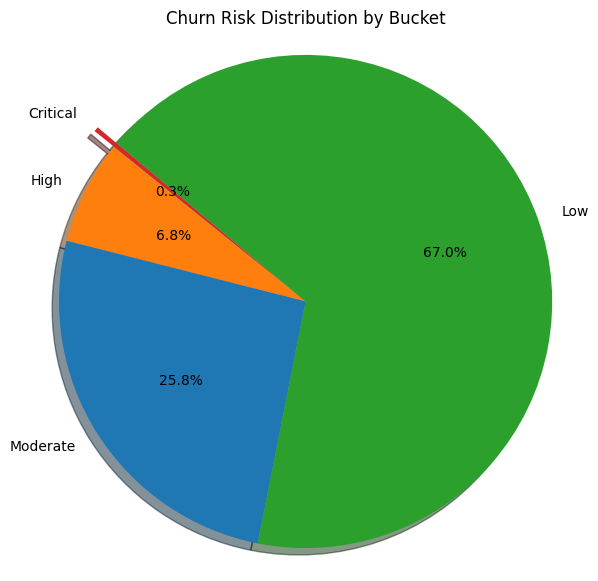

In [548]:
# Step 3: Count the number of accounts in each bucket
bucket_counts = df_active_risk_firms['churn_risk'].value_counts().reindex(['Critical', 'High', 'Moderate', 'Low'], fill_value=0)

# Step 4: Plot pie chart
colors = ['#D62728', '#FF7F0E', '#1F77B4', '#2CA02C']  # red, orange, blue, green
explode = [0.1 if b == 'Critical' else 0 for b in bucket_counts.index]  # explode Critical slice

plt.figure(figsize=(7, 7))
plt.pie(
    bucket_counts,
    labels=bucket_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title("Churn Risk Distribution by Bucket")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show() 


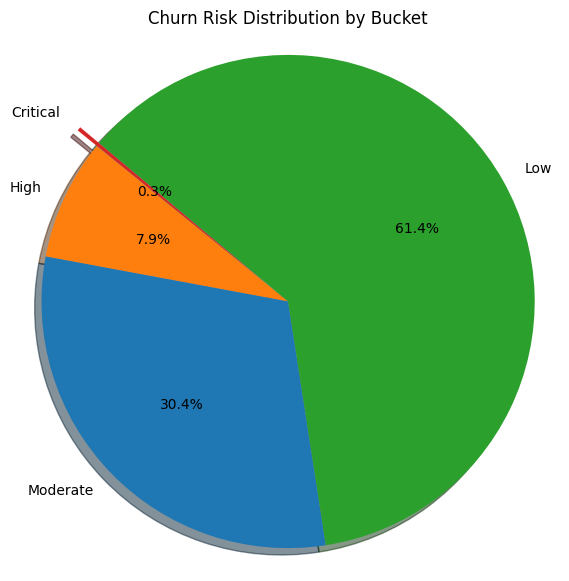

In [549]:
import matplotlib.pyplot as plt

# Step 1: Manually set the counts instead of pulling from df
bucket_counts = {
    'Critical': 4,
    'High': 123,
    'Moderate': 471,   # replace with your actual number
    'Low': 953         # replace with your actual number
}

# Step 2: Convert to a consistent order (optional)
labels = ['Critical', 'High', 'Moderate', 'Low']
values = [bucket_counts[label] for label in labels]

# Step 3: Plot pie chart
colors = ['#D62728', '#FF7F0E', '#1F77B4', '#2CA02C']  # red, orange, blue, green
explode = [0.1 if label == 'Critical' else 0 for label in labels]  # emphasize Critical

plt.figure(figsize=(7, 7))
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title("Churn Risk Distribution by Bucket")
plt.axis('equal')  # ensures pie is circular
plt.show()


# ML churn modelling

In [550]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.000000,0.000000,49.5,Moderate
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010,22.0,Low
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103,2.0,Low
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000,9.5,Low


In [551]:
df_risk_firms[df_risk_firms['firm_id'] == 42361]


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk


In [552]:
def categorize_training(detail):
    # Check if the detail is not a string
    if not isinstance(detail, str):
        return "No training details" if pd.isna(detail) else "others"
    
    detail_lower = detail.lower()
    
    if 'no training details' in detail_lower:
        return detail  # Keep 'No training details' as is
    elif 'foundational' in detail_lower and 'group guided' in detail_lower:
        return 'foundational n group guided'
    elif 'foundational' in detail_lower:
        return 'foundational'
    elif 'group guided' in detail_lower:
        return 'group guided'
    else:
        return 'others'

# Example of how to apply this function to a DataFrame column
# df_risk_firms['categorized_training'] = df_risk_firms['training_type_combined'].apply(categorize_training)


In [553]:
df_risk_firms['categorized_training'] = df_risk_firms['training_type_combined'].apply(categorize_training)


In [554]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk,categorized_training
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High,others
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.000000,0.000000,49.5,Moderate,others
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010,22.0,Low,foundational
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103,2.0,Low,foundational
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000,9.5,Low,others


In [555]:
df_risk_firms.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_churn_risk_Jan_2026.xlsx', index = False)


## Modelling

df_risk_firms = pd.read_excel('GFR_churn_risk.xlsx')

In [556]:
df_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk,categorized_training
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High,others
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.000000,0.000000,49.5,Moderate,others
4,661613,GoFileRoom FirmFlow (Workflow Manager) (includ...,1260,5,Active,The Miller Group LLC,0.0,Not Decreased Seats,0.0,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Onboarding, Enhanced Foundational Implementation",4993.0,1139.0,13717.0,495.0,-63.599913,130.101010,22.0,Low,foundational
6,57665,GoFileRoom FirmFlow (Workflow Manager) (includ...,2220,25,Active,Groskreutz Abraham Eshleman Gerretse LLC,0.0,Not Decreased Seats,0.0,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Custom Report/Statement, Foundational Imple...",6622.0,302.0,9867.0,390.0,-32.887402,-22.564103,2.0,Low,foundational
8,924,GoFileRoom,580,10,Active,"Charles E. Walton & Co., PC",0.0,Not Decreased Seats,0.0,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Essential Package, Essential...",4048.0,0.0,10200.0,0.0,-60.313725,0.000000,9.5,Low,others


# Model Training and Testing data

In [557]:
df_risk_firms.columns


Index(['firm_id', 'product_name', 'subscription_duration_days', 'seats',
       'status_flag', 'firm_name', 'seat_difference', 'seats_status',
       'seats_pct_change', 'firmflow_downgraded_status', 'escalated',
       'last_6_months_api', 'previous_6_months_api', 'api_6m_difference',
       'api_6m_percent_change', 'drop_api_flag', 'no_api_6m_flag',
       'training_type_combined', 'total_docs_added_last_6_months',
       'total_workflows_added_last_6_months',
       'total_docs_added_previous_6_months',
       'total_workflows_added_previous_6_months',
       'docs_added_pct_change_last_6_months',
       'workflows_added_pct_change_last_6_months', 'risk_percentage',
       'churn_risk', 'categorized_training'],
      dtype='object')

In [558]:
# Cancelled firms
cancelled_firms = df_risk_firms[df_risk_firms['status_flag'] == 'Cancelled']


In [ ]:
#active firms with low and moderate risk
active_low_moderate_risk_firms = df_risk_firms[
    (df_risk_firms['status_flag'] == 'Active') &
    (df_risk_firms['churn_risk'].isin(['Low', 'Moderate']))
]


In [560]:
# Combined data for modelling

df_model_data = pd.concat([cancelled_firms, active_low_moderate_risk_firms])


In [561]:
df_model_data.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_churn_train_test_data.xlsx', index = False)


In [562]:
df_model_data.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk,categorized_training
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.0,0.0,69.5,High,others
3,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0000,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,49.5,Moderate,others
19,403480,GoFileRoom,1146,20,Cancelled,Paramount Property Management,0.0,Not Decreased Seats,0.0000,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,29.5,Low,others
20,46777,GoFileRoom CS,1829,2,Cancelled,"Knudtson & Company CPAs, PA",-8.0,Decreased Seats,-80.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,89.5,Critical,others
56,47640,GoFileRoom FirmFlow (Workflow Manager) (includ...,6631,70,Cancelled,"CBIZ MHM, LLC",-15.0,Decreased Seats,-17.6471,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,79.5,High,others


In [563]:
df_model_data.reset_index(drop = True, inplace = True)


In [564]:
df_model_data.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk,categorized_training
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,"HLB Gross Collins, PC",0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Guided Implementation, Chan...",0.0,0.0,0.0,0.0,0.0,0.0,69.5,High,others
1,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,Thaney & Associates Cpa's PC,0.0,Not Decreased Seats,0.0000,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,49.5,Moderate,others
2,403480,GoFileRoom,1146,20,Cancelled,Paramount Property Management,0.0,Not Decreased Seats,0.0000,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,29.5,Low,others
3,46777,GoFileRoom CS,1829,2,Cancelled,"Knudtson & Company CPAs, PA",-8.0,Decreased Seats,-80.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,89.5,Critical,others
4,47640,GoFileRoom FirmFlow (Workflow Manager) (includ...,6631,70,Cancelled,"CBIZ MHM, LLC",-15.0,Decreased Seats,-17.6471,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,0.0,0.0,0.0,0.0,0.0,0.0,79.5,High,others


In [565]:
df_model_data.shape


(2203, 27)

In [566]:
columns_to_drop = [
'firm_name', 'training_type_combined', 'churn_risk', 'risk_percentage'
]

# Drop the columns
df_model = df_model_data.drop(columns=columns_to_drop)


In [567]:
df_model.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,categorized_training
0,29007,GoFileRoom FirmFlow (Workflow Manager) (includ...,2345,0,Cancelled,0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,0.0,0.0,0.0,0.0,0.0,0.0,others
1,44095,GoFileRoom FirmFlow (Workflow Manager) (includ...,425,25,Cancelled,0.0,Not Decreased Seats,0.0000,Not Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,0.0,0.0,0.0,0.0,0.0,0.0,others
2,403480,GoFileRoom,1146,20,Cancelled,0.0,Not Decreased Seats,0.0000,Not Applicable,N,0.0,0.0,0.0,0.0,no data,no data,0.0,0.0,0.0,0.0,0.0,0.0,others
3,46777,GoFileRoom CS,1829,2,Cancelled,-8.0,Decreased Seats,-80.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,0.0,0.0,0.0,0.0,0.0,0.0,others
4,47640,GoFileRoom FirmFlow (Workflow Manager) (includ...,6631,70,Cancelled,-15.0,Decreased Seats,-17.6471,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,0.0,0.0,0.0,0.0,0.0,0.0,others


# Encoding categorical columns

In [568]:
# Perform one-hot encoding`
df_model_encoded = pd.get_dummies(df_model, columns=['product_name', 'seats_status', 'firmflow_downgraded_status', 'escalated', 'drop_api_flag', 'no_api_6m_flag', 'categorized_training'])


In [569]:
df_model_encoded.head()


,firm_id,subscription_duration_days,seats,status_flag,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom CS,product_name_GoFileRoom CS FirmFlow,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,firmflow_downgraded_status_Not Applicable,firmflow_downgraded_status_Not Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_foundational n group guided,categorized_training_group guided,categorized_training_others
0,29007,2345,0,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,True,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True
1,44095,425,25,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True
2,403480,1146,20,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True
3,46777,1829,2,Cancelled,-8.0,-80.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True
4,47640,6631,70,Cancelled,-15.0,-17.6471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True


# Label encoding status column

In [570]:
from sklearn.preprocessing import LabelEncoder


In [571]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()


In [572]:
df_model_encoded['firm_status_encoded'] = label_encoder.fit_transform(df_model_encoded['status_flag'])


In [573]:
df_model_encoded.head()


,firm_id,subscription_duration_days,seats,status_flag,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom CS,product_name_GoFileRoom CS FirmFlow,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,firmflow_downgraded_status_Not Applicable,firmflow_downgraded_status_Not Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_foundational n group guided,categorized_training_group guided,categorized_training_others,firm_status_encoded
0,29007,2345,0,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,True,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,1
1,44095,425,25,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,False,True,1
2,403480,1146,20,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,1
3,46777,1829,2,Cancelled,-8.0,-80.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,1
4,47640,6631,70,Cancelled,-15.0,-17.6471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,1


In [574]:
df_model_encoded['firm_status_encoded'].unique()


array([1, 0])

In [575]:
df_model_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 38 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   firm_id                                                                    2203 non-null   object 
 1   subscription_duration_days                                                 2203 non-null   int64  
 2   seats                                                                      2203 non-null   int64  
 3   status_flag                                                                2203 non-null   object 
 4   seat_difference                                                            2203 non-null   float64
 5   seats_pct_change                                                           2203 non-null   float64
 6   last_6_months_api                                       

In [576]:
# converting bool columns to int
df_model_encoded[df_model_encoded.select_dtypes(include=[bool]).columns] = df_model_encoded.select_dtypes(include=[bool]).astype(int)


In [577]:
df_model_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 38 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   firm_id                                                                    2203 non-null   object 
 1   subscription_duration_days                                                 2203 non-null   int64  
 2   seats                                                                      2203 non-null   int64  
 3   status_flag                                                                2203 non-null   object 
 4   seat_difference                                                            2203 non-null   float64
 5   seats_pct_change                                                           2203 non-null   float64
 6   last_6_months_api                                       

In [578]:
df_model_encoded.head()


,firm_id,subscription_duration_days,seats,status_flag,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom CS,product_name_GoFileRoom CS FirmFlow,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,firmflow_downgraded_status_Not Applicable,firmflow_downgraded_status_Not Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_foundational n group guided,categorized_training_group guided,categorized_training_others,firm_status_encoded
0,29007,2345,0,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1
1,44095,425,25,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,1
2,403480,1146,20,Cancelled,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1
3,46777,1829,2,Cancelled,-8.0,-80.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1
4,47640,6631,70,Cancelled,-15.0,-17.6471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1


In [579]:
df_model_encoded.shape


(2203, 38)

In [580]:
# Dropping firm_id, status_flag

df = df_model_encoded.drop(['firm_id', 'status_flag'], axis = 1)


In [581]:
df.head()


,subscription_duration_days,seats,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom CS,product_name_GoFileRoom CS FirmFlow,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,firmflow_downgraded_status_Not Applicable,firmflow_downgraded_status_Not Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_foundational n group guided,categorized_training_group guided,categorized_training_others,firm_status_encoded
0,2345,0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1
1,425,25,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,1
2,1146,20,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1
3,1829,2,-8.0,-80.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1
4,6631,70,-15.0,-17.6471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1


In [582]:
df.isnull().sum()


subscription_duration_days                                                   0
seats                                                                        0
seat_difference                                                              0
seats_pct_change                                                             0
last_6_months_api                                                            0
previous_6_months_api                                                        0
api_6m_difference                                                            0
api_6m_percent_change                                                        0
total_docs_added_last_6_months                                               0
total_workflows_added_last_6_months                                          0
total_docs_added_previous_6_months                                           0
total_workflows_added_previous_6_months                                      0
docs_added_pct_change_last_6_months                 

In [583]:
df.shape


(2203, 36)

In [584]:
# Checking correlation with firm_status_encoded

plt.figure(figsize=(14,7))
df.corr()['firm_status_encoded'].sort_values(ascending = False)


firm_status_encoded                                                          1.000000
firmflow_downgraded_status_Downgraded                                        0.372549
product_name_GoFileRoom CS                                                   0.274113
categorized_training_others                                                  0.188424
product_name_GoFileRoom CS FirmFlow                                          0.186996
seats_status_Not Decreased Seats                                             0.131924
seat_difference                                                              0.058386
product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses)    0.048069
no_api_6m_flag_no data                                                       0.040514
drop_api_flag_no data                                                        0.040514
escalated_N                                                                  0.023372
api_6m_percent_change                                 

<Figure size 1400x700 with 0 Axes>

In [585]:
# Extract columns with dtype as int and calculate correlation
int_columns_corr = df.select_dtypes(include=['int64', 'int32', 'float32', 'float64']).corr()

# Set a threshold for high correlation
threshold = 0.8

# Find pairs of highly correlated columns
highly_correlated = []
for i in range(len(int_columns_corr.columns)):
    for j in range(i):
        if abs(int_columns_corr.iloc[i, j]) > threshold:
            colname = int_columns_corr.columns[i]
            rowname = int_columns_corr.index[j]
            correlation = int_columns_corr.iloc[i, j] * 100  # Convert to percentage
            highly_correlated.append((rowname, colname, correlation))

# Convert to DataFrame for better readability
highly_correlated_df = pd.DataFrame(highly_correlated, columns=['Column 1', 'Column 2', 'Correlation Percentage'])
highly_correlated_df


,Column 1,Column 2,Correlation Percentage
0,last_6_months_api,previous_6_months_api,93.018194
1,last_6_months_api,api_6m_difference,81.698169
2,product_name_GoFileRoom,product_name_GoFileRoom FirmFlow (Workflow Man...,-88.699194
3,seats_status_Decreased Seats,seats_status_Not Decreased Seats,-100.000000
4,escalated_N,escalated_Y,-100.000000
5,drop_api_flag_OK,drop_api_flag_no data,-92.075606
6,drop_api_flag_OK,no_api_6m_flag_OK,93.780876
7,drop_api_flag_no data,no_api_6m_flag_OK,-98.181644
8,drop_api_flag_OK,no_api_6m_flag_no data,-92.075606
9,drop_api_flag_no data,no_api_6m_flag_no data,100.000000


# Splitting Data into Training and Testing

In [586]:
# Putting feature variable to X
X = df.drop(['firm_status_encoded'], axis = 1)

# Putting response/target variable to y
y = df['firm_status_encoded']


In [587]:
df['firm_status_encoded'].value_counts()


firm_status_encoded
0    1480
1     723
Name: count, dtype: int64

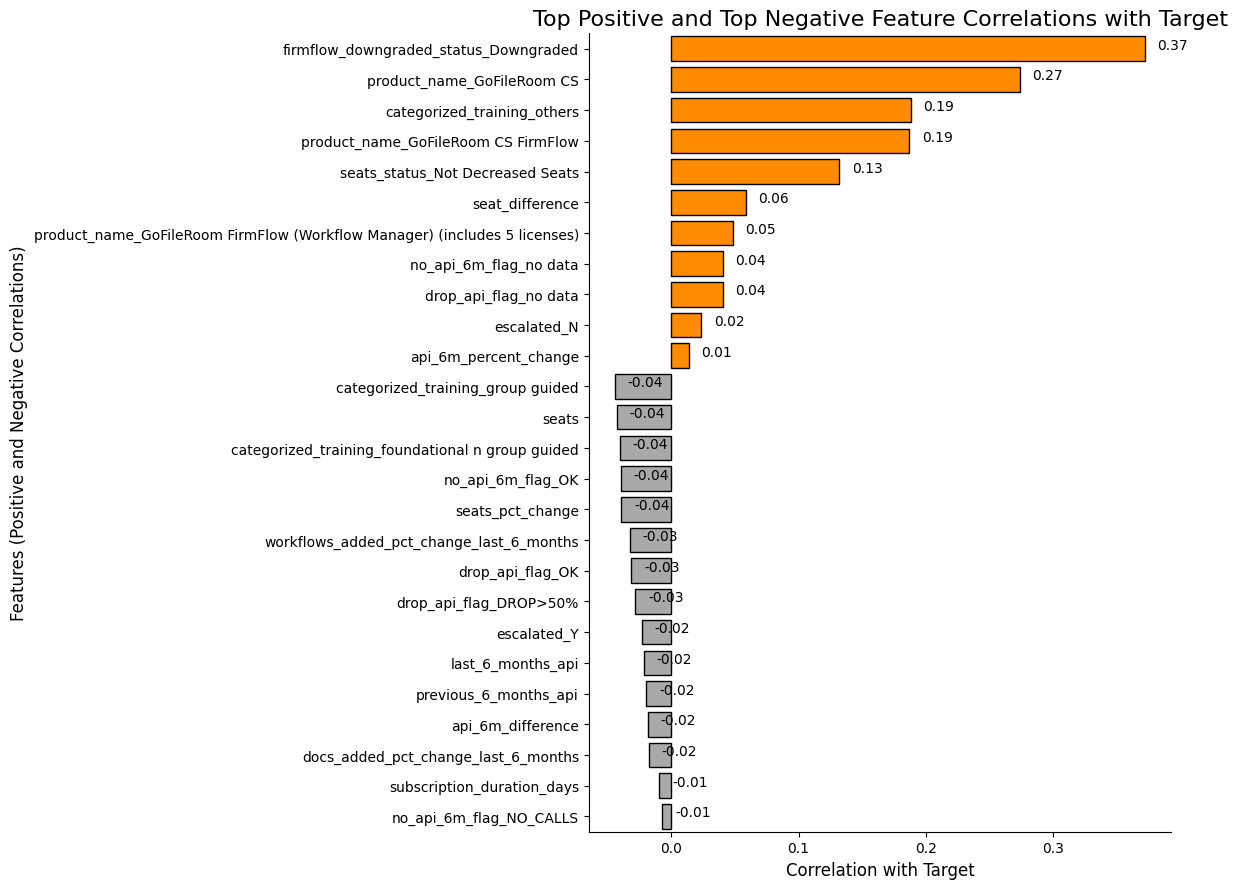

In [588]:
# Calculate the correlation between features and target variable
correlation_with_target = X.corrwith(y)

# Separate positive and negative correlations
positive_features = correlation_with_target[correlation_with_target > 0].sort_values(ascending=False)
negative_features = correlation_with_target[correlation_with_target <= 0].sort_values()

# Select the top 15 positive and negative correlations
top_positive_features = positive_features.head(15)
top_negative_features = negative_features.tail(15)

# Concatenate the positive and negative features
top_features = pd.concat([top_positive_features, top_negative_features])

# Create the index for the bar plot
index = np.arange(len(top_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot for top positive and negative correlations
feature_bar = ax.barh(index, top_features.values, color=['darkorange' if x > 0 else 'darkgrey' for x in top_features.values], edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_features.index)

# Add a gap between last positive and first negative correlation
ax.set_ylim([-0.5, len(top_features)-0.5])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_features.values):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add title and labels to the plot
plt.title("Top Positive and Top Negative Feature Correlations with Target", fontsize=16)
plt.xlabel("Correlation with Target", fontsize=12)
plt.ylabel("Features (Positive and Negative Correlations)", fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [589]:
# Machine learning libraries and functions:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, make_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.utils import class_weight

import statsmodels.api as sm

# Explainibility:

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import xgboost as xgb

from skopt import BayesSearchCV


In [590]:
# Splitting the data into train and test: 80-20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state= 42)


In [591]:
def plot_confusion_matrix(y_test, pred_test):
    cm = confusion_matrix(y_test, pred_test)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Set2)
    classNames = ['Active-Subscription','Lapsed-Subscription']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
  
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=12)
    plt.show()


# Random Forest - Bayesian Optimization - scoring on ROC-AUC

In [592]:
# Base RF model
rfc = RandomForestClassifier(random_state=42)


In [593]:
# Define the search space for hyperparameters
param_space = { 
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 200],
    'max_features': [20, 30, 40, 50, 60], 
    'max_depth' : [None, 5, 10, 20, 30, 40, 50, 60],
    'criterion' :['gini', 'entropy']
}


In [594]:
# ==========================================
# 1. DATA HANDLING & MATH
# ==========================================
import pandas as pd             # Dataframes
import numpy as np              # Numerical arrays
import matplotlib.pyplot as plt # Visualization
import seaborn as sns           # Advanced visualization

# ==========================================
# 2. PREPROCESSING & SPLITTING (The "X_train" stuff)
# ==========================================
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ==========================================
# 3. CLASSICAL ML MODELS (Scikit-Learn)
# ==========================================
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier

# ==========================================
# 4. ADVANCED BOOSTING MODELS
# ==========================================
import xgboost as xgb           # XGBoost
import lightgbm as lgb          


# ==========================================
# 6. EVALUATION METRICS
# ==========================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# ==========================================
# 7. MLOPS & UTILITIES
# ==========================================
import joblib                   # Saving/Loading models
import warnings
warnings.filterwarnings('ignore') # Keeps the output clean


In [595]:
%%time
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

# Create the BayesSearchCV object
bayes_rfc = BayesSearchCV(
    estimator=rfc,
    search_spaces=param_space,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_rfc.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_rfc.best_params_
best_score = bayes_rfc.best_score_

print("Best parameters:", best_params)
print("Best ROC AUC score:", best_score)


Best parameters: OrderedDict({'criterion': 'entropy', 'max_depth': 10, 'max_features': 20, 'n_estimators': 100})
Best ROC AUC score: 0.9807703761338029
CPU times: total: 2min 23s
Wall time: 4min 16s


In [596]:
# Get the best estimator from the BayesSearchCV object
best_estimator_rfc = bayes_rfc.best_estimator_

# Evaluating on Training set
y_pred_train = best_estimator_rfc.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1196
           1       0.98      0.98      0.98       566

    accuracy                           0.98      1762
   macro avg       0.98      0.98      0.98      1762
weighted avg       0.98      0.98      0.98      1762

Train Accuracy: 0.9841089670828603


In [597]:
print(confusion_matrix(y_train, y_pred_train))


[[1182   14]
 [  14  552]]


In [598]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_rfc.predict_proba(X_test)[:, 1]


In [599]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


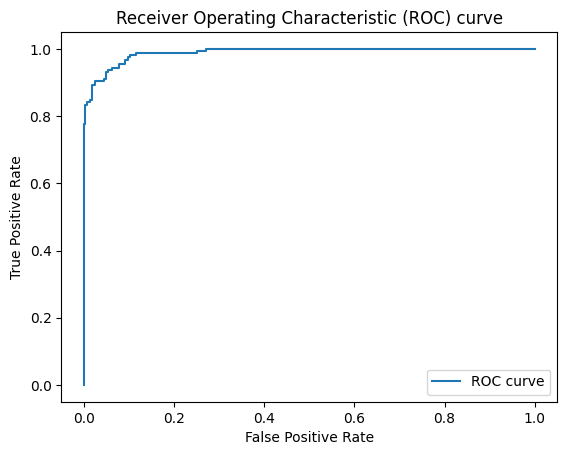

In [600]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [601]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9891002063335426


In [602]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.4899119624946194


In [603]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [604]:
# Evaluating on Test set
#y_pred_test = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       284
           1       0.91      0.94      0.92       157

    accuracy                           0.94       441
   macro avg       0.94      0.94      0.94       441
weighted avg       0.94      0.94      0.94       441

Test Accuracy: 0.94


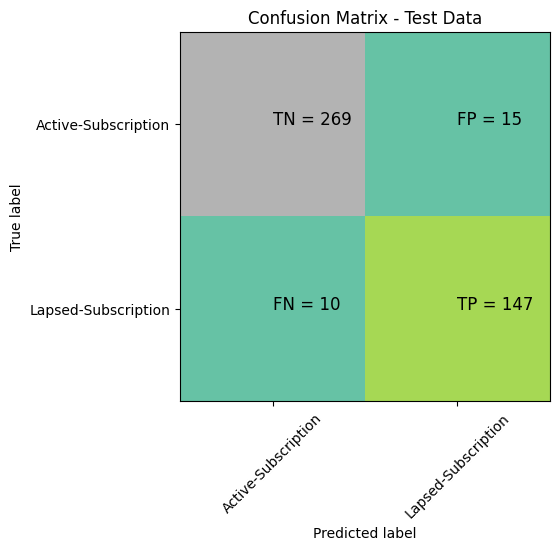

In [605]:
plot_confusion_matrix(y_test, y_pred_optimal)


RF roc_value: 0.9417444155378129
RF threshold: 1.0
ROC for the test dataset 94.2%


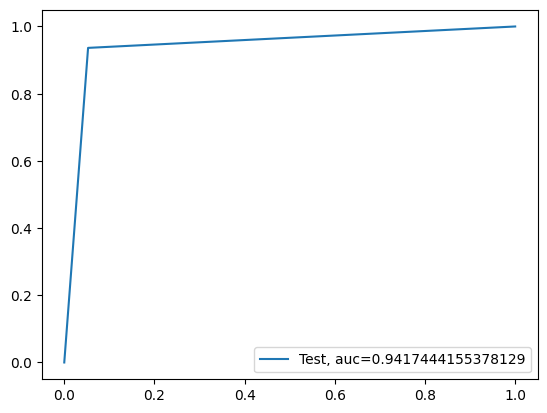

In [606]:
l2_roc_value = roc_auc_score(y_test, y_pred_optimal)
print("RF roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("RF threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


# Features importance - Top 30 Random Forest Classifier

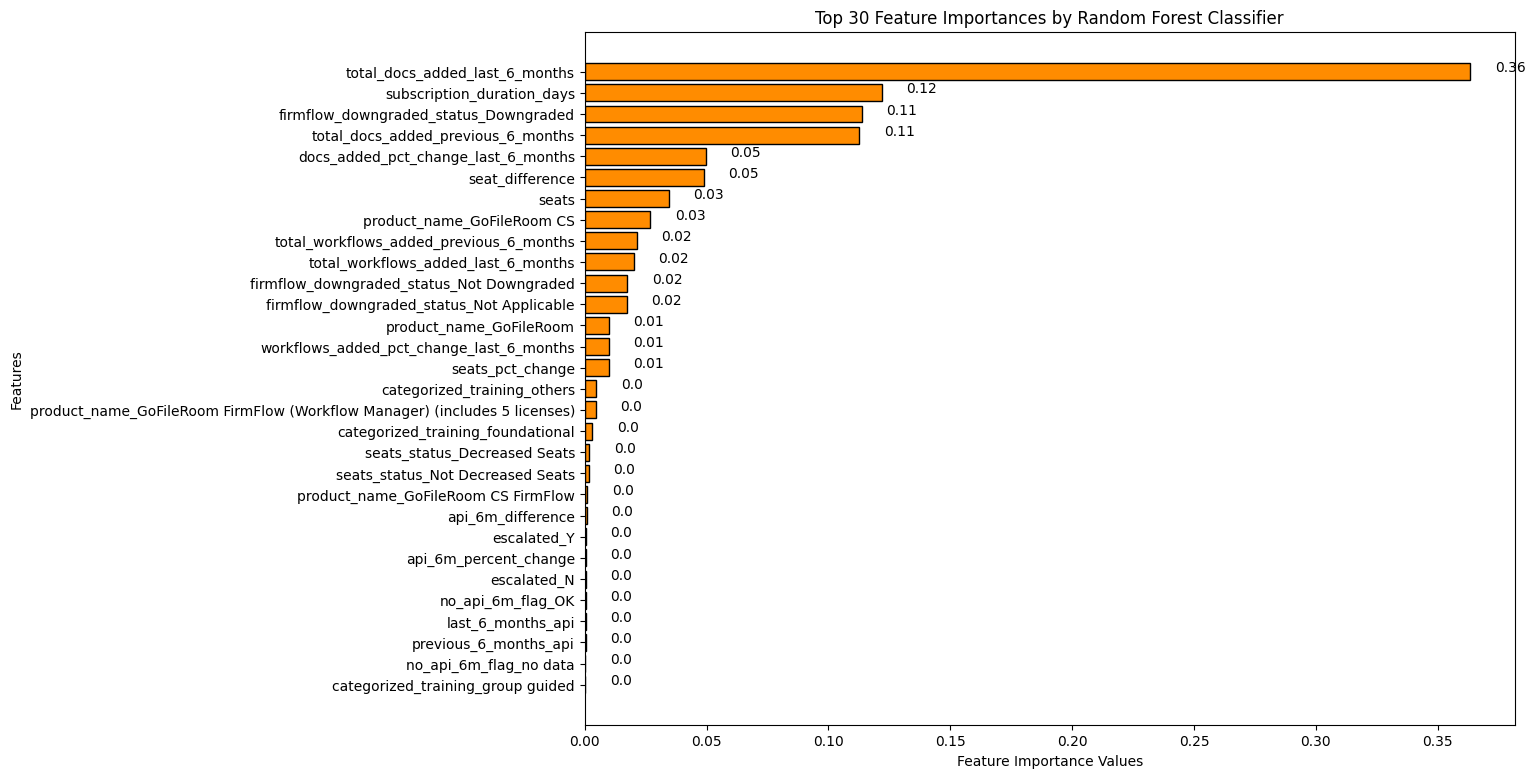

In [607]:
# Get the feature importances from the random forest classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_rfc.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by Random Forest Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()


## Random Forest classifier - Bayesian optimization - scoring on recall

In [608]:
# Base RF model:
rfc = RandomForestClassifier(random_state = 42)


In [609]:
# Define the search space for hyperparameters
param_space = { 
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 200],
    'max_features': [20, 30, 40, 50, 60], 
    'max_depth' : [None, 5, 10, 20, 30, 40, 50, 60],
    'criterion' :['gini', 'entropy']
}


In [610]:
%%time
# Create the BayesSearchCV object
bayes_rfc_recall = BayesSearchCV(
    estimator=rfc,
    search_spaces=param_space,
    scoring='recall',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_rfc_recall.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_rfc_recall.best_params_
best_score = bayes_rfc_recall.best_score_

print("Best parameters:", best_params)
print("Best recall score:", best_score)


Best parameters: OrderedDict({'criterion': 'entropy', 'max_depth': 10, 'max_features': 50, 'n_estimators': 20})
Best recall score: 0.8851731097655643
CPU times: total: 2min 39s
Wall time: 3min 49s


In [611]:
# Get the best estimator from the BayesSearchCV object
best_estimator_rfc_recall = bayes_rfc_recall.best_estimator_

# Evaluating on Training set
y_pred_train = best_estimator_rfc_recall.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1196
           1       0.96      0.97      0.97       566

    accuracy                           0.98      1762
   macro avg       0.98      0.98      0.98      1762
weighted avg       0.98      0.98      0.98      1762

Train Accuracy: 0.9790011350737798


In [612]:
print(confusion_matrix(y_train, y_pred_train))


[[1176   20]
 [  17  549]]


In [613]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_rfc_recall.predict_proba(X_test)[:, 1]


In [614]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


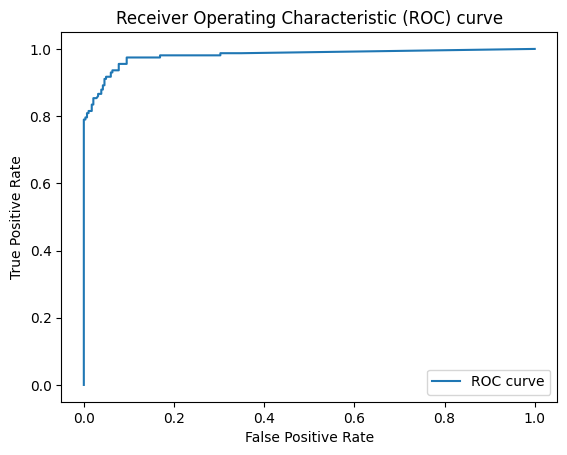

In [615]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [616]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9804095272270565


In [617]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.30521238459891703


In [618]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [619]:
# Evaluating on Test set
#y_pred_test = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.98      0.90      0.94       284
           1       0.85      0.97      0.91       157

    accuracy                           0.93       441
   macro avg       0.92      0.94      0.93       441
weighted avg       0.94      0.93      0.93       441

Test Accuracy: 0.93


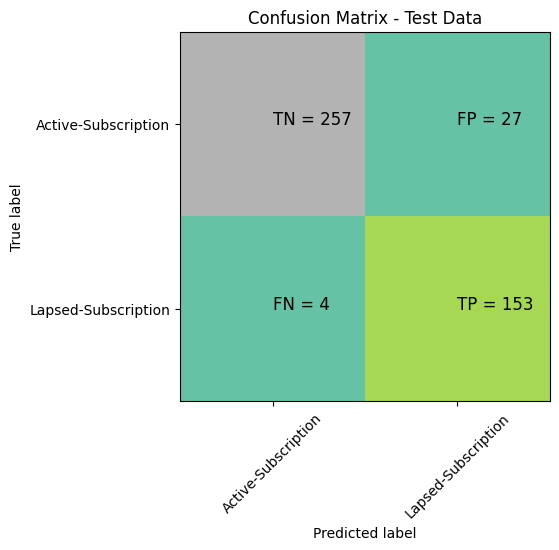

In [620]:
plot_confusion_matrix(y_test, y_pred_optimal)


RF roc_value: 0.9397259352292097
RF threshold: 1.0
ROC for the test dataset 94.0%


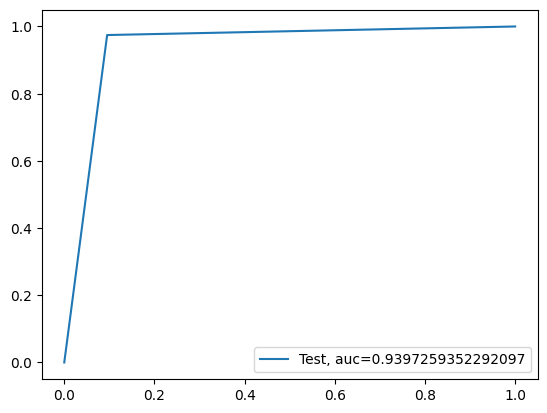

In [621]:
l2_roc_value = roc_auc_score(y_test, y_pred_optimal)
print("RF roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("RF threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


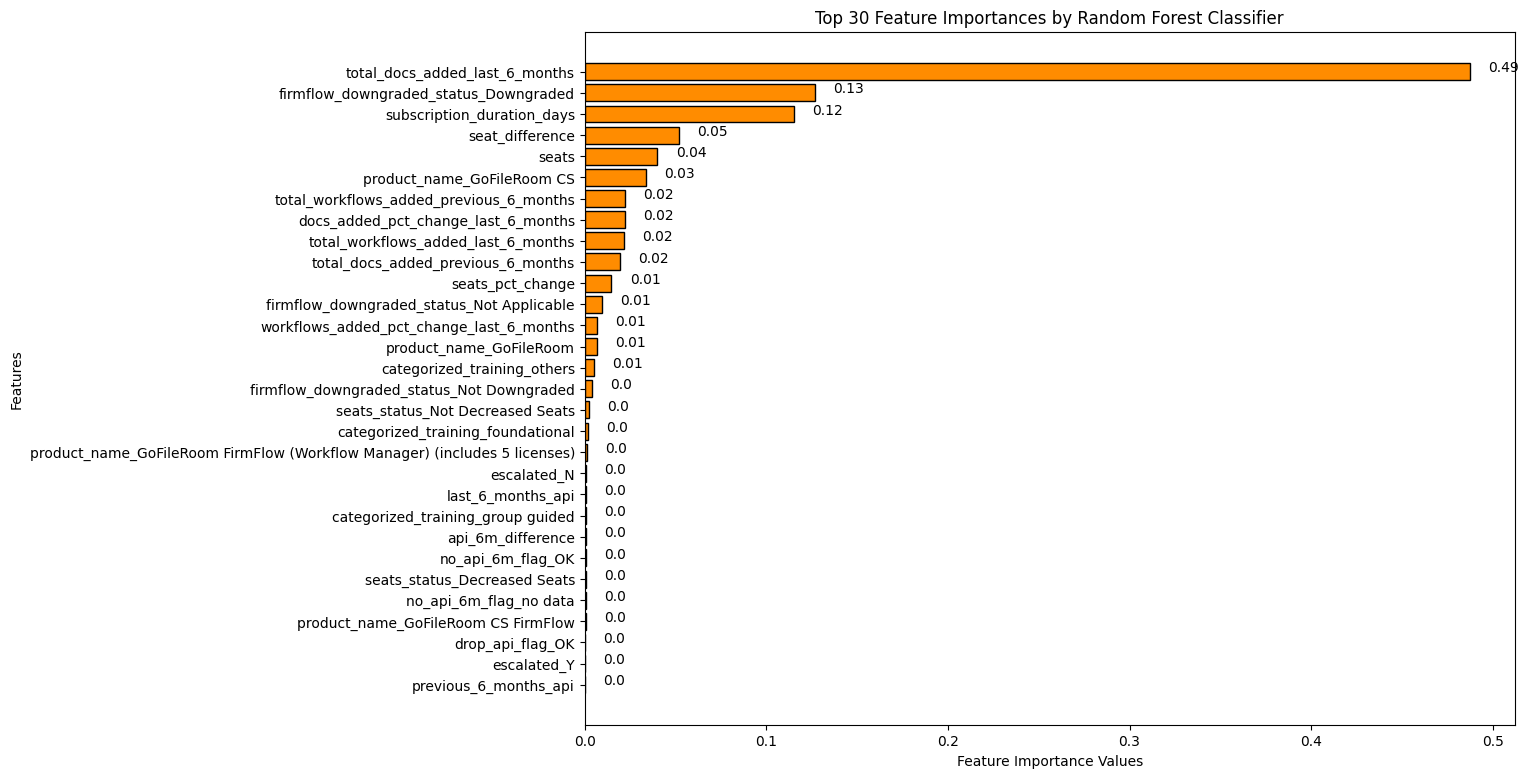

In [622]:
# Get the feature importances from the random forest classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_rfc_recall.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by Random Forest Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()


## Random Forest classifier - Bayesian optimization - scoring on precision

In [623]:
# Base RF model:
rfc = RandomForestClassifier(random_state = 42)


In [624]:
# Define the search space for hyperparameters
param_space = { 
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 200],
    'max_features': [20, 30, 40, 50, 60], 
    'max_depth' : [None, 5, 10, 20, 30, 40, 50, 60],
    'criterion' :['gini', 'entropy']
}


In [625]:
%%time
# Create the BayesSearchCV object
bayes_rfc_precision = BayesSearchCV(
    estimator=rfc,
    search_spaces=param_space,
    scoring='precision',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_rfc_precision.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_rfc_precision.best_params_
best_score = bayes_rfc_precision.best_score_

print("Best parameters:", best_params)
print("Best precision score:", best_score)


Best parameters: OrderedDict({'criterion': 'entropy', 'max_depth': 5, 'max_features': 20, 'n_estimators': 100})
Best precision score: 0.9401535154395566
CPU times: total: 2min 38s
Wall time: 3min 49s


In [626]:
# Get the best estimator from the BayesSearchCV object
best_estimator_rfc_precision = bayes_rfc_precision.best_estimator_

# Evaluating on Training set
y_pred_train = best_estimator_rfc_precision.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1196
           1       0.94      0.88      0.91       566

    accuracy                           0.94      1762
   macro avg       0.94      0.93      0.93      1762
weighted avg       0.94      0.94      0.94      1762

Train Accuracy: 0.9432463110102156


In [627]:
print(confusion_matrix(y_train, y_pred_train))


[[1164   32]
 [  68  498]]


In [628]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_rfc_precision.predict_proba(X_test)[:, 1]


In [629]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


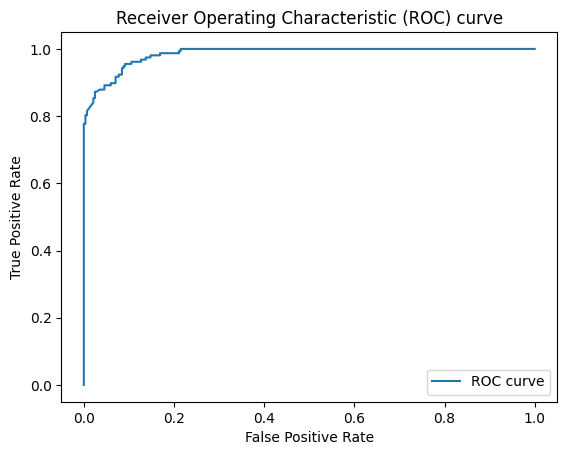

In [630]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [631]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9858706378397775


In [632]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.3343753061193656


In [633]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [634]:
# Evaluating on Test set
#y_pred_test = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.97      0.91      0.94       284
           1       0.85      0.96      0.90       157

    accuracy                           0.93       441
   macro avg       0.91      0.93      0.92       441
weighted avg       0.93      0.93      0.93       441

Test Accuracy: 0.93


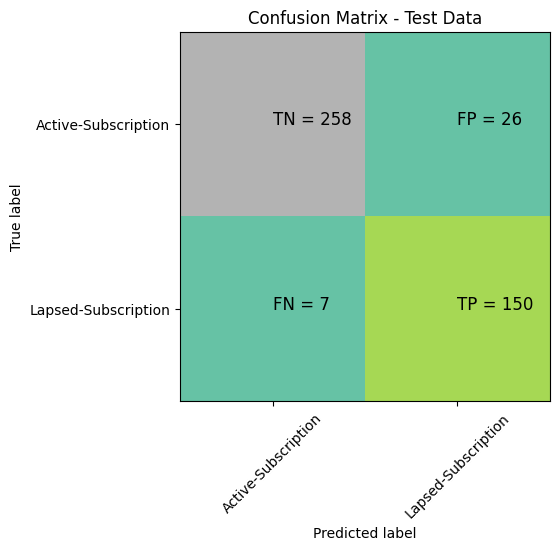

In [635]:
plot_confusion_matrix(y_test, y_pred_optimal)


RF roc_value: 0.9319323584821029
RF threshold: 1.0
ROC for the test dataset 93.2%


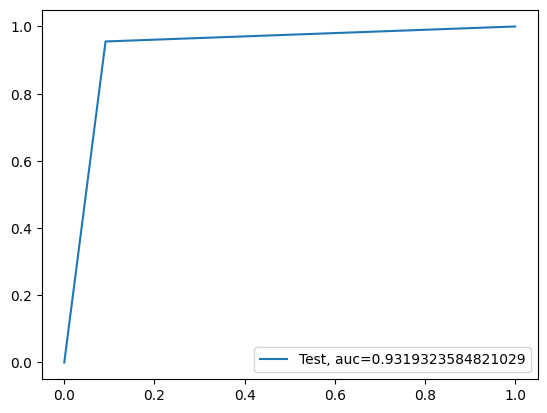

In [636]:
l2_roc_value = roc_auc_score(y_test, y_pred_optimal)
print("RF roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("RF threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


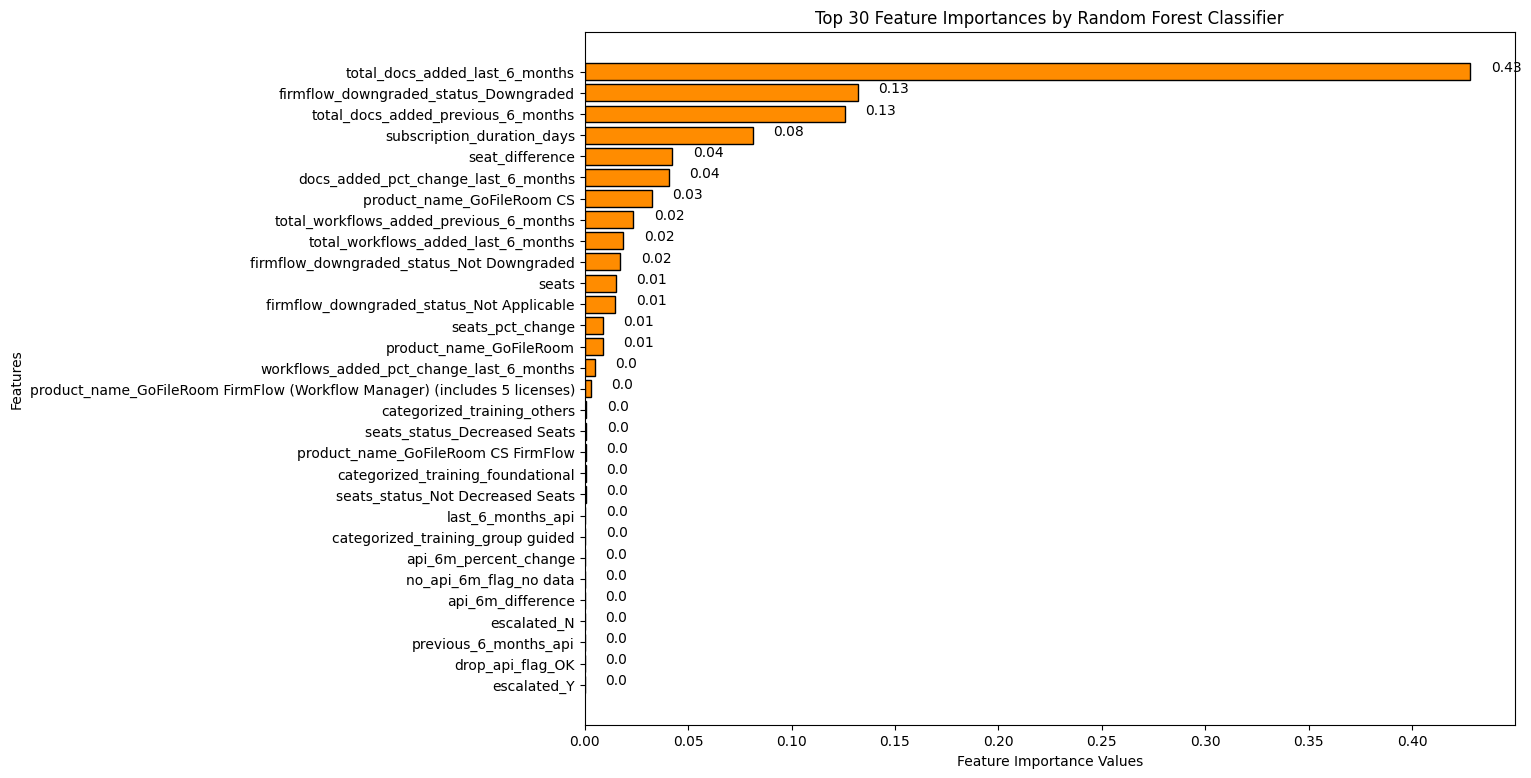

In [637]:
# Get the feature importances from the random forest classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_rfc_precision.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by Random Forest Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()


## Logistic Regression - Bayesian optimization

In [638]:
from sklearn.linear_model import LogisticRegression


In [639]:
param_space = {
    'C' : (1e-6, 1e+6, 'log-uniform'),
    'solver' : ['liblinear', 'saga'],
    'penalty' : ['l1', 'l2'],
    #'max_iter': (50, 500)                 # Number of iterations
}


In [640]:
log_reg = LogisticRegression(random_state = 42)


In [641]:
bayes_log = BayesSearchCV(
estimator = log_reg,
search_spaces = param_space,
n_iter=50,
cv=5,
random_state=42,
n_jobs=-1)

bayes_log.fit(X_train, y_train)


BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
              random_state=42,
              search_spaces={'C': (1e-06, 1000000.0, 'log-uniform'),
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga']})

In [642]:
# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_log.best_params_
best_score = bayes_log.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)


Best parameters: OrderedDict({'C': 1000000.0, 'penalty': 'l1', 'solver': 'liblinear'})
Best score: 0.8706138938964717


In [643]:
# Get the best estimator from the BayesSearchCV object
best_estimator_log = bayes_log.best_estimator_

# Evaluating on Training set
y_pred_train = best_estimator_log.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)


              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1196
           1       0.91      0.68      0.77       566

    accuracy                           0.87      1762
   macro avg       0.88      0.82      0.84      1762
weighted avg       0.88      0.87      0.87      1762

Train Accuracy: 0.873439273552781


In [644]:
print(confusion_matrix(y_train, y_pred_train))


[[1156   40]
 [ 183  383]]


In [645]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_log.predict_proba(X_test)[:, 1]


In [646]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


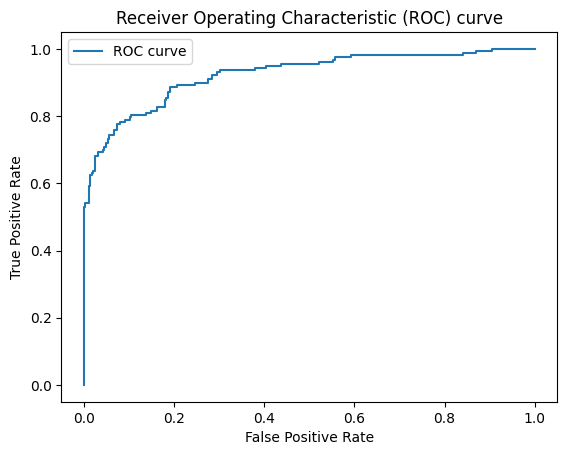

In [647]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [648]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.41756782496124606


In [649]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9230510451242488


In [650]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [651]:
# Evaluating on Test set
print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       284
           1       0.85      0.78      0.81       157

    accuracy                           0.87       441
   macro avg       0.87      0.85      0.86       441
weighted avg       0.87      0.87      0.87       441

Test Accuracy: 0.87


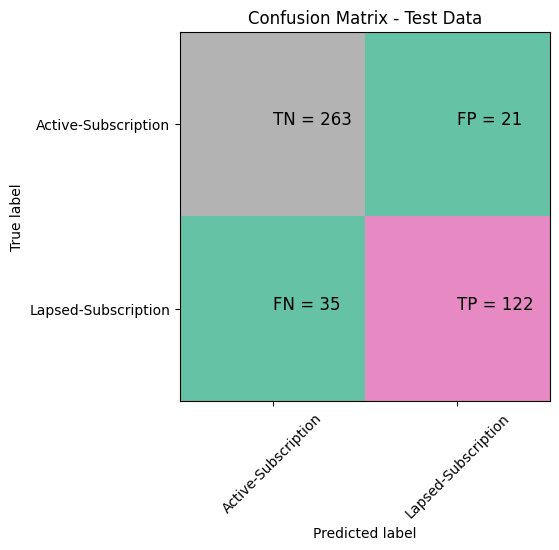

In [652]:
plot_confusion_matrix(y_test, y_pred_optimal)


RF roc_value: 0.8515632008612183
RF threshold: 1.0
ROC for the test dataset 85.2%


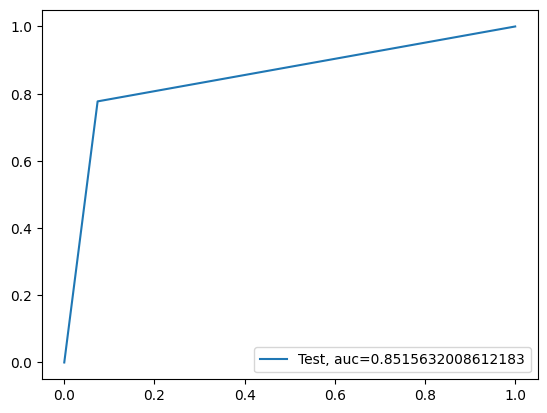

In [653]:
l2_roc_value = roc_auc_score(y_test, y_pred_optimal)
print("RF roc_value: {0}" .format(l2_roc_value))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("RF threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


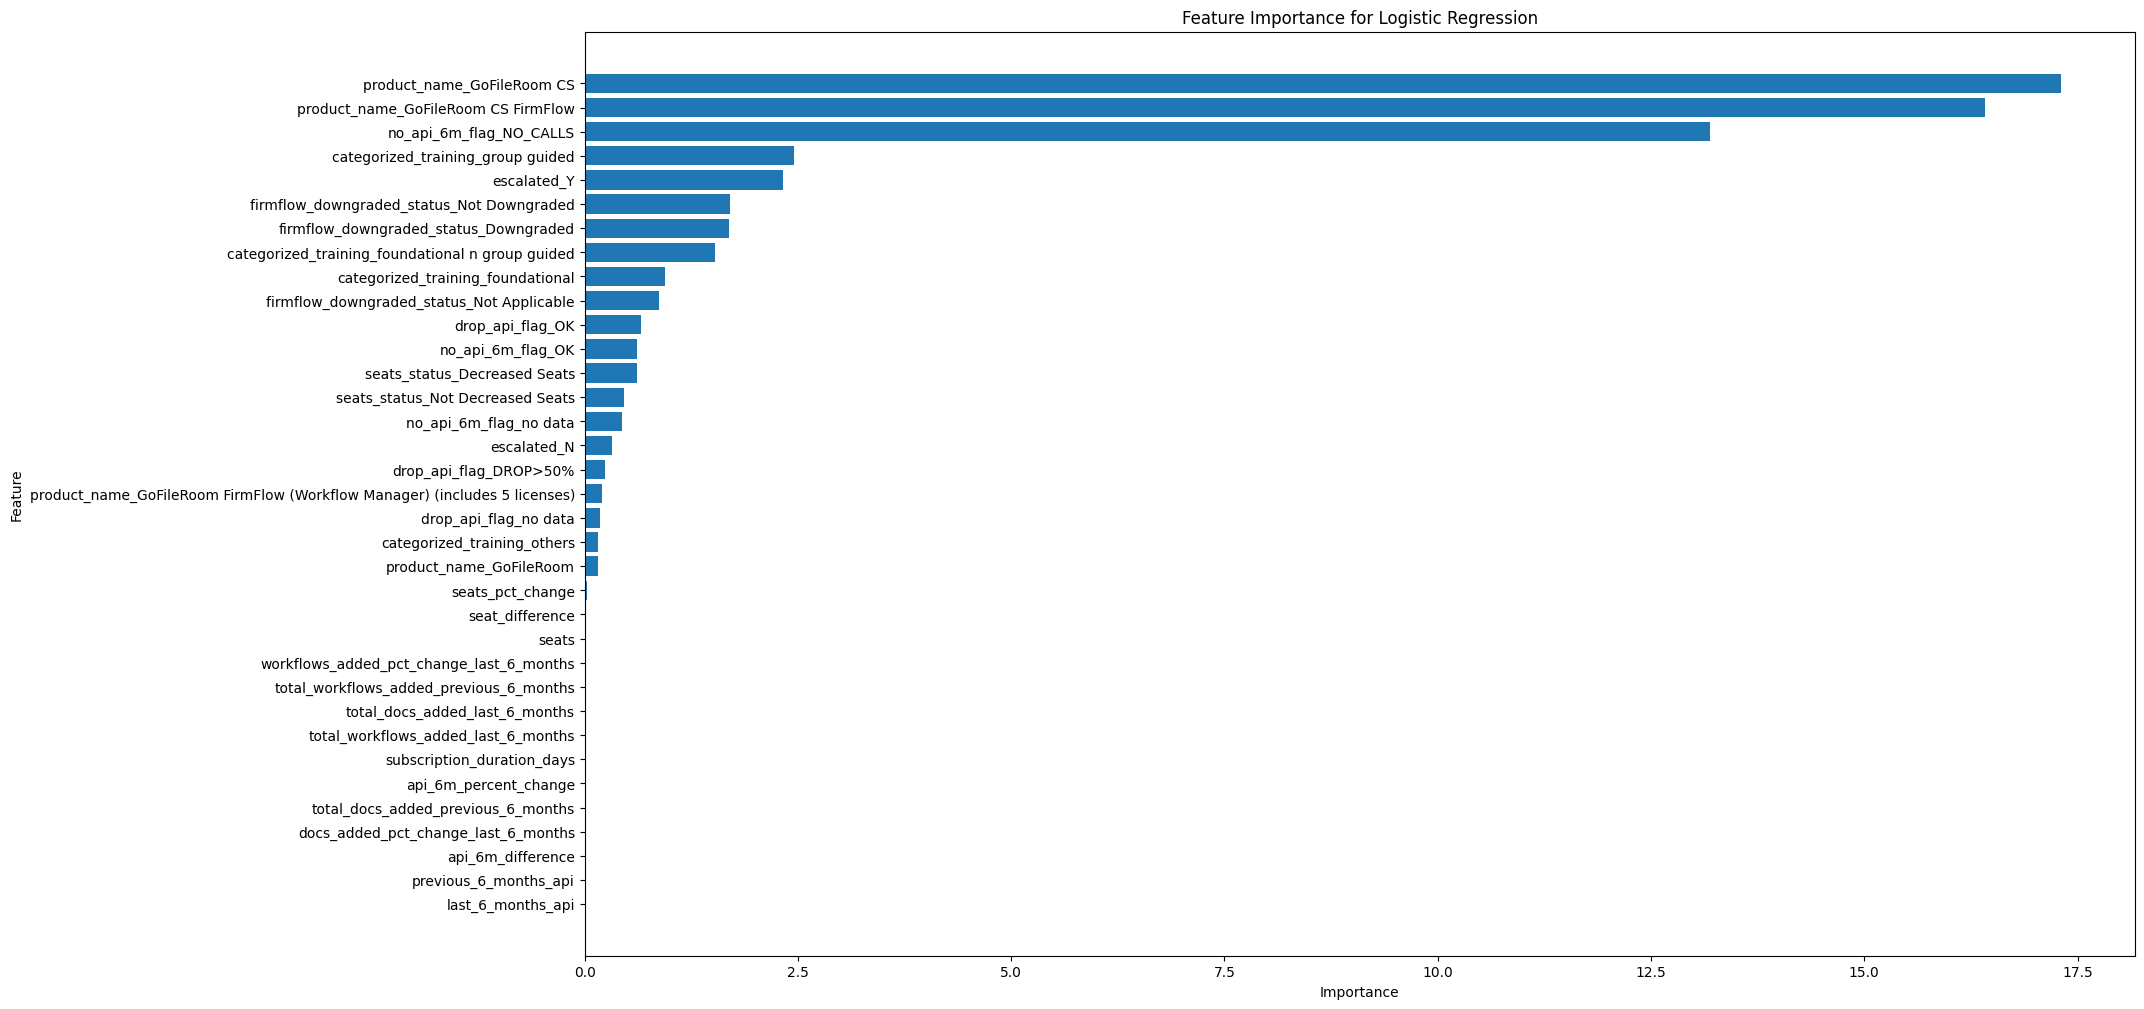

In [654]:
# Get the coefficients of the logistic regression model
coefficients = best_estimator_log.coef_[0]

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coefficients)
})

# Sort the DataFrame by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(20, 12))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()


## XGBoost - Bayesian optimization - scoring on ROC-AUC

In [655]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier


In [656]:
# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)


In [657]:
# Define the search space for hyperparameters
param_space = {
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 180, 200],
    'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
}

# Create the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=param_space,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_cv.fit(X_train, y_train)


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      feature_weights=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=No...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
                             'learning_rate': [0.01, 0.1, 0.2, 0.3],
                             'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100,
                                           120, 140, 160],
                             'n_estimators': [5, 10, 20, 50, 80, 100, 120, 150,
                                              180, 200],
                             'subsample': [0.5, 0.7, 0.8, 1.0]})

In [658]:
# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_

print("Best parameters:", best_params)
print("Best auc score:", best_score)


Best parameters: OrderedDict({'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 160, 'n_estimators': 50, 'subsample': 0.8})
Best auc score: 0.9788450979895401


In [659]:
# Get the best estimator from the BayesSearchCV object
best_estimator_xgboost = bayes_cv.best_estimator_

# Evaluating on Training set`
y_pred_train = best_estimator_xgboost.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

print(confusion_matrix(y_train, y_pred_train))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1196
           1       0.99      0.98      0.99       566

    accuracy                           0.99      1762
   macro avg       0.99      0.99      0.99      1762
weighted avg       0.99      0.99      0.99      1762

Train Accuracy: 0.9914869466515324
[[1190    6]
 [   9  557]]


In [660]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_xgboost.predict_proba(X_test)[:, 1]


In [661]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


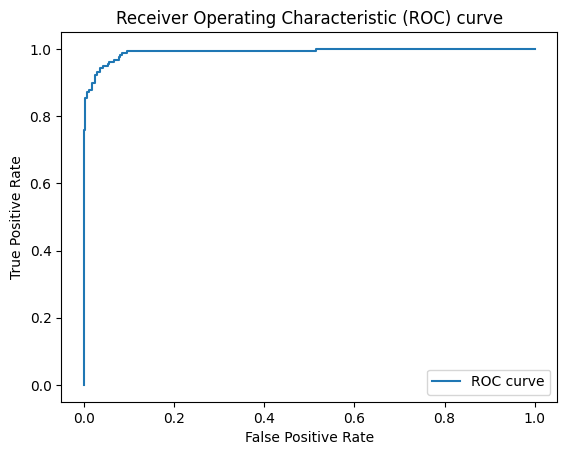

In [662]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [663]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9910514039651924


In [664]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.51386636


In [665]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [666]:
# Evaluating on Test set

print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       284
           1       0.94      0.94      0.94       157

    accuracy                           0.96       441
   macro avg       0.95      0.95      0.95       441
weighted avg       0.96      0.96      0.96       441

Test Accuracy: 0.96


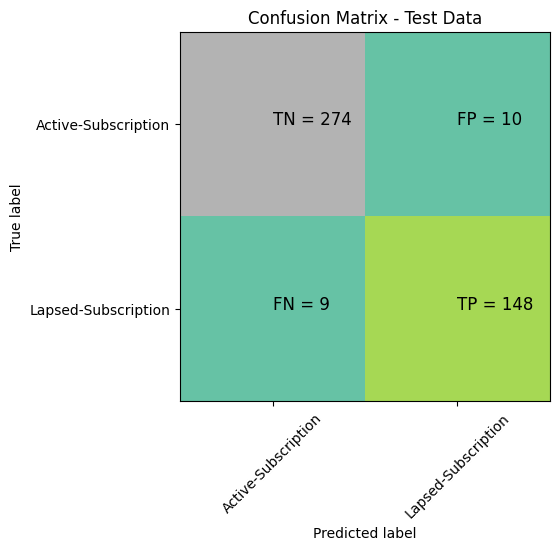

In [667]:
plot_confusion_matrix(y_test, y_pred_optimal)


XGBoost roc_value: 0.95
XGBoost threshold: 1.0
ROC for the test dataset 95.4%


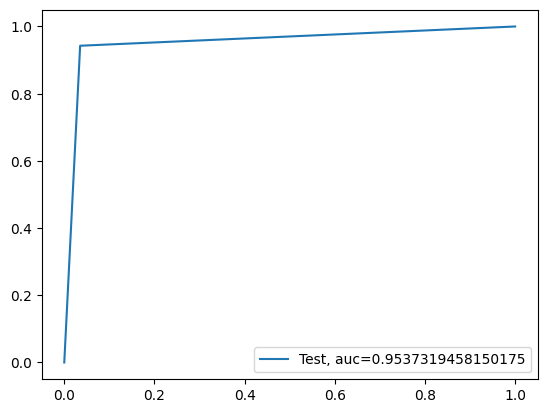

In [668]:
l2_roc_value = round(roc_auc_score(y_test, y_pred_optimal),2)
print("XGBoost roc_value: {0}".format(l2_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


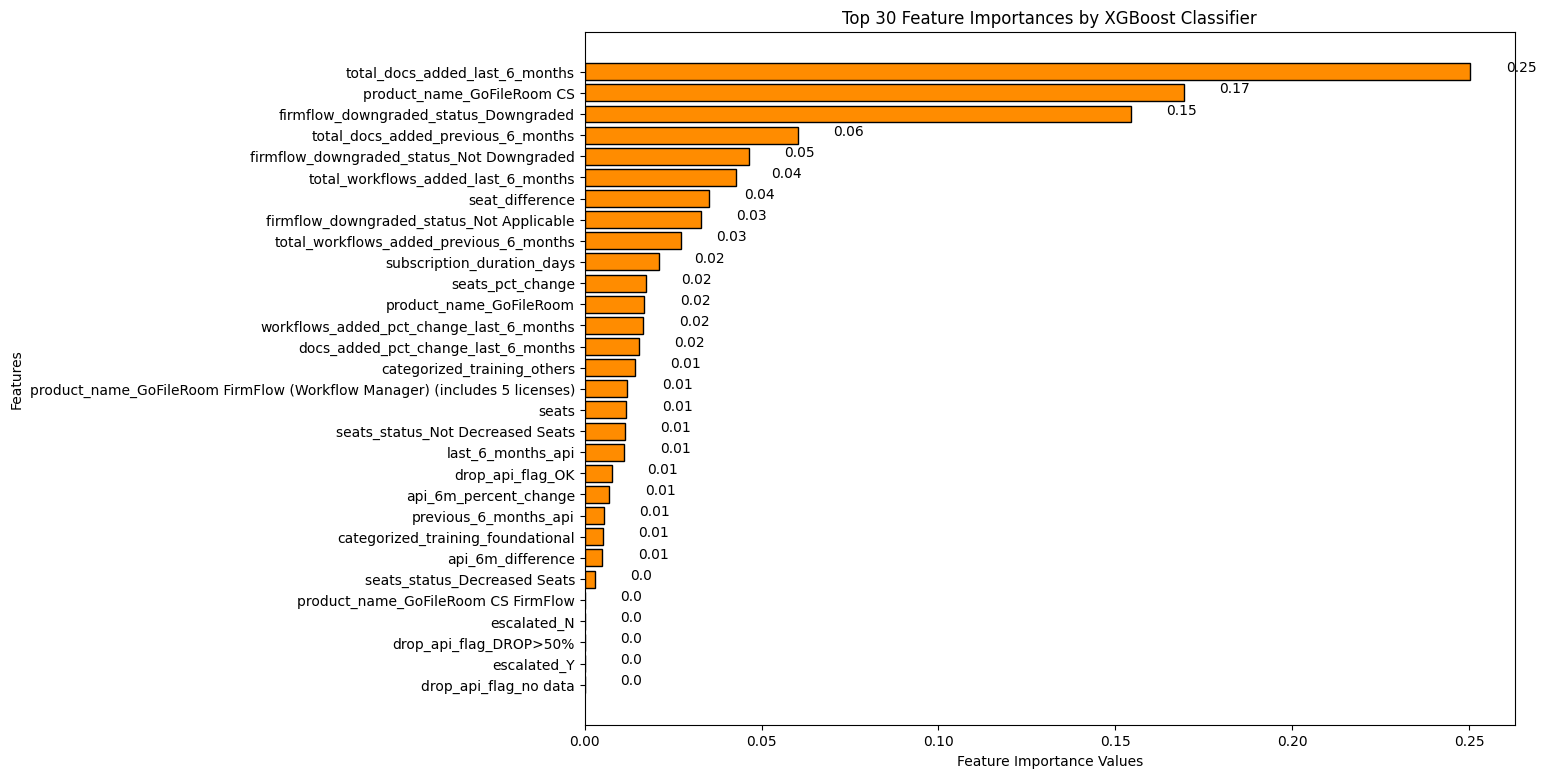

In [669]:
# Get the feature importances from the XGBoost classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_xgboost.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by XGBoost Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()


## XGBoost - Bayesian optimization - scoring on Recall

In [670]:
# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)


In [671]:
# Define the search space for hyperparameters
param_space = {
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 180, 200],
    'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
}

# Create the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=param_space,
    scoring='recall',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_cv.fit(X_train, y_train)


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      feature_weights=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=No...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='recall',
              search_spaces={'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
                             'learning_rate': [0.01, 0.1, 0.2, 0.3],
                             'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100,
                                           120, 140, 160],
                             'n_estimators': [5, 10, 20, 50, 80, 100, 120, 150,
                                              180, 200],
                             'subsample': [0.5, 0.7, 0.8, 1.0]})

In [672]:
# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_

print("Best parameters:", best_params)
print("Best recall score:", best_score)


Best parameters: OrderedDict({'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5})
Best recall score: 0.8869430212699891


In [673]:
# Get the best estimator from the BayesSearchCV object
best_estimator_xgboost_recall = bayes_cv.best_estimator_

# Evaluating on Training set`
y_pred_train = best_estimator_xgboost_recall.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

print(confusion_matrix(y_train, y_pred_train))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1196
           1       0.98      0.97      0.97       566

    accuracy                           0.98      1762
   macro avg       0.98      0.98      0.98      1762
weighted avg       0.98      0.98      0.98      1762

Train Accuracy: 0.9824063564131669
[[1182   14]
 [  17  549]]


In [674]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_xgboost_recall.predict_proba(X_test)[:, 1]


In [675]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


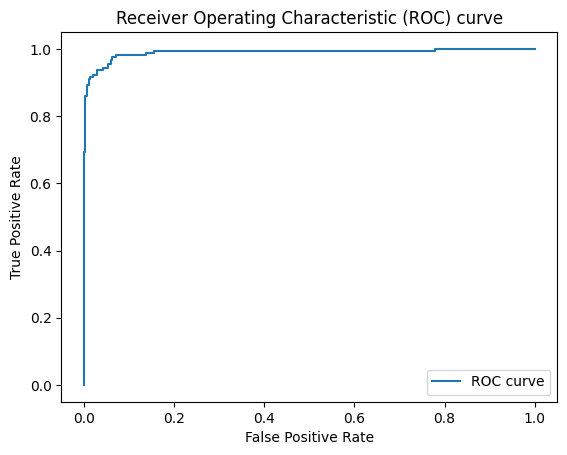

In [676]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [677]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9890329236565891


In [678]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.32782018


In [679]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [680]:
# Evaluating on Test set

print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.99      0.94      0.96       284
           1       0.89      0.97      0.93       157

    accuracy                           0.95       441
   macro avg       0.94      0.96      0.95       441
weighted avg       0.95      0.95      0.95       441

Test Accuracy: 0.95


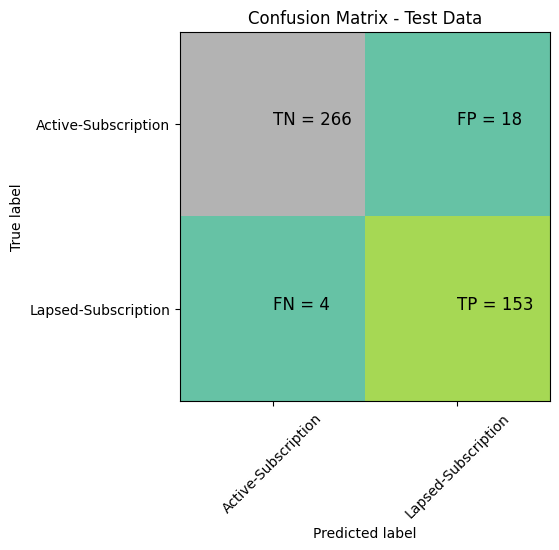

In [681]:
plot_confusion_matrix(y_test, y_pred_optimal)


XGBoost roc_value: 0.96
XGBoost threshold: 1.0
ROC for the test dataset 95.6%


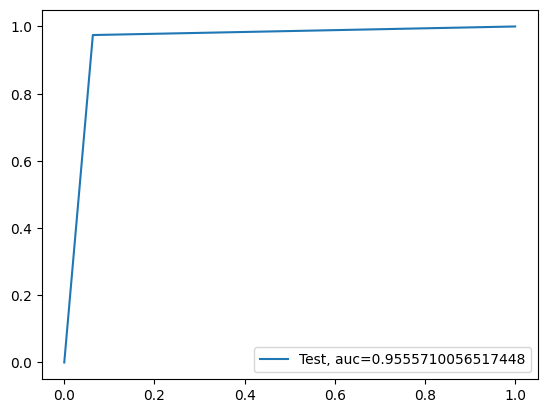

In [682]:
l2_roc_value = round(roc_auc_score(y_test, y_pred_optimal),2)
print("XGBoost roc_value: {0}".format(l2_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


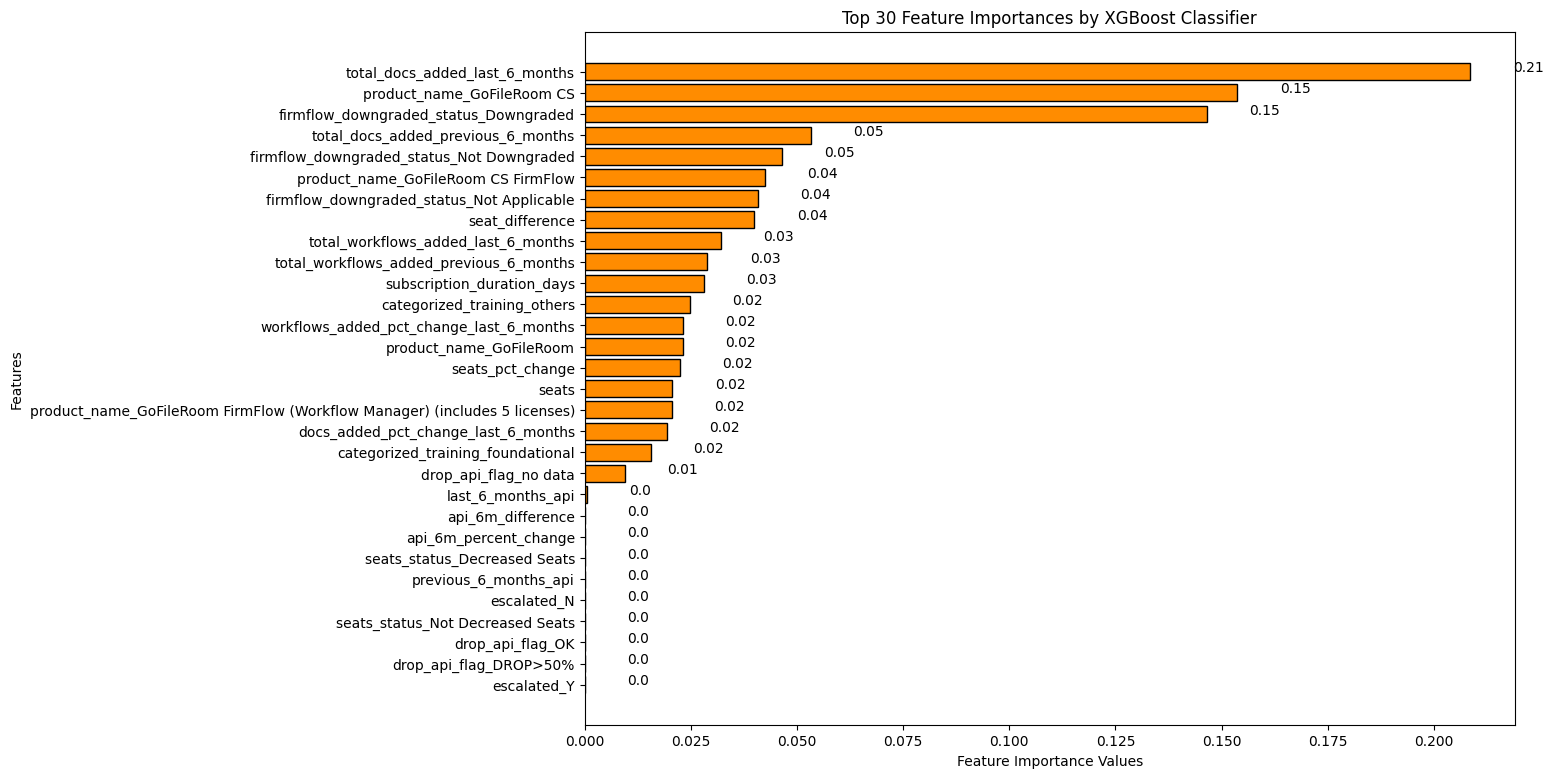

In [683]:
# Get the feature importances from the XGBoost classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_xgboost_recall.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by XGBoost Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()


## XGBoost - Bayesian optimization - scoring on Precision

In [684]:
# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42)


In [685]:
# Define the search space for hyperparameters
param_space = {
    'n_estimators': [5, 10, 20, 50, 80, 100, 120 ,150, 180, 200],
    'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100, 120, 140, 160],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
}

# Create the BayesSearchCV object
bayes_cv = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=param_space,
    scoring='precision',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=42
)

# Fit the BayesSearchCV object to the data
bayes_cv.fit(X_train, y_train)


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      feature_weights=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=No...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='precision',
              search_spaces={'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
                             'learning_rate': [0.01, 0.1, 0.2, 0.3],
                             'max_depth': [1, 2, 5, 10, 20, 30, 40, 60, 80, 100,
                                           120, 140, 160],
                             'n_estimators': [5, 10, 20, 50, 80, 100, 120, 150,
                                              180, 200],
                             'subsample': [0.5, 0.7, 0.8, 1.0]})

In [686]:
# Get the best hyperparameters and the corresponding maximum ROC AUC score
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_

print("Best parameters:", best_params)
print("Best precision score:", best_score)


Best parameters: OrderedDict({'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 60, 'n_estimators': 50, 'subsample': 0.7})
Best precision score: 1.0


In [687]:
# Get the best estimator from the BayesSearchCV object
best_estimator_xgboost_precision = bayes_cv.best_estimator_

# Evaluating on Training set`
y_pred_train = best_estimator_xgboost_precision.predict(X_train)
print(classification_report(y_train, y_pred_train))
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

print(confusion_matrix(y_train, y_pred_train))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1196
           1       1.00      0.69      0.82       566

    accuracy                           0.90      1762
   macro avg       0.94      0.84      0.87      1762
weighted avg       0.91      0.90      0.89      1762

Train Accuracy: 0.9001135073779796
[[1196    0]
 [ 176  390]]


In [688]:
#Get predicted probabilities for the positive class

y_probs = best_estimator_xgboost_precision.predict_proba(X_test)[:, 1]


In [689]:
# Calculate ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)


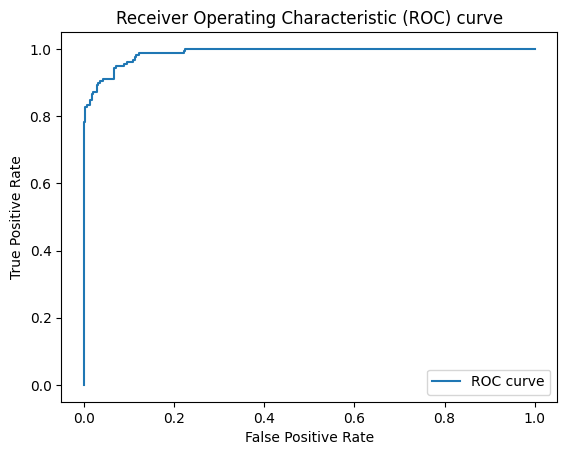

In [690]:
# Plot ROC curve

plt.plot(fpr, tpr, label = 'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()


In [691]:
# Calculate the AUC score

auc_score = roc_auc_score(y_test, y_probs)
print('AUC score:', auc_score)


AUC score: 0.9883825244460394


In [692]:
# Find the optimal cutoff point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Cutoff point:', optimal_threshold)


Optimal Cutoff point: 0.35532442


In [693]:
# Make predictions using the optimal cut off point
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)


In [694]:
# Evaluating on Test set

print(classification_report(y_test, y_pred_optimal))
accuracy = round(accuracy_score(y_test, y_pred_optimal),2)
print("Test Accuracy:", accuracy)


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       284
           1       0.88      0.95      0.91       157

    accuracy                           0.94       441
   macro avg       0.93      0.94      0.93       441
weighted avg       0.94      0.94      0.94       441

Test Accuracy: 0.94


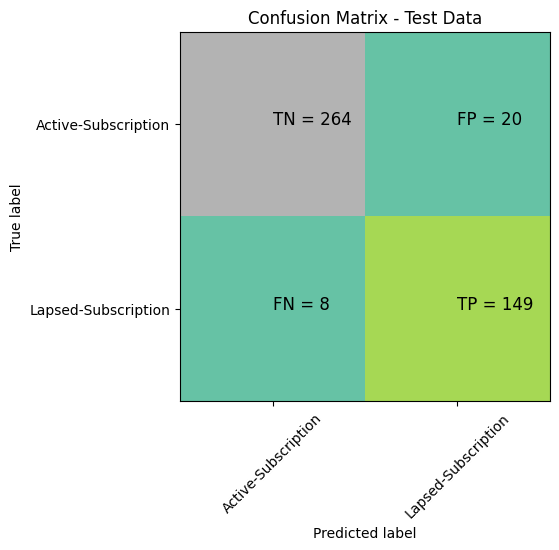

In [695]:
plot_confusion_matrix(y_test, y_pred_optimal)


XGBoost roc_value: 0.94
XGBoost threshold: 1.0
ROC for the test dataset 93.9%


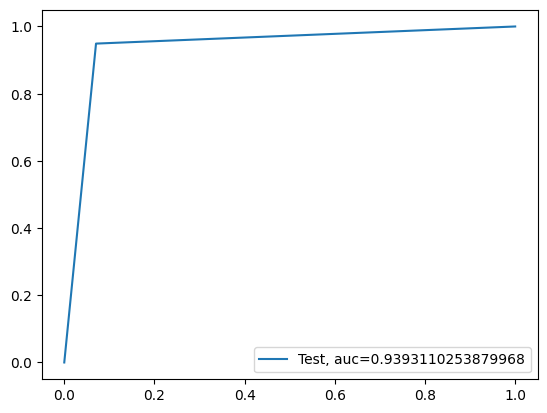

In [696]:
l2_roc_value = round(roc_auc_score(y_test, y_pred_optimal),2)
print("XGBoost roc_value: {0}".format(l2_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_optimal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGBoost threshold: {0}".format(threshold))

roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()


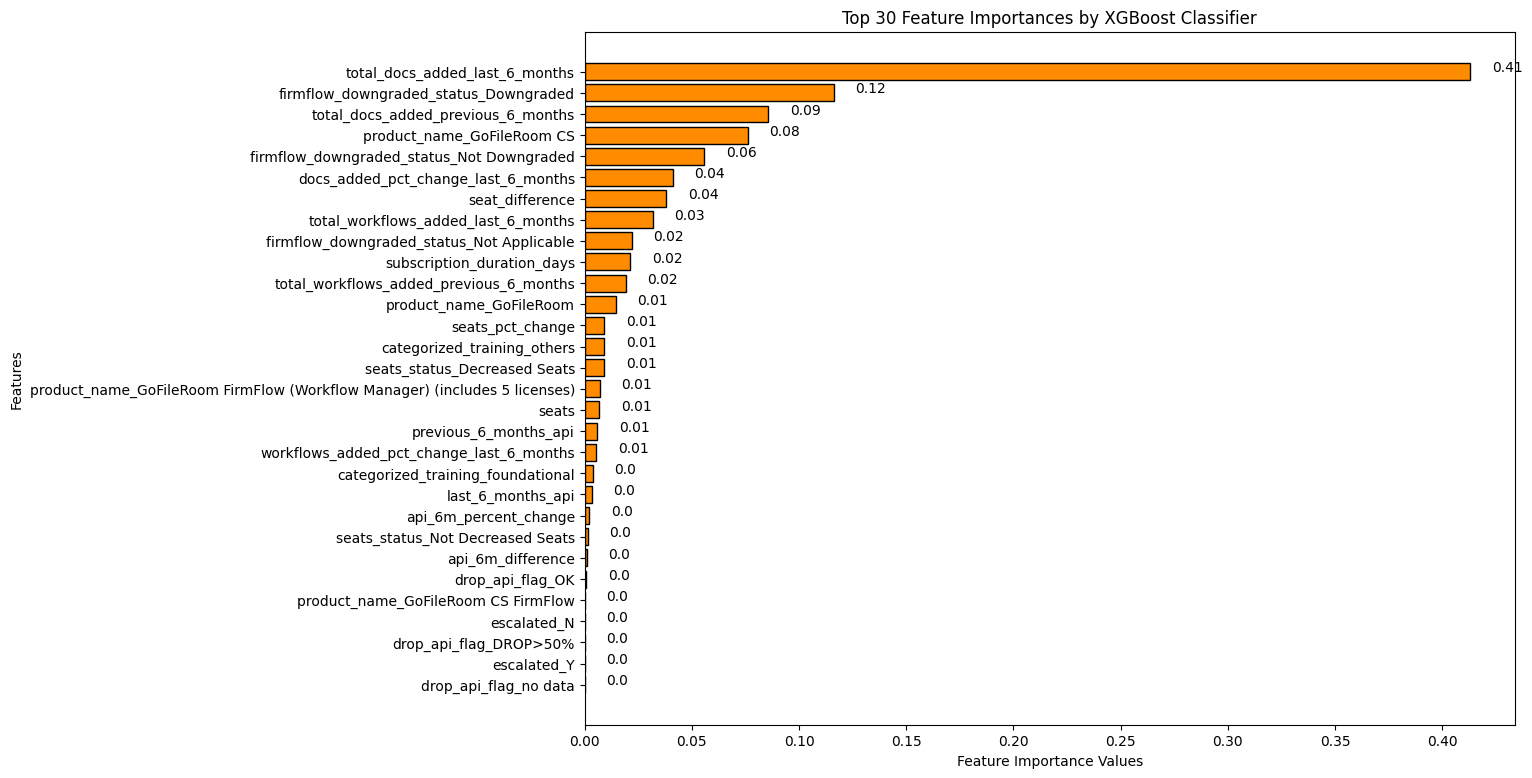

In [697]:
# Get the feature importances from the XGBoost classifier
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_estimator_xgboost_precision.feature_importances_})

# Sort the feature importances in descending order
feature_importance.sort_values('Importance', ascending=False, inplace=True)

# Select the top 30 features
top_30_features = feature_importance.head(30)

# Create the index for the bar plot
index = np.arange(len(top_30_features))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 9))

# Create the horizontal bar plot
xg_feature = ax.barh(index, top_30_features['Importance'], color='darkorange', edgecolor='black')

# Set the y-axis ticks and labels
ax.set_yticks(index)
ax.set_yticklabels(top_30_features['Feature'])

# Invert the y-axis
ax.invert_yaxis()

# Add labels to the bars
for i, v in enumerate(top_30_features['Importance']):
    ax.text(v + 0.01, i, str(round(v, 2)), color='black')

# Add title and labels to the plot
plt.title("Top 30 Feature Importances by XGBoost Classifier")
plt.xlabel("Feature Importance Values")
plt.ylabel("Features")

# Display the plot
plt.show()


## SHAP Features Importance

In [698]:
import shap


## Logistic SHAP

In [699]:
#Compute SHAP values for Logistic Regression
explainer_log = shap.Explainer(best_estimator_log, X_train)
shap_values_log = explainer_log(X_test)


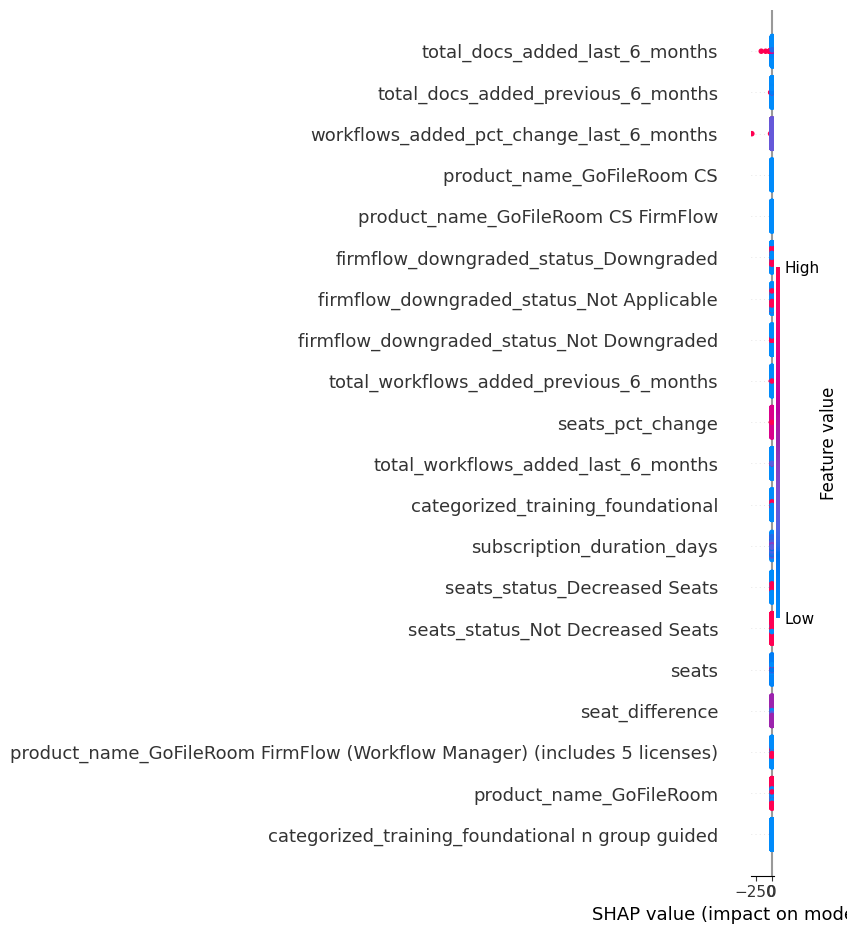

In [700]:
# Plot SHAP values summary plot for the logistic regression model

shap.summary_plot(shap_values_log, X_test)


## SHAP Xgboost roc auc

In [701]:
#Compute SHAP values for XGBoost on roc auc
explainer_xg = shap.Explainer(best_estimator_xgboost)
shap_values_xg = explainer_xg(X_test)


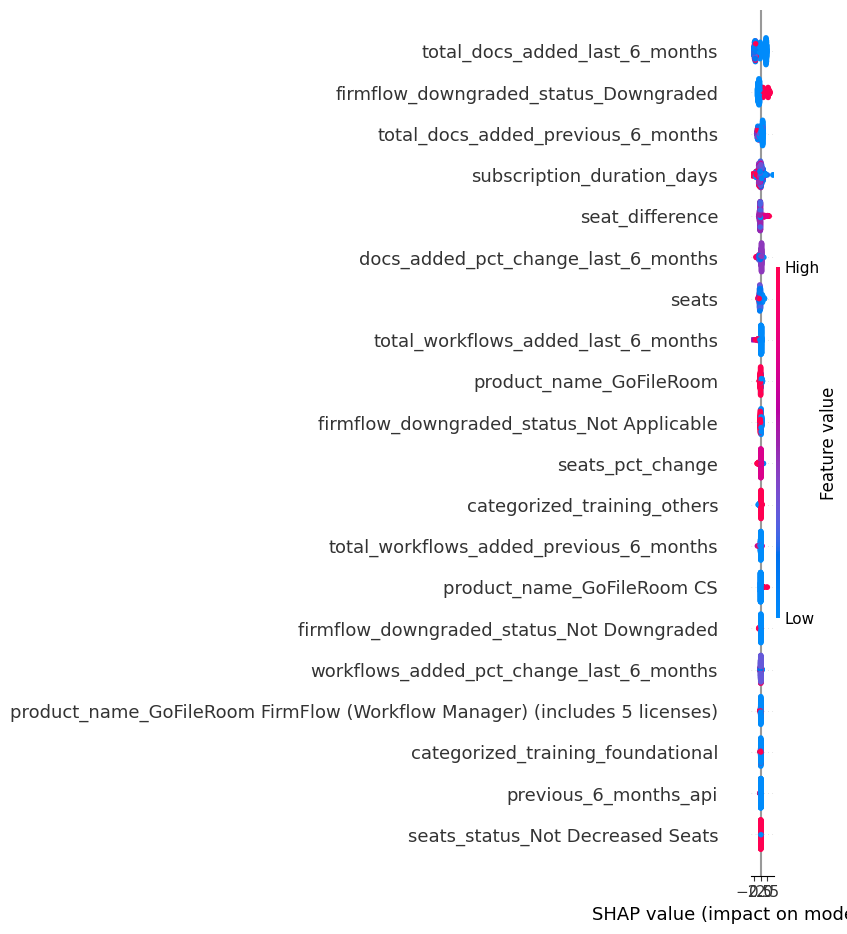

In [702]:
# Create a summary plot for the combined SHAP values
shap.summary_plot(shap_values_xg, X_test)


## SHAP Xgboost recall

In [703]:
#Compute SHAP values for XGBoost on roc auc
explainer_xg_recall = shap.Explainer(best_estimator_xgboost_recall)
shap_values_xg_recall = explainer_xg_recall(X_test)


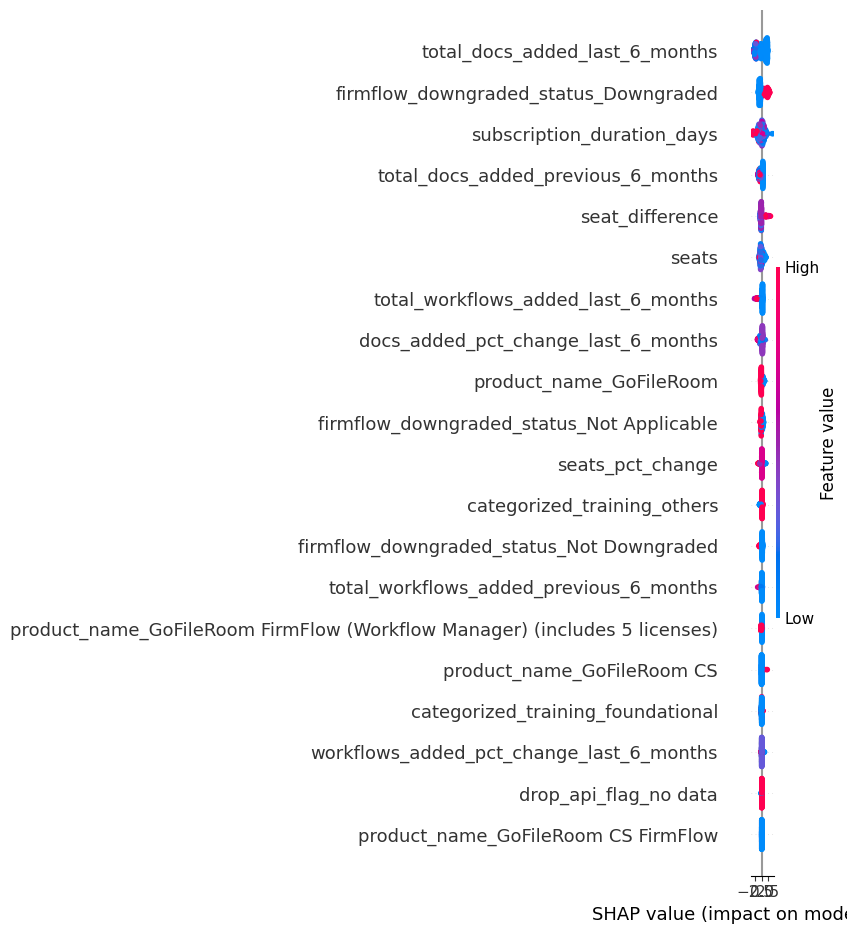

In [704]:
# Create a summary plot for the combined SHAP values
shap.summary_plot(shap_values_xg_recall, X_test)


## SHAP Xgboost Precision

In [705]:
#Compute SHAP values for XGBoost on precision
explainer_xg_precision = shap.Explainer(best_estimator_xgboost_precision)
shap_values_xg_precision = explainer_xg_precision(X_test)


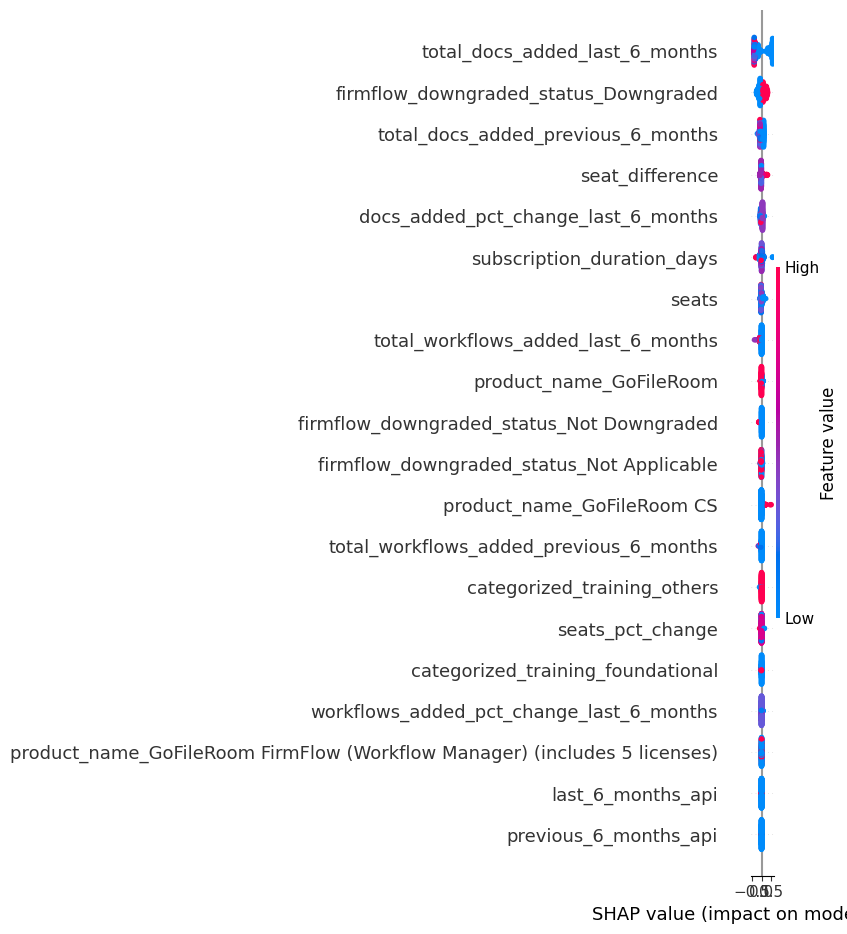

In [706]:
# Create a summary plot for the combined SHAP values
shap.summary_plot(shap_values_xg_precision, X_test)


## SHAP values for Random Forest - ROC AUC

In [707]:
#Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(best_estimator_rfc)
shap_values_rf = explainer_rf.shap_values(X_test.loc[:,:])


In [708]:
print("Shape of SHAP values:", shap_values_rf.shape)
print("Shape of X_test:", X_test.shape)


Shape of SHAP values: (441, 35, 2)
Shape of X_test: (441, 35)


In [710]:
averaged_shap_values_rf = np.mean(shap_values_rf, axis=2)
reshaped_shap_values_rf = np.reshape(averaged_shap_values_rf, (441,35))


In [711]:
reshaped_shap_values_rf.shape


(441, 35)

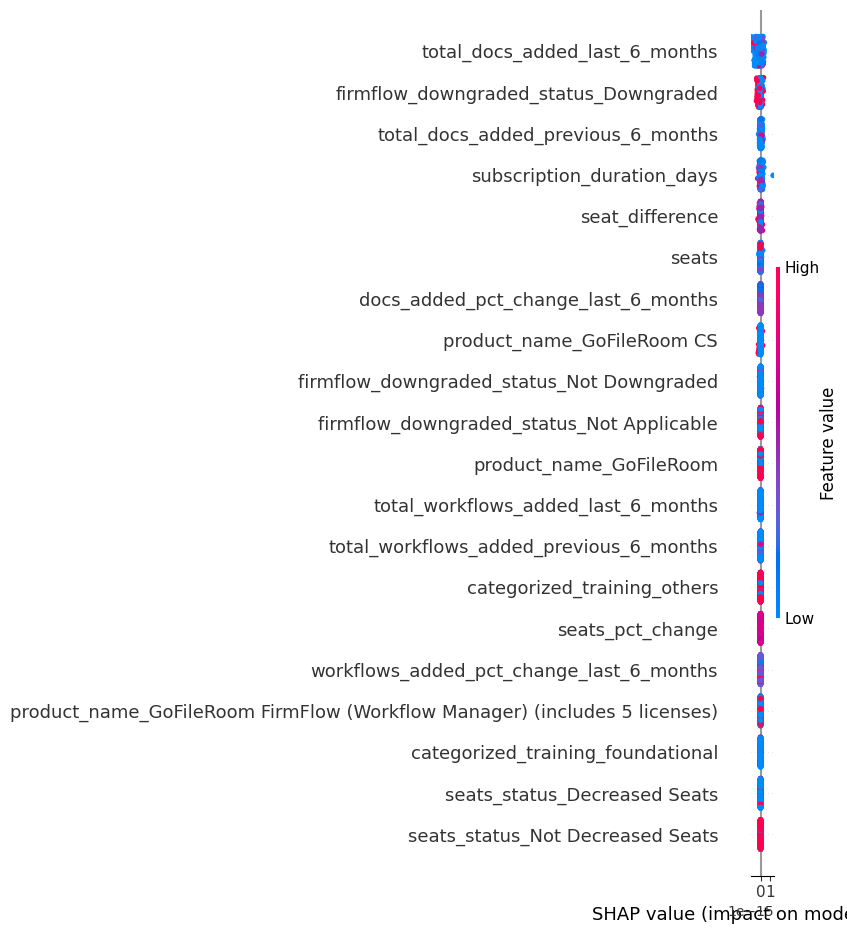

In [712]:
shap.summary_plot(reshaped_shap_values_rf, X_test)


Shape of SHAP values: (441, 35, 2)
Shape of X_test: (441, 35)


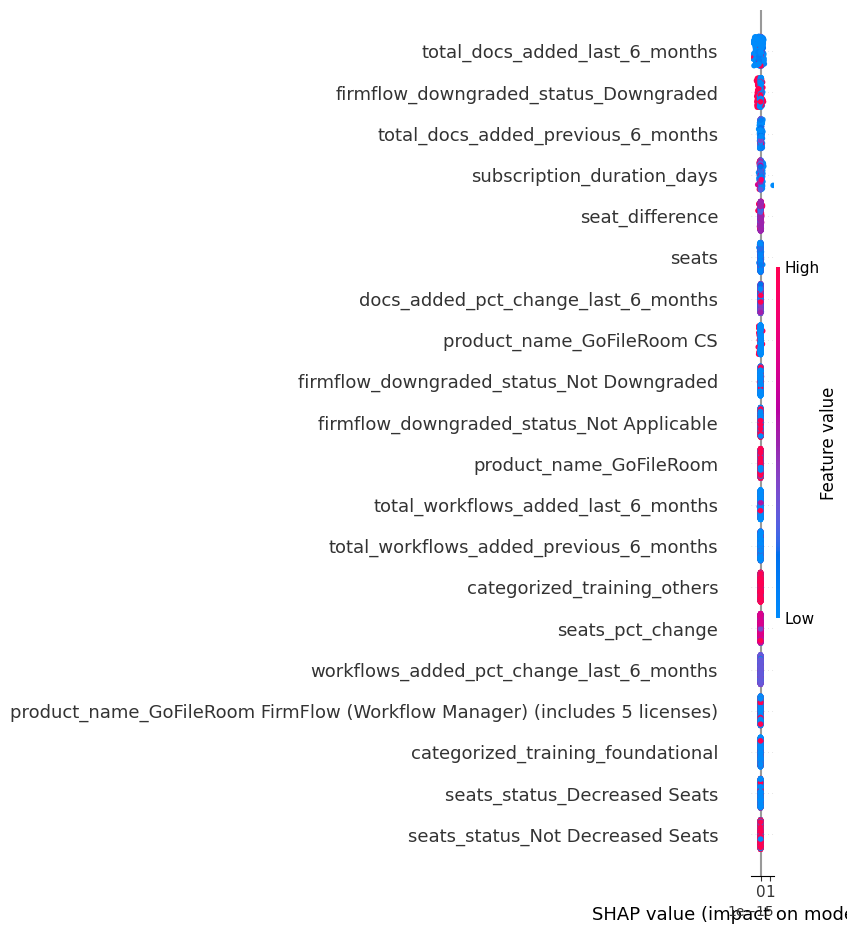

In [713]:
import shap
import numpy as np
import pandas as pd

# Assuming you have a trained Random Forest model and test data
# best_estimator_rf is your trained model
# X_test is your test dataset

# Create SHAP explainer
explainer_rf = shap.TreeExplainer(best_estimator_rfc)

# Compute SHAP values
shap_values_rf = explainer_rf.shap_values(X_test)

# Print shapes for verification
print("Shape of SHAP values:", np.array(shap_values_rf).shape)
print("Shape of X_test:", X_test.shape)

# Average SHAP values across classes (axis=2) if it's a multiclass model
averaged_shap_values_rf = np.mean(shap_values_rf, axis=2)

# Reshape to match the input shape for summary plot
reshaped_shap_values_rf = np.reshape(averaged_shap_values_rf, X_test.shape)

# Generate SHAP summary plot
shap.summary_plot(reshaped_shap_values_rf, X_test)


In [714]:
import pandas as pd
import shap

# Assuming you already have your model and test data
explainer_rf = shap.TreeExplainer(best_estimator_rfc)
shap_values_rf = explainer_rf.shap_values(X_test)

# Average across classes if it's a multiclass model
averaged_shap_values_rf = np.mean(shap_values_rf, axis=2)

# Reshape to match X_test
reshaped_shap_values_rf = averaged_shap_values_rf.reshape(X_test.shape)

# Create DataFrame with feature names
shap_df = pd.DataFrame(reshaped_shap_values_rf, columns=X_test.columns)

# Export to Excel
shap_df.to_excel("individual_shap_values.xlsx", index=False)


## SHAP values for Random Forest - Recall

In [715]:
#Compute SHAP values for Random Forest
explainer_rf_recall = shap.TreeExplainer(best_estimator_rfc_recall)
shap_values_rf_recall = explainer_rf_recall.shap_values(X_test.loc[:,:])


In [716]:
print("Shape of SHAP values:", shap_values_rf_recall.shape)
print("Shape of X_test:", X_test.shape)


Shape of SHAP values: (441, 35, 2)
Shape of X_test: (441, 35)


In [718]:
averaged_shap_values_rf_recall = np.mean(shap_values_rf_recall, axis=2)
reshaped_shap_values_rf_recall = np.reshape(averaged_shap_values_rf_recall, (441,35))


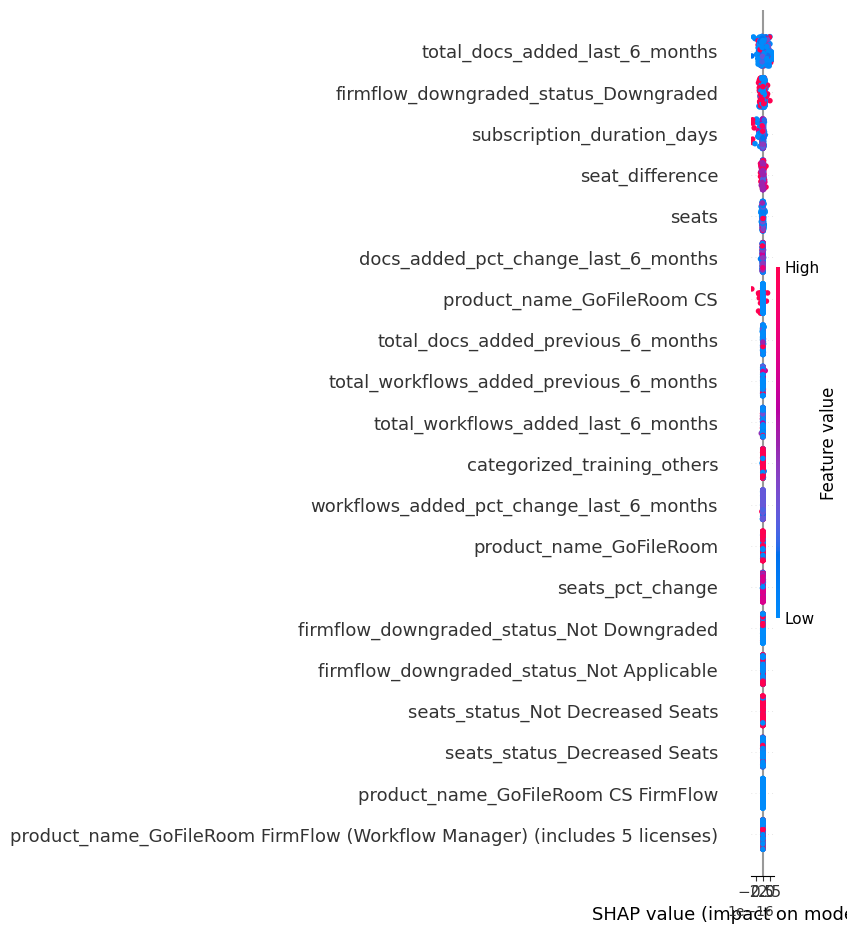

In [719]:
shap.summary_plot(reshaped_shap_values_rf_recall, X_test)


## SHAP for RFC Precision

In [720]:
#Compute SHAP values for Random Forest
explainer_rf_precision = shap.TreeExplainer(best_estimator_rfc_precision)
shap_values_rf_precision = explainer_rf_precision.shap_values(X_test.loc[:,:])


In [721]:
print("Shape of SHAP values:", shap_values_rf_precision.shape)
print("Shape of X_test:", X_test.shape)


Shape of SHAP values: (441, 35, 2)
Shape of X_test: (441, 35)


In [723]:
averaged_shap_values_rf_precision = np.mean(shap_values_rf_precision, axis=2)
reshaped_shap_values_rf_precision = np.reshape(averaged_shap_values_rf_precision, (441,35))


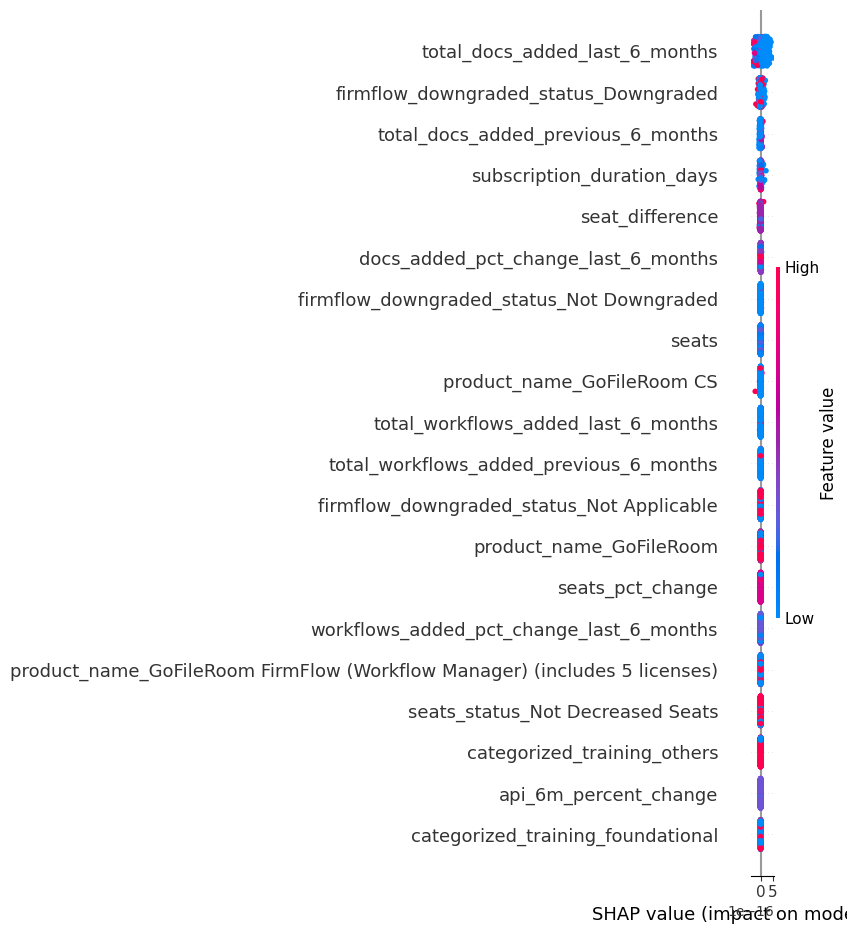

In [724]:
shap.summary_plot(reshaped_shap_values_rf_precision, X_test)


## Data preprocessing for predicting churn on new dataset

df_risk_firms = pd.read_excel('GFR_churn_risk_Jan_2026.xlsx')

In [725]:
#active firms with critical and high risk
active_critical_high_risk_firms = df_risk_firms[
    (df_risk_firms['status_flag'] == 'Active') &
    (df_risk_firms['churn_risk'].isin(['Critical', 'High']))
]


In [726]:
active_critical_high_risk_firms.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk,categorized_training
58,42361,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.000000,89.5,Critical,others
64,42324,GoFileRoom FirmFlow (Workflow Manager) (includ...,3681,25,Active,"Biel Fisette Iacono, LLP",0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Conversion, TS Conversion",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High,others
82,30496,GoFileRoom FirmFlow (Workflow Manager) (includ...,1124,10,Active,"GOHLKE & COMPANY, P.C.",0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Essential Package, Essentia...",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High,others
164,10714,GoFileRoom FirmFlow (Workflow Manager) (includ...,637,40,Active,HD Growth Partners LLC,0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Guided Implementation",16409.0,223.0,498600.0,3349.0,-96.708985,-93.341296,69.5,High,others
197,87582,GoFileRoom FirmFlow (Workflow Manager) (includ...,1986,10,Active,"Wubbels & Duffy, CPAs, RLLP",-5.0,Decreased Seats,-33.3333,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,1.0,0.0,247.0,0.0,-99.595142,0.000000,79.5,High,others


In [727]:
active_critical_high_risk_firms.shape


(114, 27)

In [728]:
active_critical_high_risk_firms.columns


Index(['firm_id', 'product_name', 'subscription_duration_days', 'seats',
       'status_flag', 'firm_name', 'seat_difference', 'seats_status',
       'seats_pct_change', 'firmflow_downgraded_status', 'escalated',
       'last_6_months_api', 'previous_6_months_api', 'api_6m_difference',
       'api_6m_percent_change', 'drop_api_flag', 'no_api_6m_flag',
       'training_type_combined', 'total_docs_added_last_6_months',
       'total_workflows_added_last_6_months',
       'total_docs_added_previous_6_months',
       'total_workflows_added_previous_6_months',
       'docs_added_pct_change_last_6_months',
       'workflows_added_pct_change_last_6_months', 'risk_percentage',
       'churn_risk', 'categorized_training'],
      dtype='object')

In [729]:
columns_to_drop = [
'firm_name', 'training_type_combined', 'churn_risk', 'risk_percentage'
]

# Drop the columns
df_new = active_critical_high_risk_firms.drop(columns=columns_to_drop)


In [730]:
# Perform one-hot encoding`
df_new_encoded = pd.get_dummies(df_new, columns=['product_name', 'seats_status', 'firmflow_downgraded_status', 'escalated', 'drop_api_flag', 'no_api_6m_flag', 'categorized_training'])


In [731]:
df_new_encoded['firm_status_encoded'] = label_encoder.fit_transform(df_new_encoded['status_flag'])


In [732]:
df_new_encoded.head()


,firm_id,subscription_duration_days,seats,status_flag,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_others,firm_status_encoded
58,42361,392,0,Active,-100.0,-100.0000,0.0,0.0,0.0,0.0,386.0,0.0,4925.0,0.0,-92.162437,0.000000,True,False,True,False,True,True,False,False,False,True,False,False,True,False,True,0
64,42324,3681,25,Active,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,False,True,False,True,True,True,False,False,False,True,False,False,True,False,True,0
82,30496,1124,10,Active,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,False,True,False,True,True,True,False,False,False,True,False,False,True,False,True,0
164,10714,637,40,Active,0.0,0.0000,0.0,0.0,0.0,0.0,16409.0,223.0,498600.0,3349.0,-96.708985,-93.341296,False,True,False,True,True,True,False,False,False,True,False,False,True,False,True,0
197,87582,1986,10,Active,-5.0,-33.3333,0.0,0.0,0.0,0.0,1.0,0.0,247.0,0.0,-99.595142,0.000000,False,True,True,False,True,True,False,False,False,True,False,False,True,False,True,0


In [733]:
# converting bool columns to int
df_new_encoded[df_new_encoded.select_dtypes(include=[bool]).columns] = df_new_encoded.select_dtypes(include=[bool]).astype(int)


In [734]:
df_new_encoded.head()


,firm_id,subscription_duration_days,seats,status_flag,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_others,firm_status_encoded
58,42361,392,0,Active,-100.0,-100.0000,0.0,0.0,0.0,0.0,386.0,0.0,4925.0,0.0,-92.162437,0.000000,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0
64,42324,3681,25,Active,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0,1,0,1,1,1,0,0,0,1,0,0,1,0,1,0
82,30496,1124,10,Active,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0,1,0,1,1,1,0,0,0,1,0,0,1,0,1,0
164,10714,637,40,Active,0.0,0.0000,0.0,0.0,0.0,0.0,16409.0,223.0,498600.0,3349.0,-96.708985,-93.341296,0,1,0,1,1,1,0,0,0,1,0,0,1,0,1,0
197,87582,1986,10,Active,-5.0,-33.3333,0.0,0.0,0.0,0.0,1.0,0.0,247.0,0.0,-99.595142,0.000000,0,1,1,0,1,1,0,0,0,1,0,0,1,0,1,0


In [735]:
# Dropping firm_id, status_flag

df_new_encoded_final = df_new_encoded.drop(['firm_id', 'status_flag'], axis = 1)


## Applying model on the data

In [736]:
# Putting feature variable to X
X_new = df_new_encoded_final.drop(['firm_status_encoded'], axis=1)

# Putting response/target variable to y
y_new = df_new_encoded_final['firm_status_encoded']


In [737]:
trained_columns = X_train.columns


In [738]:
prediction_columns = X_new.columns


In [739]:
missing_columns = [col for col in trained_columns if col not in prediction_columns]


In [740]:
for col in missing_columns:
    X_new[col] = 0


In [741]:
X_new = X_new[trained_columns]


In [742]:
X_new.head()


,subscription_duration_days,seats,seat_difference,seats_pct_change,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,product_name_GoFileRoom,product_name_GoFileRoom CS,product_name_GoFileRoom CS FirmFlow,product_name_GoFileRoom FirmFlow (Workflow Manager) (includes 5 licenses),seats_status_Decreased Seats,seats_status_Not Decreased Seats,firmflow_downgraded_status_Downgraded,firmflow_downgraded_status_Not Applicable,firmflow_downgraded_status_Not Downgraded,escalated_N,escalated_Y,drop_api_flag_DROP>50%,drop_api_flag_OK,drop_api_flag_no data,no_api_6m_flag_NO_CALLS,no_api_6m_flag_OK,no_api_6m_flag_no data,categorized_training_foundational,categorized_training_foundational n group guided,categorized_training_group guided,categorized_training_others
58,392,0,-100.0,-100.0000,0.0,0.0,0.0,0.0,386.0,0.0,4925.0,0.0,-92.162437,0.000000,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
64,3681,25,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
82,1124,10,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
164,637,40,0.0,0.0000,0.0,0.0,0.0,0.0,16409.0,223.0,498600.0,3349.0,-96.708985,-93.341296,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1
197,1986,10,-5.0,-33.3333,0.0,0.0,0.0,0.0,1.0,0.0,247.0,0.0,-99.595142,0.000000,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [743]:
y_probs_new = best_estimator_xgboost_recall.predict_proba(X_new)[:,1]


In [744]:
optimal_threshold


np.float32(0.35532442)

In [745]:
#Apply the cut off threshold
cutoff_threshold = 0.43682920932769775


In [746]:
y_pred_new =(y_probs_new >= cutoff_threshold).astype(int)


In [748]:
# Print the probabilities and binary predictions
for i, prob in enumerate(y_probs_new):
    print(f"Record {i+1}: Probability = {prob:.2f}, Prediction = {y_pred_new[i]}")


Record 1: Probability = 0.87, Prediction = 1
Record 2: Probability = 1.00, Prediction = 1
Record 3: Probability = 1.00, Prediction = 1
Record 4: Probability = 0.10, Prediction = 0
Record 5: Probability = 0.48, Prediction = 1
Record 6: Probability = 0.09, Prediction = 0
Record 7: Probability = 0.92, Prediction = 1
Record 8: Probability = 0.99, Prediction = 1
Record 9: Probability = 0.01, Prediction = 0
Record 10: Probability = 0.19, Prediction = 0
Record 11: Probability = 0.99, Prediction = 1
Record 12: Probability = 0.97, Prediction = 1
Record 13: Probability = 0.94, Prediction = 1
Record 14: Probability = 0.99, Prediction = 1
Record 15: Probability = 1.00, Prediction = 1
Record 16: Probability = 0.08, Prediction = 0
Record 17: Probability = 0.99, Prediction = 1
Record 18: Probability = 0.77, Prediction = 1
Record 19: Probability = 1.00, Prediction = 1
Record 20: Probability = 1.00, Prediction = 1
Record 21: Probability = 1.00, Prediction = 1
Record 22: Probability = 0.94, Prediction =

In [749]:
# Create a DataFrame with the probabilities and predictions
results_df = pd.DataFrame({
    'firm_id': active_critical_high_risk_firms['firm_id'],
    'churn_probability': y_probs_new,
    'model_prediction': y_pred_new
})


In [ ]:
# Merge the results with the original DataFrame on firm_ID
final_result = pd.merge(active_critical_high_risk_firms, results_df, on='firm_id')


In [751]:
final_result.head()


,firm_id,product_name,subscription_duration_days,seats,status_flag,firm_name,seat_difference,seats_status,seats_pct_change,firmflow_downgraded_status,escalated,last_6_months_api,previous_6_months_api,api_6m_difference,api_6m_percent_change,drop_api_flag,no_api_6m_flag,training_type_combined,total_docs_added_last_6_months,total_workflows_added_last_6_months,total_docs_added_previous_6_months,total_workflows_added_previous_6_months,docs_added_pct_change_last_6_months,workflows_added_pct_change_last_6_months,risk_percentage,churn_risk,categorized_training,churn_probability,model_prediction
0,42361,GoFileRoom,392,0,Active,"Haskell & White, LLP",-100.0,Decreased Seats,-100.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"AuditWatch/TaxWatch, AuditWatch/TaxWatch",386.0,0.0,4925.0,0.0,-92.162437,0.000000,89.5,Critical,others,0.868702,1
1,42324,GoFileRoom FirmFlow (Workflow Manager) (includ...,3681,25,Active,"Biel Fisette Iacono, LLP",0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Conversion, TS Conversion",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High,others,0.999081,1
2,30496,GoFileRoom FirmFlow (Workflow Manager) (includ...,1124,10,Active,"GOHLKE & COMPANY, P.C.",0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"Essential Package, Essential Package, Essentia...",0.0,0.0,0.0,0.0,0.000000,0.000000,69.5,High,others,0.999048,1
3,10714,GoFileRoom FirmFlow (Workflow Manager) (includ...,637,40,Active,HD Growth Partners LLC,0.0,Not Decreased Seats,0.0000,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,"TS Migration (G), Guided Implementation",16409.0,223.0,498600.0,3349.0,-96.708985,-93.341296,69.5,High,others,0.096124,0
4,87582,GoFileRoom FirmFlow (Workflow Manager) (includ...,1986,10,Active,"Wubbels & Duffy, CPAs, RLLP",-5.0,Decreased Seats,-33.3333,Downgraded,N,0.0,0.0,0.0,0.0,no data,no data,,1.0,0.0,247.0,0.0,-99.595142,0.000000,79.5,High,others,0.477233,1


In [752]:
final_result.to_excel(r'C:\Users\6129794\OneDrive - Thomson Reuters Incorporated\GFR Churn\GFR_churn_probability_xgboost_recall_Jan_2026.xlsx', index = False)
